## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Camera Calibration ##

#### 1.1 Compute the camera calibration matrix and distortion coefficients given a set of chessboard images ####

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

""""
Read calibration images and plot their corners
Save the objpoints and imgpoints (corners) for use in next step

""""
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()





This is a test



### Undistort  Chessboard Image ###

#### 1.2 Read a sample chessboard image and apply a distortion correction to raw images ####


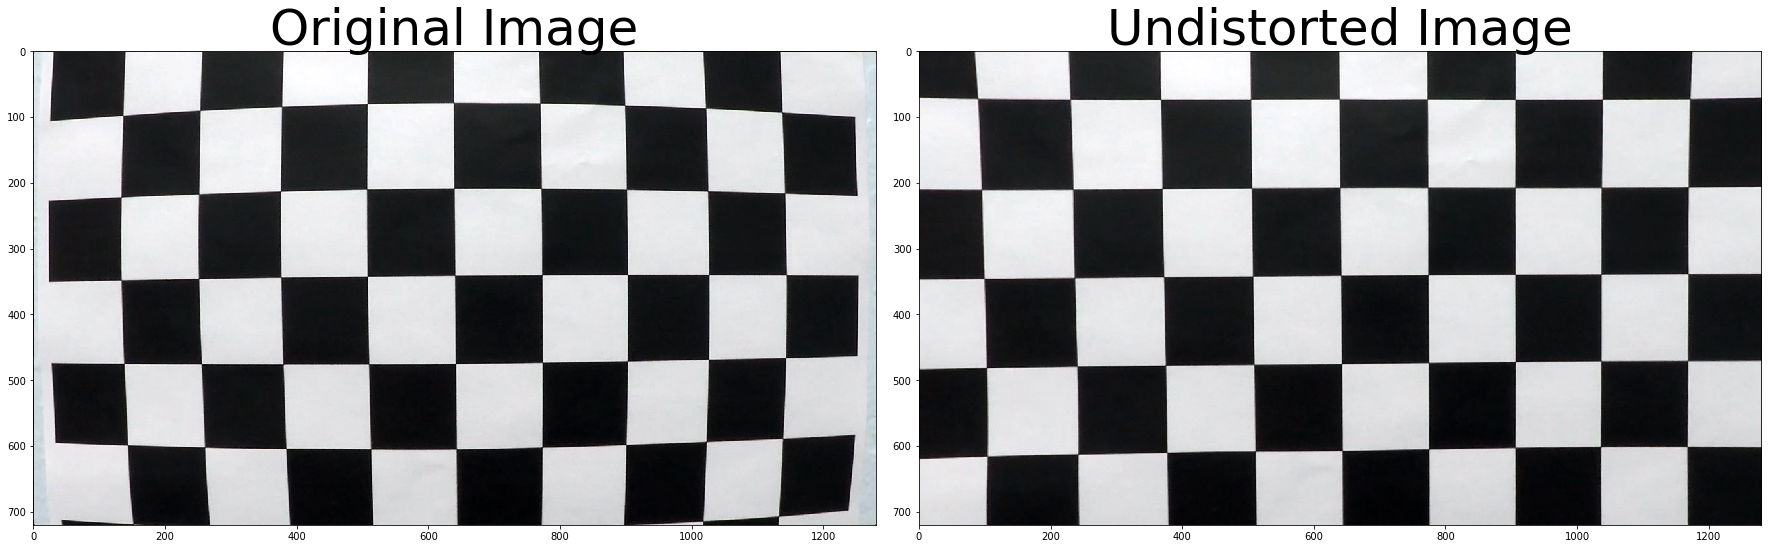

In [14]:
import pickle
import matplotlib.image as mpimg


# Get the test image
orig_img = cv2.imread('camera_cal/calibration1.jpg')


def image_undistort(img, objpoints, imgpoints):

    """
    Get the image, objpoins and imgpoints from last step
    Undistort the image using cv2.undistort
    Returns undistorted image as output

    """
   
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Use cv2.calibrateCamera() to calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
    gray.shape[::-1], None, None)
    
    # Use cv2.undistort() to undistort the image using calibration
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist

# Call the function to undistort the original image using the
# objpoints and imgpoints obtained in previous cell
undistorted = image_undistort(orig_img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



---


---

## 2. Pipeline - Single Images ##

### 2.1. Apply Undistortion to Test Images ###
Apply the undistortion to test images. Display a sample image

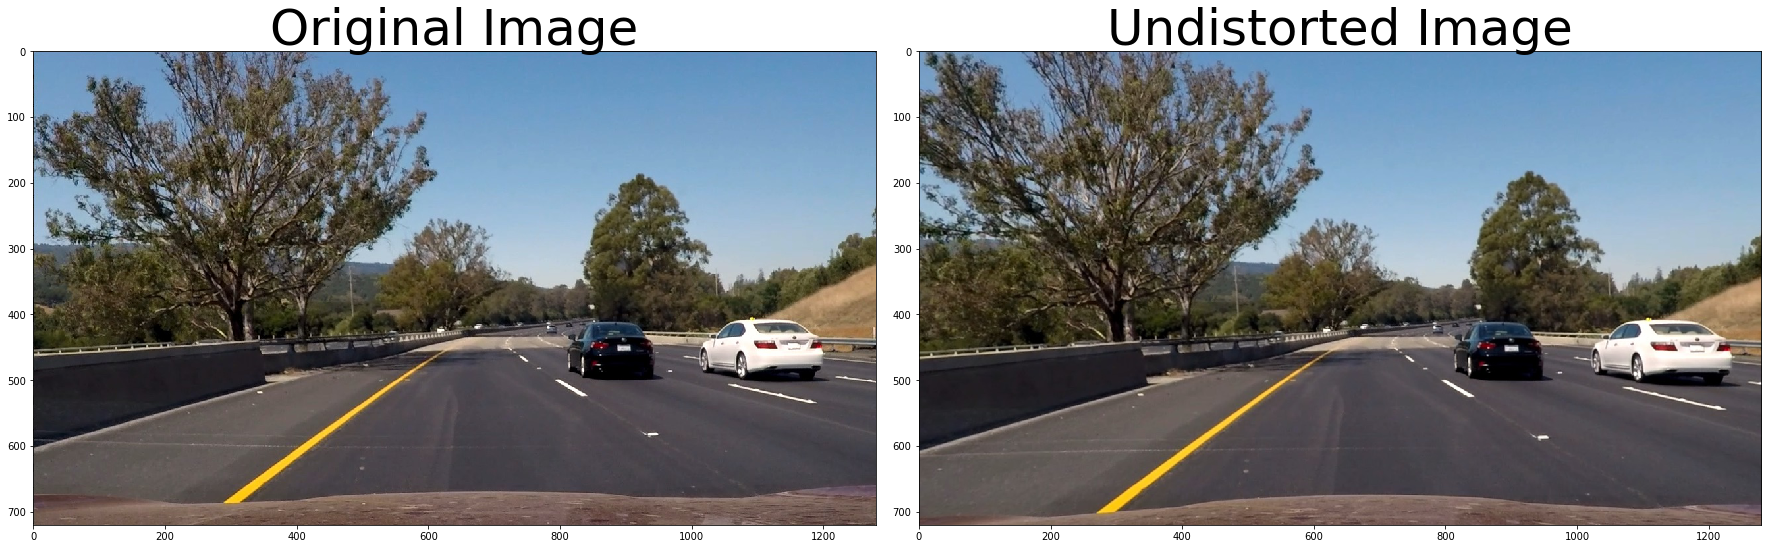

In [20]:
import os

"""
Read all images in the test_images folder
Undistort the image by calling 'image_undistort()'
Write the indistorted images to output_images folder

"""

# Define the input and output directories
input_dir = "test_images/"
output_dir = "output_images/"
files = os.listdir(input_dir)


for file in files:
    # Get the original image    
    orig_img = mpimg.imread(input_dir + file)
    
    # Call the function to undistort the original image using the
    # objpoints and imgpoints obtained in previous cell
    undistorted = image_undistort(orig_img, objpoints, imgpoints)
    
    # Write the file to the output folder
    cv2.imwrite(output_dir + "Undist_" + file, undistorted)

# Display the last image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



---

### 2.2. Get Binary Image Using Thresholds ###

Use color transforms, gradients, etc., to create a thresholded binary image

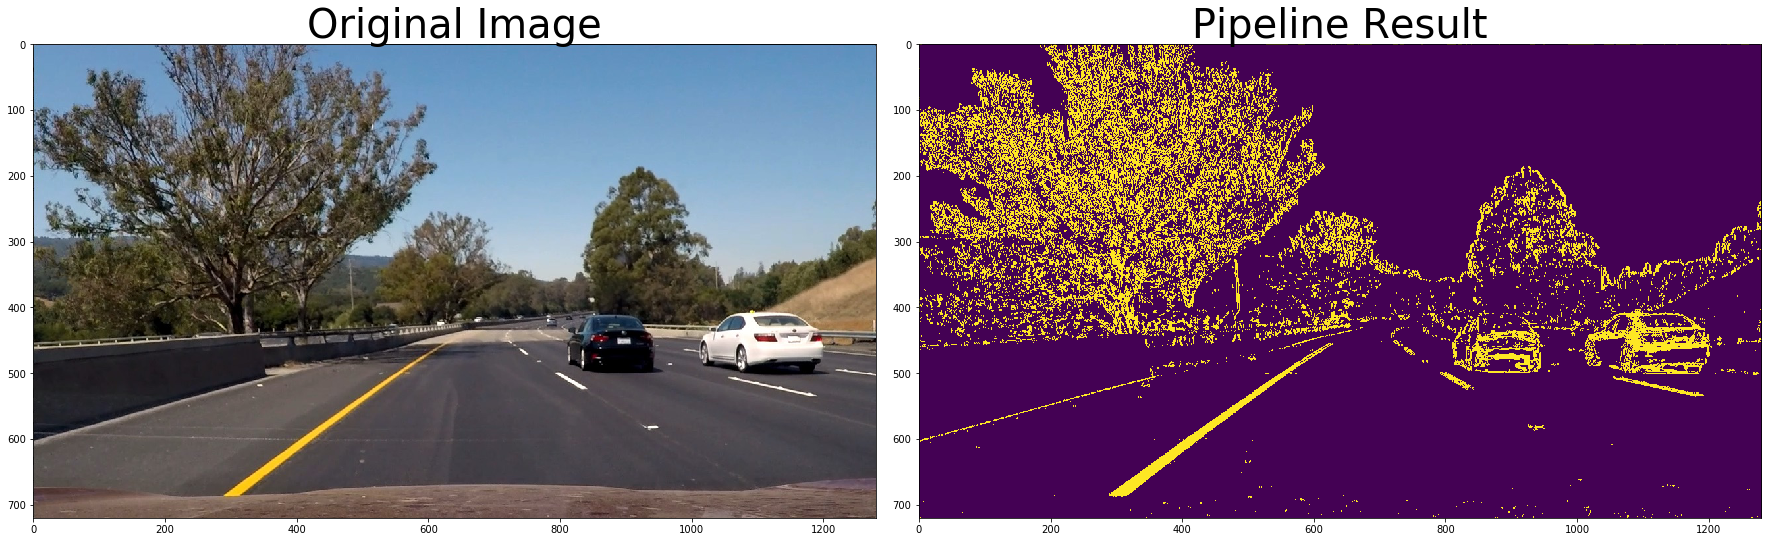

In [136]:
image = mpimg.imread('test_images/test6.jpg')

# Edit this function to create your own pipeline.
def apply_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    Receive undistorted image and thresholds as arguments 
    Apply the thresholds, and combine into binary image
    Return the binary image

    """
    
    img = np.copy(img)
            
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combined Thresholds to get binary image
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #return color_binary
    return combined_binary

# Call the function to apply threholds
threshold_image = apply_threshold(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(threshold_image)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---

### 2.3. Warp Image Using Perspective Transform ###

Apply a perspective transform to rectify binary image ("birds-eye view")

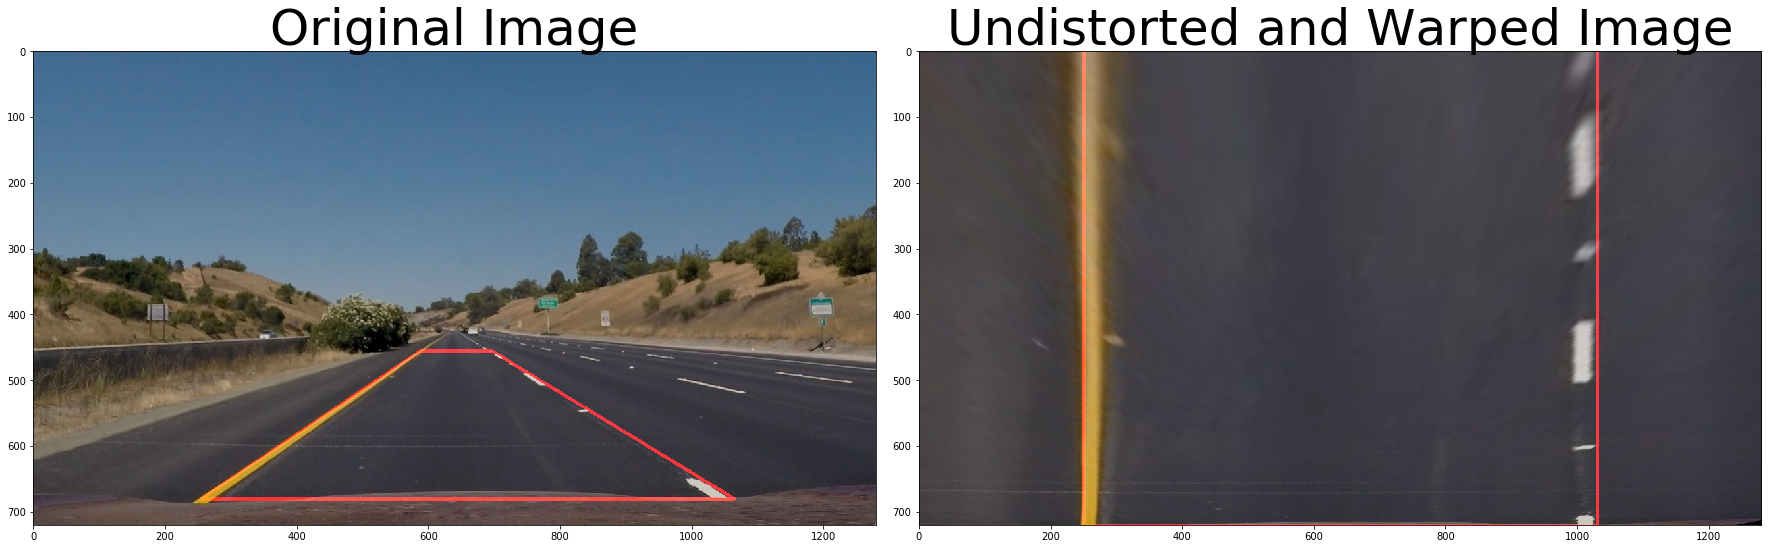

In [170]:
# Read a sample image
image = mpimg.imread('test_images/straight_lines1.jpg')
margin  = 250
p1 = [588, 455]
p2 = [696, 455]
p3 = [255, 680]
p4 = [1065, 680]
src = np.float32([p1, p2, p3, p4])
#dst = np.float32([[margin,margin],[img.shape[1]-margin, margin],[margin, img.shape[0]],[img.shape[1], img.shape[0]]])
#dst = np.float32([[0,0],[img.shape[1], 0],[0, img.shape[0]],[img.shape[1], img.shape[0]]])
dst = np.float32([[margin,0],
                  [image.shape[1]-margin, 0],
                  [margin, image.shape[0]],
                  [image.shape[1]- margin, image.shape[0]]])

# Define indices for lines
lines_orig = [tuple(p1), tuple(p2), tuple(p4),  tuple(p3), tuple(p1)]
lines_warp = [(image.shape[1]-margin, 0), (image.shape[1]-margin, image.shape[0]), (margin, image.shape[0]), 
               (margin, 0)]

def warp_image(img, src, dst):
    """
    Receive binary image, source points, and destination points as arguments 
    Warp the image to make the lanes parallel
    Return the warped image and perspective transform matrices for later use

    """
    
    # Define the source and the destination points
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_size = img.shape[1::-1]
    # Get the warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def draw_lines(image, lines, color=[255, 0, 0], thickness=3):
    """
    Get an image and an array which is a set of points
    Draw the lines on the image using points from lines
    Return the image with lines drawn

    """        
    
    # Mark points on the original image
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    for i in range(len(lines)-1):
        cv2.line(line_img, lines[i], lines[i+1], color, thickness)
    return cv2.addWeighted(image, 0.8, line_img, 1., 0.)


#warped_image = warp_image(result, src, dst)
warped_image, perspective_M, perspective_Minv = warp_image(image, src, dst)

orig_image_lines = draw_lines(orig_image, lines_orig)
warped_image_lines = draw_lines(warped_image, lines_warp)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_image_lines)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image_lines)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


---

### 2.4. Identify Lane Pixels ###

Detect lane pixels and fit to find the lane boundary.

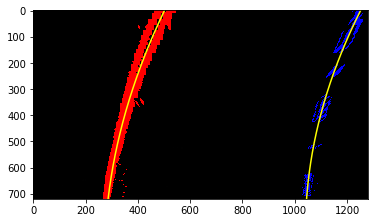

In [243]:
# Read a sample image
image = mpimg.imread('test_images/test3.jpg')


def find_lane_pixels(binary_warped):
    """"
    Receives the binary warped image as argument 
    Uses a limit on histogram to classify useful points, separately for left and right lanes
    Return x and y points array for each lane, and an image with the points plotted

    """    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Find the boundaries of the window
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
       
    
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),(0,255,0), 2)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &
        (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &
        (nonzerox < win_xright_high)).nonzero()[0]
                
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds)> minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)> minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        #print("Exception in Try")
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, xm_per_pix=1, ym_per_pix=1):
    """
    Receive binary image, and meters o pixel ration for x and y axis, default it 1 to 
    return values as pixels, otherwise in meters
    Call 'find_lane_pixels' to get the needed arrays of points
    Use the arrays with x and y coordinates to fit a 2nd degree polynomial
    Plot the polynomial on a blank image
    Return the polynomial coefficients, points generated using the polynomial,
    and an image with those points plotted

    """
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each
    # xm_per_pix, ym_per_pix values are 1 by default
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix , 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = ym_per_pix * np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx


binary_image = apply_threshold(image)
binary_warped, M, Minv = warp_image(binary_image, src, dst)
plt.imshow(binary_warped)
out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped)

# Plot the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(out_img)

---

### 2.5. Calculate Radius of Curvature, Offset ###

Determine the curvature of the lane and vehicle position with respect to center

Left Curvature: 653.618777151
Right Curvature: 549.438020691
Lane Offset(m): -10


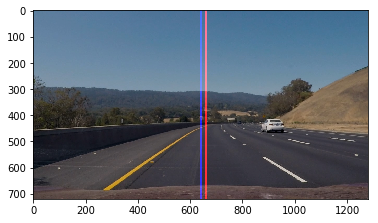

In [271]:
xm_per_pix = 3.7/700 # meters per pixel in x dimension
ym_per_pix = 30/720 # meters per pixel in y dimension


def measure_curvature(ploty, left_fit, right_fit):
    '''
    Gets ploty, left_fit, right_fit values as argument, provided by 'fit_polynomial'
    Calculates the curvature of polynomial functions, units depend on the last function call
    Returns the radius of curvature for both lanes
    '''      
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Implement the calculation of R_curve (radius of curvature) #####
    
    left_curverad = (1+((2*left_fit[0]*y_eval) + left_fit[1])**2)/(2*left_fit[0])
    right_curverad = (1+((2*right_fit[0]*y_eval) + right_fit[1])**2)/(2*right_fit[0])
        
    return left_curverad, right_curverad


def calculate_offset(orig_image, lines):
    '''
    Gets original image, and list of points as array
    Calculates the offset taking the difference between mid-point of two lanes, 
    and the mid point of the image
    Assumption: Mid point of the image fram is aligned with center of vehicle
    Returns the offset, and mid points
    '''     
    # Get the center of the image/ vehicle
    image_mid = ((orig_image.shape[1])//2)
    
    # Determine mid-point of lane using points used to draw lane lines
    lane_mid = (lines[2][0] + lines[3][0])//2
    
    # Find the difference between two, and convert to meters
    lane_offset = ((image_mid - lane_mid)//2)     # in pixels
    return lane_offset, image_mid, lane_mid



def plot_offset(image, image_mid, lane_mid):
    '''
    Gets original image, mid points array
    Plots the mid points as lines on the image
    Returns the image with lines plotted
    '''    
    # Mark points on the original image
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    line_lane_mid = [(lane_mid, 0), (lane_mid, image.shape[0])]
    line_image_mid = [(image_mid, 0), (image_mid, image.shape[0])]
    
    cv2.line(line_img, line_lane_mid[0], line_lane_mid[1], [255, 0, 0], 6)
    cv2.line(line_img, line_image_mid[0], line_image_mid[1], [0, 0, 255], 6)
    offset_image = cv2.addWeighted(image, 0.8, line_img, 1., 0.)
    return offset_image

out_img, ploty, left_fit, right_fit, left_fitx_pix, right_fitx_pix = fit_polynomial(binary_warped)
out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped, 
                                                                            xm_per_pix, ym_per_pix)
left_curverad, right_curverad = measure_curvature(ploty, left_fit, right_fit)

lane_endings_x = [int(min(left_fitx_pix)), int(max(right_fitx_pix))]
#lane_endings_x = [lines[2][0], lines[3][0]]
#print(lane_endings_x)

lane_offset, image_mid, lane_mid = calculate_offset(orig_image, lines_orig)
lane_offset_image = plot_offset(orig_image, image_mid, lane_mid)

print("Left Curvature: " + str(left_curverad))
print("Right Curvature: " + str(right_curverad))
print("Lane Offset(m): " + str(lane_offset)) #*xm_per_pix))
plt.imshow(lane_offset_image)


---

### 2.6. Inverse Warp Lanes onto Original Image ###

Warp the detected lane boundaries back onto the original image.

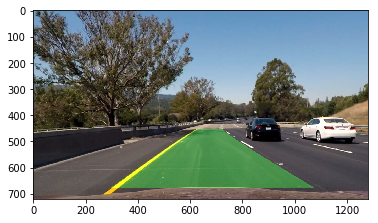

In [250]:

def warp_inv_lanes(binary_warped_image, undistorted_image, left_fitx, right_fitx, 
                   ploty, perspective_Minv, lane_offset):
    
    '''
    Gets the binary warped image, and the undistorted image with plotting indices, 
    perspective transformation matrix and offset
    Applies inverse transform, and plot region between lanes on the image
    Returns the image with lane marking filled
    '''    
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx + lane_offset, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx + lane_offset, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    binary_warped_image = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    return binary_warped_image
    
warped_inv_image = warp_inv_lanes(binary_warped, undistorted, left_fitx, 
                                  right_fitx, ploty, perspective_Minv, lane_offset)
plt.imshow(binary_warped_image)


---

### 2.7. Pipeline to Process Image ###

A pipeline to call all the functions in order to get the final image

In [221]:
def set_param_values():
    '''
    Sets the parameter values used for the line
    '''    
    margin  = 250
    p1 = [588, 455]
    p2 = [696, 455]
    p3 = [255, 680]
    p4 = [1065, 680]
    src = np.float32([p1, p2, p3, p4])
    dst = np.float32([[margin,0],[image.shape[1]-margin, 0],[margin, image.shape[0]],
                      [image.shape[1]- margin, image.shape[0]]])

    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    return margin, p1, p2, p3, p4, src, dst, xm_per_pix, ym_per_pix
    

Left Curvature(m): 1358.2439102
Right Curvature(m): 1383.8690702
Lane Offset(m): -0.05285714285714286


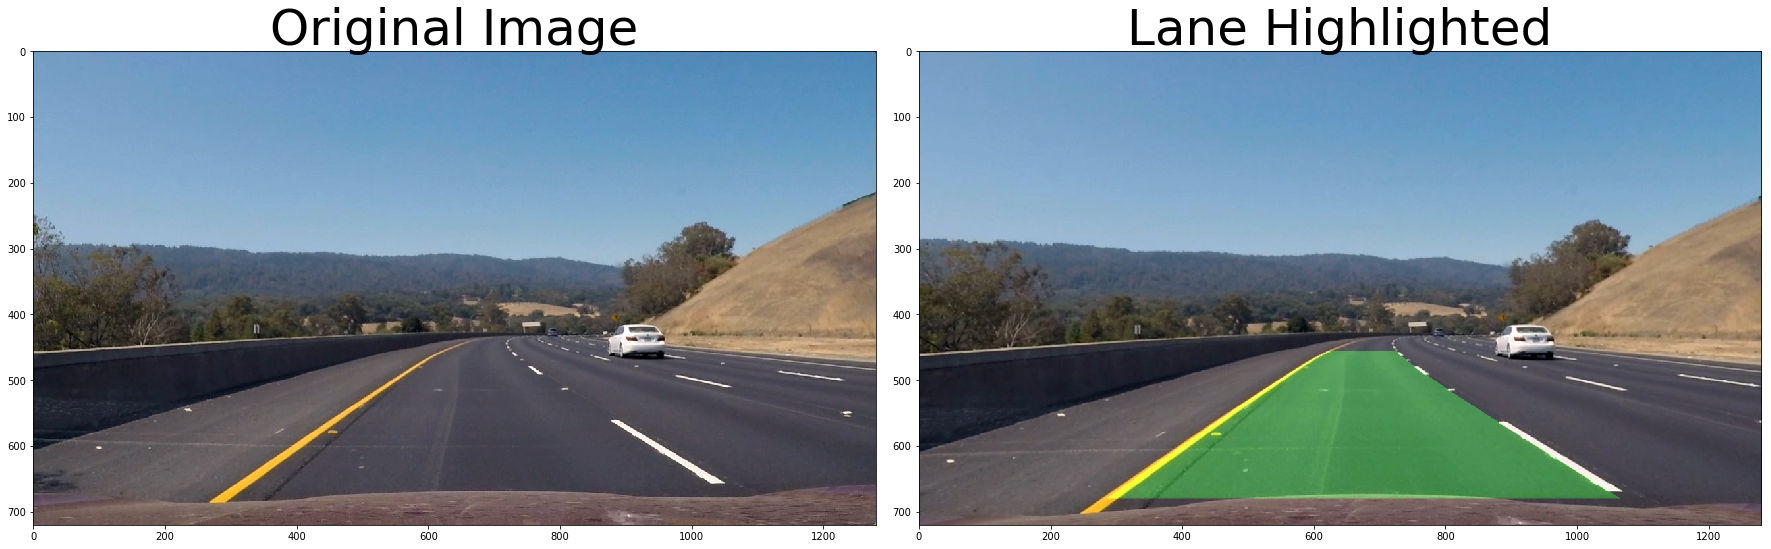

In [282]:
orig_image = mpimg.imread('test_images/test3.jpg')
#orig_image = mpimg.imread('test_images/straight_lines2.jpg')

def pipeline(orig_image):
    '''
    Pipeline to complete the entire image processing
    Starts with the original image and applies each step
    Return the final image with lane markings filled out
    Also prints radii of curvature, and offset
    '''    
    
    # Undistort the image
    undistorted_image = image_undistort(orig_image, objpoints, imgpoints)
    
    # Apply threshold to undistorted image
    threshold_image = apply_threshold(undistorted_image)
        
    # Warp image
    threshold_warped_image, perspective_M, perspective_Minv = warp_image(threshold_image, src, dst)
        
    # Get polynomial in meters for radius calculation
    polynomial_lane_image, ploty, left_fit_m, right_fit_m, left_fitx, right_fitx = fit_polynomial(threshold_warped_image, 
                                                                                              xm_per_pix, ym_per_pix)
    # Get polynomial in pixels for plotting
    polynomial_lane_image, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(threshold_warped_image)
    
    # Get the radius of curvature and offset
    left_curverad, right_curverad = measure_curvature(ploty, left_fit_m, right_fit_m)
    lane_offset, image_mid, lane_mid = calculate_offset(orig_image, lines_orig)
    
    #print(left_curverad, right_curverad)
    print("Left Curvature(m): " + str(left_curverad))
    print("Right Curvature(m): " + str(right_curverad))
    print("Lane Offset(m): " + str(lane_offset * xm_per_pix))
        
    # Get the final inverse warped image with lanes filled
    warped_inv_image = warp_inv_lanes(threshold_warped_image, undistorted_image, left_fitx, 
                                      right_fitx, ploty, perspective_Minv, lane_offset)
    
    return warped_inv_image



# Get the parameter values
margin, p1, p2, p3, p4, src, dst, xm_per_pix, ym_per_pix = set_param_values()

# Call the pipeline to process image
final_image = pipeline(orig_image)

#plt.imshow(polynomial_lane_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(final_image)
ax2.set_title('Lane Highlighted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



---

## 3. Video Processing Using Pipeline ##

Apply the pipeline to a video and save the output

In [278]:
"""
Import the libraries, and set the parameters needed for the pipeline to function
"""
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Get the parameter values
margin, p1, p2, p3, p4, src, dst, xm_per_pix, ym_per_pix = set_param_values()

In [279]:
"""
Define the input and process it by calling the pipeline
Write the output video to folder 'output_video'
"""

# Define the video names
vid_input = 'project_video.mp4'
vid_output = 'output_video/project_video.mp4'

clip1 = VideoFileClip(vid_input).subclip(0,1)
#clip1 = VideoFileClip(vid_input)
proc_clip = clip1.fl_image(pipeline)
%time proc_clip.write_videofile(vid_output, audio=False)

Left Curvature(m): -1518.12734983
Right Curvature(m): -1656.7809811
Lane Offset(m): -0.05285714285714286
Moviepy - Building video output_video/project_video.mp4.
Moviepy - Writing video output_video/project_video.mp4



t:   0%|                                                                    | 2/1260 [00:01<14:13,  1.47it/s, now=None]

Left Curvature(m): -1518.12734983
Right Curvature(m): -1656.7809811
Lane Offset(m): -0.05285714285714286


t:   0%|▏                                                                   | 3/1260 [00:02<18:02,  1.16it/s, now=None]

Left Curvature(m): -1526.17874167
Right Curvature(m): -1439.3449369
Lane Offset(m): -0.05285714285714286


t:   0%|▏                                                                   | 4/1260 [00:04<21:50,  1.04s/it, now=None]

Left Curvature(m): -1549.16181668
Right Curvature(m): -1360.80090755
Lane Offset(m): -0.05285714285714286


t:   0%|▎                                                                   | 5/1260 [00:05<23:32,  1.13s/it, now=None]

Left Curvature(m): -1515.66998667
Right Curvature(m): -1409.42590293
Lane Offset(m): -0.05285714285714286


t:   0%|▎                                                                   | 6/1260 [00:06<23:48,  1.14s/it, now=None]

Left Curvature(m): -1505.36808941
Right Curvature(m): -1421.70212132
Lane Offset(m): -0.05285714285714286


t:   1%|▍                                                                   | 7/1260 [00:07<24:37,  1.18s/it, now=None]

Left Curvature(m): -1523.34175371
Right Curvature(m): -1358.0736976
Lane Offset(m): -0.05285714285714286


t:   1%|▍                                                                   | 8/1260 [00:09<24:32,  1.18s/it, now=None]

Left Curvature(m): -1474.56962133
Right Curvature(m): -1359.21241636
Lane Offset(m): -0.05285714285714286


t:   1%|▍                                                                   | 9/1260 [00:10<24:25,  1.17s/it, now=None]

Left Curvature(m): -1478.41774532
Right Curvature(m): -1377.23107221
Lane Offset(m): -0.05285714285714286


t:   1%|▌                                                                  | 10/1260 [00:11<25:08,  1.21s/it, now=None]

Left Curvature(m): -1445.06150323
Right Curvature(m): -2159.91224607
Lane Offset(m): -0.05285714285714286


t:   1%|▌                                                                  | 11/1260 [00:12<26:15,  1.26s/it, now=None]

Left Curvature(m): -1398.03806448
Right Curvature(m): -1372.72171458
Lane Offset(m): -0.05285714285714286


t:   1%|▋                                                                  | 12/1260 [00:14<26:14,  1.26s/it, now=None]

Left Curvature(m): -1375.28996496
Right Curvature(m): -1446.0326249
Lane Offset(m): -0.05285714285714286


t:   1%|▋                                                                  | 13/1260 [00:15<25:38,  1.23s/it, now=None]

Left Curvature(m): -1375.41313491
Right Curvature(m): -1368.20332699
Lane Offset(m): -0.05285714285714286


t:   1%|▋                                                                  | 14/1260 [00:16<25:20,  1.22s/it, now=None]

Left Curvature(m): -1371.20054802
Right Curvature(m): -1516.5478027
Lane Offset(m): -0.05285714285714286


t:   1%|▊                                                                  | 15/1260 [00:17<25:43,  1.24s/it, now=None]

Left Curvature(m): -1362.93942839
Right Curvature(m): -1388.12178149
Lane Offset(m): -0.05285714285714286


t:   1%|▊                                                                  | 16/1260 [00:18<25:14,  1.22s/it, now=None]

Left Curvature(m): -1358.49731155
Right Curvature(m): -1351.82002362
Lane Offset(m): -0.05285714285714286


t:   1%|▉                                                                  | 17/1260 [00:20<25:30,  1.23s/it, now=None]

Left Curvature(m): -1367.47130925
Right Curvature(m): -1452.09113952
Lane Offset(m): -0.05285714285714286


t:   1%|▉                                                                  | 18/1260 [00:21<25:08,  1.21s/it, now=None]

Left Curvature(m): -1370.7857353
Right Curvature(m): -1353.2260689
Lane Offset(m): -0.05285714285714286


t:   2%|█                                                                  | 19/1260 [00:22<25:56,  1.25s/it, now=None]

Left Curvature(m): -1362.16543819
Right Curvature(m): -1364.49408923
Lane Offset(m): -0.05285714285714286


t:   2%|█                                                                  | 20/1260 [00:23<25:56,  1.26s/it, now=None]

Left Curvature(m): -1358.65104381
Right Curvature(m): -1366.51755396
Lane Offset(m): -0.05285714285714286


t:   2%|█                                                                  | 21/1260 [00:25<25:44,  1.25s/it, now=None]

Left Curvature(m): -1358.72960536
Right Curvature(m): -1366.05988384
Lane Offset(m): -0.05285714285714286


t:   2%|█▏                                                                 | 22/1260 [00:26<25:52,  1.25s/it, now=None]

Left Curvature(m): -1364.80920071
Right Curvature(m): -1359.86333749
Lane Offset(m): -0.05285714285714286


t:   2%|█▏                                                                 | 23/1260 [00:27<25:38,  1.24s/it, now=None]

Left Curvature(m): -1359.18495695
Right Curvature(m): -1412.25167612
Lane Offset(m): -0.05285714285714286


t:   2%|█▎                                                                 | 24/1260 [00:28<25:24,  1.23s/it, now=None]

Left Curvature(m): -1360.31685593
Right Curvature(m): -1385.15110151
Lane Offset(m): -0.05285714285714286


t:   2%|█▎                                                                 | 25/1260 [00:30<25:13,  1.23s/it, now=None]

Left Curvature(m): -1358.38267141
Right Curvature(m): -1415.7380698
Lane Offset(m): -0.05285714285714286


t:   2%|█▍                                                                 | 26/1260 [00:31<24:55,  1.21s/it, now=None]

Left Curvature(m): -1371.66172985
Right Curvature(m): -1541.36461811
Lane Offset(m): -0.05285714285714286


t:   2%|█▍                                                                 | 27/1260 [00:32<24:41,  1.20s/it, now=None]

Left Curvature(m): -1376.54432412
Right Curvature(m): -1578.20513473
Lane Offset(m): -0.05285714285714286


t:   2%|█▍                                                                 | 28/1260 [00:33<24:58,  1.22s/it, now=None]

Left Curvature(m): -1388.3394026
Right Curvature(m): -1524.31438843
Lane Offset(m): -0.05285714285714286


t:   2%|█▌                                                                 | 29/1260 [00:34<25:02,  1.22s/it, now=None]

Left Curvature(m): -1378.28815311
Right Curvature(m): -1448.06099569
Lane Offset(m): -0.05285714285714286


t:   2%|█▌                                                                 | 30/1260 [00:36<25:08,  1.23s/it, now=None]

Left Curvature(m): -1412.44374252
Right Curvature(m): -1412.83963955
Lane Offset(m): -0.05285714285714286


t:   2%|█▋                                                                 | 31/1260 [00:37<25:00,  1.22s/it, now=None]

Left Curvature(m): -1416.23688328
Right Curvature(m): -1360.82463125
Lane Offset(m): -0.05285714285714286


t:   3%|█▋                                                                 | 32/1260 [00:38<24:57,  1.22s/it, now=None]

Left Curvature(m): -1465.32066649
Right Curvature(m): -1359.32150317
Lane Offset(m): -0.05285714285714286


t:   3%|█▊                                                                 | 33/1260 [00:39<24:43,  1.21s/it, now=None]

Left Curvature(m): -1513.00493779
Right Curvature(m): -1386.31572631
Lane Offset(m): -0.05285714285714286


t:   3%|█▊                                                                 | 34/1260 [00:41<24:35,  1.20s/it, now=None]

Left Curvature(m): -1520.31651135
Right Curvature(m): -1391.61172807
Lane Offset(m): -0.05285714285714286


t:   3%|█▊                                                                 | 35/1260 [00:42<24:25,  1.20s/it, now=None]

Left Curvature(m): -1563.18601733
Right Curvature(m): -1354.79328545
Lane Offset(m): -0.05285714285714286


t:   3%|█▉                                                                 | 36/1260 [00:43<24:22,  1.19s/it, now=None]

Left Curvature(m): -1613.65995583
Right Curvature(m): -1365.2765398
Lane Offset(m): -0.05285714285714286


t:   3%|█▉                                                                 | 37/1260 [00:44<24:23,  1.20s/it, now=None]

Left Curvature(m): -1619.92099448
Right Curvature(m): -1816.09896773
Lane Offset(m): -0.05285714285714286


t:   3%|██                                                                 | 38/1260 [00:45<24:40,  1.21s/it, now=None]

Left Curvature(m): -1621.1980811
Right Curvature(m): -1609.67449595
Lane Offset(m): -0.05285714285714286


t:   3%|██                                                                 | 39/1260 [00:47<24:40,  1.21s/it, now=None]

Left Curvature(m): -1678.00205002
Right Curvature(m): -1530.91934471
Lane Offset(m): -0.05285714285714286


t:   3%|██▏                                                                | 40/1260 [00:48<24:46,  1.22s/it, now=None]

Left Curvature(m): -1716.20535134
Right Curvature(m): -1418.45490502
Lane Offset(m): -0.05285714285714286


t:   3%|██▏                                                                | 41/1260 [00:49<24:53,  1.23s/it, now=None]

Left Curvature(m): -1700.33787544
Right Curvature(m): -1391.01811388
Lane Offset(m): -0.05285714285714286


t:   3%|██▏                                                                | 42/1260 [00:50<25:12,  1.24s/it, now=None]

Left Curvature(m): -1664.658467
Right Curvature(m): -1365.42542546
Lane Offset(m): -0.05285714285714286


t:   3%|██▎                                                                | 43/1260 [00:52<25:19,  1.25s/it, now=None]

Left Curvature(m): -1631.8687042
Right Curvature(m): -1419.63585525
Lane Offset(m): -0.05285714285714286


t:   3%|██▎                                                                | 44/1260 [00:53<25:48,  1.27s/it, now=None]

Left Curvature(m): -1573.56550862
Right Curvature(m): -1455.23831952
Lane Offset(m): -0.05285714285714286


t:   4%|██▍                                                                | 45/1260 [00:54<25:54,  1.28s/it, now=None]

Left Curvature(m): -1549.62275955
Right Curvature(m): -1420.55028633
Lane Offset(m): -0.05285714285714286


t:   4%|██▍                                                                | 46/1260 [00:55<25:47,  1.28s/it, now=None]

Left Curvature(m): -1538.17858826
Right Curvature(m): -1432.44380194
Lane Offset(m): -0.05285714285714286


t:   4%|██▍                                                                | 47/1260 [00:57<25:58,  1.29s/it, now=None]

Left Curvature(m): -1499.84191702
Right Curvature(m): -1405.42051769
Lane Offset(m): -0.05285714285714286


t:   4%|██▌                                                                | 48/1260 [00:58<25:55,  1.28s/it, now=None]

Left Curvature(m): -1491.26976505
Right Curvature(m): -1352.08843134
Lane Offset(m): -0.05285714285714286


t:   4%|██▌                                                                | 49/1260 [00:59<25:59,  1.29s/it, now=None]

Left Curvature(m): -1433.95429531
Right Curvature(m): -1409.95745614
Lane Offset(m): -0.05285714285714286


t:   4%|██▋                                                                | 50/1260 [01:01<25:46,  1.28s/it, now=None]

Left Curvature(m): -1412.94688549
Right Curvature(m): -1563.5134806
Lane Offset(m): -0.05285714285714286


t:   4%|██▋                                                                | 51/1260 [01:02<25:37,  1.27s/it, now=None]

Left Curvature(m): -1389.37948904
Right Curvature(m): -1731.026948
Lane Offset(m): -0.05285714285714286


t:   4%|██▊                                                                | 52/1260 [01:03<25:23,  1.26s/it, now=None]

Left Curvature(m): -1383.53514279
Right Curvature(m): -1569.19651274
Lane Offset(m): -0.05285714285714286


t:   4%|██▊                                                                | 53/1260 [01:04<25:08,  1.25s/it, now=None]

Left Curvature(m): -1381.34270488
Right Curvature(m): -1493.40680991
Lane Offset(m): -0.05285714285714286


t:   4%|██▊                                                                | 54/1260 [01:06<24:51,  1.24s/it, now=None]

Left Curvature(m): -1366.18455584
Right Curvature(m): -1399.52418667
Lane Offset(m): -0.05285714285714286


t:   4%|██▉                                                                | 55/1260 [01:07<24:41,  1.23s/it, now=None]

Left Curvature(m): -1363.37602713
Right Curvature(m): -1356.61828681
Lane Offset(m): -0.05285714285714286


t:   4%|██▉                                                                | 56/1260 [01:08<26:53,  1.34s/it, now=None]

Left Curvature(m): -1353.84847023
Right Curvature(m): -1376.59141264
Lane Offset(m): -0.05285714285714286


t:   5%|███                                                                | 57/1260 [01:10<26:08,  1.30s/it, now=None]

Left Curvature(m): -1353.08034121
Right Curvature(m): -1393.33013268
Lane Offset(m): -0.05285714285714286


t:   5%|███                                                                | 58/1260 [01:11<26:12,  1.31s/it, now=None]

Left Curvature(m): -1353.58517256
Right Curvature(m): -1362.86962638
Lane Offset(m): -0.05285714285714286


t:   5%|███▏                                                               | 59/1260 [01:12<26:22,  1.32s/it, now=None]

Left Curvature(m): -1355.56851345
Right Curvature(m): -1361.29473844
Lane Offset(m): -0.05285714285714286


t:   5%|███▏                                                               | 60/1260 [01:13<26:06,  1.31s/it, now=None]

Left Curvature(m): -1368.17880267
Right Curvature(m): -1393.49382606
Lane Offset(m): -0.05285714285714286


t:   5%|███▏                                                               | 61/1260 [01:15<25:37,  1.28s/it, now=None]

Left Curvature(m): -1393.29100758
Right Curvature(m): -1479.68778096
Lane Offset(m): -0.05285714285714286


t:   5%|███▎                                                               | 62/1260 [01:16<25:17,  1.27s/it, now=None]

Left Curvature(m): -1397.76862846
Right Curvature(m): -1364.42494791
Lane Offset(m): -0.05285714285714286


t:   5%|███▎                                                               | 63/1260 [01:17<24:56,  1.25s/it, now=None]

Left Curvature(m): -1421.60178612
Right Curvature(m): -1341.42405247
Lane Offset(m): -0.05285714285714286


t:   5%|███▍                                                               | 64/1260 [01:18<24:44,  1.24s/it, now=None]

Left Curvature(m): -1420.32267374
Right Curvature(m): -1340.87096751
Lane Offset(m): -0.05285714285714286


t:   5%|███▍                                                               | 65/1260 [01:20<24:42,  1.24s/it, now=None]

Left Curvature(m): -1434.37193838
Right Curvature(m): -1342.49435719
Lane Offset(m): -0.05285714285714286


t:   5%|███▌                                                               | 66/1260 [01:21<24:35,  1.24s/it, now=None]

Left Curvature(m): -1402.72649385
Right Curvature(m): -1345.47365133
Lane Offset(m): -0.05285714285714286


t:   5%|███▌                                                               | 67/1260 [01:22<24:52,  1.25s/it, now=None]

Left Curvature(m): -1404.10663799
Right Curvature(m): -1347.1983628
Lane Offset(m): -0.05285714285714286


t:   5%|███▌                                                               | 68/1260 [01:23<24:45,  1.25s/it, now=None]

Left Curvature(m): -1387.52563168
Right Curvature(m): -1354.65053784
Lane Offset(m): -0.05285714285714286


t:   5%|███▋                                                               | 69/1260 [01:25<24:42,  1.25s/it, now=None]

Left Curvature(m): -1364.23566389
Right Curvature(m): -1363.51311075
Lane Offset(m): -0.05285714285714286


t:   6%|███▋                                                               | 70/1260 [01:26<24:31,  1.24s/it, now=None]

Left Curvature(m): -1366.14959221
Right Curvature(m): -1349.8420847
Lane Offset(m): -0.05285714285714286


t:   6%|███▊                                                               | 71/1260 [01:27<24:26,  1.23s/it, now=None]

Left Curvature(m): -1366.13536507
Right Curvature(m): -1353.8898424
Lane Offset(m): -0.05285714285714286


t:   6%|███▊                                                               | 72/1260 [01:28<24:30,  1.24s/it, now=None]

Left Curvature(m): -1364.67247053
Right Curvature(m): -1784.19712688
Lane Offset(m): -0.05285714285714286


t:   6%|███▉                                                               | 73/1260 [01:30<25:14,  1.28s/it, now=None]

Left Curvature(m): -1385.91351002
Right Curvature(m): -1867.1568832
Lane Offset(m): -0.05285714285714286


t:   6%|███▉                                                               | 74/1260 [01:31<25:20,  1.28s/it, now=None]

Left Curvature(m): -1377.0467746
Right Curvature(m): -1807.27723218
Lane Offset(m): -0.05285714285714286


t:   6%|███▉                                                               | 75/1260 [01:32<25:18,  1.28s/it, now=None]

Left Curvature(m): -1388.31846443
Right Curvature(m): -1606.34284768
Lane Offset(m): -0.05285714285714286


t:   6%|████                                                               | 76/1260 [01:34<25:14,  1.28s/it, now=None]

Left Curvature(m): -1376.90078127
Right Curvature(m): -1527.10190225
Lane Offset(m): -0.05285714285714286


t:   6%|████                                                               | 77/1260 [01:35<25:31,  1.29s/it, now=None]

Left Curvature(m): -1399.89573116
Right Curvature(m): -1470.31164911
Lane Offset(m): -0.05285714285714286


t:   6%|████▏                                                              | 78/1260 [01:36<25:00,  1.27s/it, now=None]

Left Curvature(m): -1438.79374611
Right Curvature(m): -1500.6227686
Lane Offset(m): -0.05285714285714286


t:   6%|████▏                                                              | 79/1260 [01:37<25:12,  1.28s/it, now=None]

Left Curvature(m): -1482.31719556
Right Curvature(m): -1419.25685677
Lane Offset(m): -0.05285714285714286


t:   6%|████▎                                                              | 80/1260 [01:39<24:45,  1.26s/it, now=None]

Left Curvature(m): -1483.12492505
Right Curvature(m): -1391.73756696
Lane Offset(m): -0.05285714285714286


t:   6%|████▎                                                              | 81/1260 [01:40<24:30,  1.25s/it, now=None]

Left Curvature(m): -1492.54620091
Right Curvature(m): -1363.24409009
Lane Offset(m): -0.05285714285714286


t:   7%|████▎                                                              | 82/1260 [01:41<24:48,  1.26s/it, now=None]

Left Curvature(m): -1451.5121309
Right Curvature(m): -1361.06836031
Lane Offset(m): -0.05285714285714286


t:   7%|████▍                                                              | 83/1260 [01:42<24:29,  1.25s/it, now=None]

Left Curvature(m): -1437.18888806
Right Curvature(m): -1368.415625
Lane Offset(m): -0.05285714285714286


t:   7%|████▍                                                              | 84/1260 [01:44<24:14,  1.24s/it, now=None]

Left Curvature(m): -1398.75617139
Right Curvature(m): -1361.80782765
Lane Offset(m): -0.05285714285714286


t:   7%|████▌                                                              | 85/1260 [01:45<23:58,  1.22s/it, now=None]

Left Curvature(m): -1413.51545445
Right Curvature(m): -1366.61829002
Lane Offset(m): -0.05285714285714286


t:   7%|████▌                                                              | 86/1260 [01:46<23:49,  1.22s/it, now=None]

Left Curvature(m): -1378.80863127
Right Curvature(m): -1401.26173998
Lane Offset(m): -0.05285714285714286


t:   7%|████▋                                                              | 87/1260 [01:47<23:40,  1.21s/it, now=None]

Left Curvature(m): -1370.13575689
Right Curvature(m): -1546.35038833
Lane Offset(m): -0.05285714285714286


t:   7%|████▋                                                              | 88/1260 [01:48<23:40,  1.21s/it, now=None]

Left Curvature(m): -1387.49591152
Right Curvature(m): -1565.44361473
Lane Offset(m): -0.05285714285714286


t:   7%|████▋                                                              | 89/1260 [01:50<24:01,  1.23s/it, now=None]

Left Curvature(m): -1436.98152612
Right Curvature(m): -1434.08193582
Lane Offset(m): -0.05285714285714286


t:   7%|████▊                                                              | 90/1260 [01:51<24:10,  1.24s/it, now=None]

Left Curvature(m): -1456.04654692
Right Curvature(m): -1357.88985064
Lane Offset(m): -0.05285714285714286


t:   7%|████▊                                                              | 91/1260 [01:52<24:17,  1.25s/it, now=None]

Left Curvature(m): -1491.16808533
Right Curvature(m): -1351.73584123
Lane Offset(m): -0.05285714285714286


t:   7%|████▉                                                              | 92/1260 [01:53<24:21,  1.25s/it, now=None]

Left Curvature(m): -1495.84127892
Right Curvature(m): -1357.99139593
Lane Offset(m): -0.05285714285714286


t:   7%|████▉                                                              | 93/1260 [01:55<24:10,  1.24s/it, now=None]

Left Curvature(m): -1467.54130453
Right Curvature(m): -1358.70710866
Lane Offset(m): -0.05285714285714286


t:   7%|████▉                                                              | 94/1260 [01:56<23:59,  1.23s/it, now=None]

Left Curvature(m): -1452.58985117
Right Curvature(m): -1379.87055054
Lane Offset(m): -0.05285714285714286


t:   8%|█████                                                              | 95/1260 [01:57<23:51,  1.23s/it, now=None]

Left Curvature(m): -1472.31883234
Right Curvature(m): -1369.19021089
Lane Offset(m): -0.05285714285714286


t:   8%|█████                                                              | 96/1260 [01:58<23:52,  1.23s/it, now=None]

Left Curvature(m): -1468.99684082
Right Curvature(m): -1360.6998825
Lane Offset(m): -0.05285714285714286


t:   8%|█████▏                                                             | 97/1260 [01:59<23:45,  1.23s/it, now=None]

Left Curvature(m): -1453.7605286
Right Curvature(m): -1398.82641954
Lane Offset(m): -0.05285714285714286


t:   8%|█████▏                                                             | 98/1260 [02:01<23:32,  1.22s/it, now=None]

Left Curvature(m): -1441.59514429
Right Curvature(m): -1537.32753277
Lane Offset(m): -0.05285714285714286


t:   8%|█████▎                                                             | 99/1260 [02:02<23:34,  1.22s/it, now=None]

Left Curvature(m): -1434.36238746
Right Curvature(m): -1698.4201344
Lane Offset(m): -0.05285714285714286


t:   8%|█████▏                                                            | 100/1260 [02:03<23:31,  1.22s/it, now=None]

Left Curvature(m): -1425.78011955
Right Curvature(m): -1658.37875027
Lane Offset(m): -0.05285714285714286


t:   8%|█████▎                                                            | 101/1260 [02:04<23:25,  1.21s/it, now=None]

Left Curvature(m): -1419.55918903
Right Curvature(m): -1592.53091808
Lane Offset(m): -0.05285714285714286


t:   8%|█████▎                                                            | 102/1260 [02:05<23:16,  1.21s/it, now=None]

Left Curvature(m): -1451.3044518
Right Curvature(m): -1521.36295778
Lane Offset(m): -0.05285714285714286


t:   8%|█████▍                                                            | 103/1260 [02:07<23:28,  1.22s/it, now=None]

Left Curvature(m): -1455.77783275
Right Curvature(m): -1434.35070472
Lane Offset(m): -0.05285714285714286


t:   8%|█████▍                                                            | 104/1260 [02:08<23:23,  1.21s/it, now=None]

Left Curvature(m): -1456.00170939
Right Curvature(m): -1396.03556782
Lane Offset(m): -0.05285714285714286


t:   8%|█████▌                                                            | 105/1260 [02:09<23:17,  1.21s/it, now=None]

Left Curvature(m): -1455.08049129
Right Curvature(m): -1378.92612654
Lane Offset(m): -0.05285714285714286


t:   8%|█████▌                                                            | 106/1260 [02:10<23:13,  1.21s/it, now=None]

Left Curvature(m): -1425.01633219
Right Curvature(m): -1366.84080432
Lane Offset(m): -0.05285714285714286


t:   8%|█████▌                                                            | 107/1260 [02:12<23:47,  1.24s/it, now=None]

Left Curvature(m): -1433.69832601
Right Curvature(m): -1366.71107686
Lane Offset(m): -0.05285714285714286


t:   9%|█████▋                                                            | 108/1260 [02:13<23:58,  1.25s/it, now=None]

Left Curvature(m): -1420.74228008
Right Curvature(m): -1376.75707112
Lane Offset(m): -0.05285714285714286


t:   9%|█████▋                                                            | 109/1260 [02:14<24:27,  1.28s/it, now=None]

Left Curvature(m): -1437.11213354
Right Curvature(m): -1492.3507659
Lane Offset(m): -0.05285714285714286


t:   9%|█████▊                                                            | 110/1260 [02:15<24:03,  1.26s/it, now=None]

Left Curvature(m): -1446.29165143
Right Curvature(m): -1412.39377743
Lane Offset(m): -0.05285714285714286


t:   9%|█████▊                                                            | 111/1260 [02:17<23:49,  1.24s/it, now=None]

Left Curvature(m): -1470.15453175
Right Curvature(m): -1389.98572923
Lane Offset(m): -0.05285714285714286


t:   9%|█████▊                                                            | 112/1260 [02:18<23:32,  1.23s/it, now=None]

Left Curvature(m): -1470.59042007
Right Curvature(m): -1622.63296262
Lane Offset(m): -0.05285714285714286


t:   9%|█████▉                                                            | 113/1260 [02:19<23:19,  1.22s/it, now=None]

Left Curvature(m): -1450.3276981
Right Curvature(m): -1561.27141927
Lane Offset(m): -0.05285714285714286


t:   9%|█████▉                                                            | 114/1260 [02:20<23:43,  1.24s/it, now=None]

Left Curvature(m): -1497.25494313
Right Curvature(m): -1695.29479933
Lane Offset(m): -0.05285714285714286


t:   9%|██████                                                            | 115/1260 [02:22<23:42,  1.24s/it, now=None]

Left Curvature(m): -1479.93698003
Right Curvature(m): -1623.20252417
Lane Offset(m): -0.05285714285714286


t:   9%|██████                                                            | 116/1260 [02:23<23:29,  1.23s/it, now=None]

Left Curvature(m): -1527.36714692
Right Curvature(m): -1531.22823476
Lane Offset(m): -0.05285714285714286


t:   9%|██████▏                                                           | 117/1260 [02:24<23:17,  1.22s/it, now=None]

Left Curvature(m): -1524.41829545
Right Curvature(m): -1450.78059795
Lane Offset(m): -0.05285714285714286


t:   9%|██████▏                                                           | 118/1260 [02:25<23:19,  1.23s/it, now=None]

Left Curvature(m): -1539.45377477
Right Curvature(m): -1451.18290036
Lane Offset(m): -0.05285714285714286


t:   9%|██████▏                                                           | 119/1260 [02:27<23:28,  1.23s/it, now=None]

Left Curvature(m): -1526.689341
Right Curvature(m): -1471.09950654
Lane Offset(m): -0.05285714285714286


t:  10%|██████▎                                                           | 120/1260 [02:28<24:03,  1.27s/it, now=None]

Left Curvature(m): -1510.56848284
Right Curvature(m): -1521.71160201
Lane Offset(m): -0.05285714285714286


t:  10%|██████▎                                                           | 121/1260 [02:29<23:43,  1.25s/it, now=None]

Left Curvature(m): -1559.22585305
Right Curvature(m): -1482.26878433
Lane Offset(m): -0.05285714285714286


t:  10%|██████▍                                                           | 122/1260 [02:30<23:29,  1.24s/it, now=None]

Left Curvature(m): -1554.24694294
Right Curvature(m): -1403.70528056
Lane Offset(m): -0.05285714285714286


t:  10%|██████▍                                                           | 123/1260 [02:32<23:49,  1.26s/it, now=None]

Left Curvature(m): -1569.86557911
Right Curvature(m): -1865.04527189
Lane Offset(m): -0.05285714285714286


t:  10%|██████▍                                                           | 124/1260 [02:33<23:37,  1.25s/it, now=None]

Left Curvature(m): -1587.34111093
Right Curvature(m): -1768.35445833
Lane Offset(m): -0.05285714285714286


t:  10%|██████▌                                                           | 125/1260 [02:34<23:32,  1.24s/it, now=None]

Left Curvature(m): -1571.56406426
Right Curvature(m): -1552.21921927
Lane Offset(m): -0.05285714285714286


t:  10%|██████▌                                                           | 126/1260 [02:35<23:35,  1.25s/it, now=None]

Left Curvature(m): -1557.62200663
Right Curvature(m): -1568.01708232
Lane Offset(m): -0.05285714285714286


t:  10%|██████▋                                                           | 127/1260 [02:37<23:53,  1.27s/it, now=None]

Left Curvature(m): -1534.84264137
Right Curvature(m): -1606.83637654
Lane Offset(m): -0.05285714285714286


t:  10%|██████▋                                                           | 128/1260 [02:38<23:41,  1.26s/it, now=None]

Left Curvature(m): -1556.27636581
Right Curvature(m): -1420.30097633
Lane Offset(m): -0.05285714285714286


t:  10%|██████▊                                                           | 129/1260 [02:39<23:23,  1.24s/it, now=None]

Left Curvature(m): -1527.7493903
Right Curvature(m): -1413.83030378
Lane Offset(m): -0.05285714285714286


t:  10%|██████▊                                                           | 130/1260 [02:40<23:28,  1.25s/it, now=None]

Left Curvature(m): -1541.71900699
Right Curvature(m): -1479.89772246
Lane Offset(m): -0.05285714285714286


t:  10%|██████▊                                                           | 131/1260 [02:42<23:41,  1.26s/it, now=None]

Left Curvature(m): -1490.40325335
Right Curvature(m): -1461.06344138
Lane Offset(m): -0.05285714285714286


t:  10%|██████▉                                                           | 132/1260 [02:43<23:37,  1.26s/it, now=None]

Left Curvature(m): -1470.03809198
Right Curvature(m): -1452.26322119
Lane Offset(m): -0.05285714285714286


t:  11%|██████▉                                                           | 133/1260 [02:44<23:27,  1.25s/it, now=None]

Left Curvature(m): -1480.78584821
Right Curvature(m): -1420.59096592
Lane Offset(m): -0.05285714285714286


t:  11%|███████                                                           | 134/1260 [02:45<23:38,  1.26s/it, now=None]

Left Curvature(m): -1461.12806525
Right Curvature(m): -1409.45000605
Lane Offset(m): -0.05285714285714286


t:  11%|███████                                                           | 135/1260 [02:47<23:33,  1.26s/it, now=None]

Left Curvature(m): -1422.34696239
Right Curvature(m): -1693.89491754
Lane Offset(m): -0.05285714285714286


t:  11%|███████                                                           | 136/1260 [02:48<23:21,  1.25s/it, now=None]

Left Curvature(m): -1446.97083937
Right Curvature(m): -1672.40472194
Lane Offset(m): -0.05285714285714286


t:  11%|███████▏                                                          | 137/1260 [02:49<23:14,  1.24s/it, now=None]

Left Curvature(m): -1426.2480795
Right Curvature(m): -1594.69786206
Lane Offset(m): -0.05285714285714286


t:  11%|███████▏                                                          | 138/1260 [02:50<23:01,  1.23s/it, now=None]

Left Curvature(m): -1414.32385131
Right Curvature(m): -1476.14098522
Lane Offset(m): -0.05285714285714286


t:  11%|███████▎                                                          | 139/1260 [02:52<23:00,  1.23s/it, now=None]

Left Curvature(m): -1405.09314701
Right Curvature(m): -1433.02898931
Lane Offset(m): -0.05285714285714286


t:  11%|███████▎                                                          | 140/1260 [02:53<22:52,  1.23s/it, now=None]

Left Curvature(m): -1384.26471919
Right Curvature(m): -1382.59190092
Lane Offset(m): -0.05285714285714286


t:  11%|███████▍                                                          | 141/1260 [02:54<23:18,  1.25s/it, now=None]

Left Curvature(m): -1367.8899224
Right Curvature(m): -1361.80307463
Lane Offset(m): -0.05285714285714286


t:  11%|███████▍                                                          | 142/1260 [02:55<23:14,  1.25s/it, now=None]

Left Curvature(m): -1375.89024825
Right Curvature(m): -1373.56698016
Lane Offset(m): -0.05285714285714286


t:  11%|███████▍                                                          | 143/1260 [02:57<23:11,  1.25s/it, now=None]

Left Curvature(m): -1368.98642678
Right Curvature(m): -1413.78801326
Lane Offset(m): -0.05285714285714286


t:  11%|███████▌                                                          | 144/1260 [02:58<23:03,  1.24s/it, now=None]

Left Curvature(m): -1367.77639811
Right Curvature(m): -1355.7962631
Lane Offset(m): -0.05285714285714286


t:  12%|███████▌                                                          | 145/1260 [02:59<22:51,  1.23s/it, now=None]

Left Curvature(m): -1368.19446906
Right Curvature(m): -1359.73896334
Lane Offset(m): -0.05285714285714286


t:  12%|███████▋                                                          | 146/1260 [03:00<22:42,  1.22s/it, now=None]

Left Curvature(m): -1367.875782
Right Curvature(m): -1360.05570269
Lane Offset(m): -0.05285714285714286


t:  12%|███████▋                                                          | 147/1260 [03:01<22:40,  1.22s/it, now=None]

Left Curvature(m): -1371.09677511
Right Curvature(m): -1356.2456181
Lane Offset(m): -0.05285714285714286


t:  12%|███████▊                                                          | 148/1260 [03:03<22:44,  1.23s/it, now=None]

Left Curvature(m): -1366.82547105
Right Curvature(m): -1415.16394342
Lane Offset(m): -0.05285714285714286


t:  12%|███████▊                                                          | 149/1260 [03:04<22:34,  1.22s/it, now=None]

Left Curvature(m): -1388.39406154
Right Curvature(m): -1658.21375465
Lane Offset(m): -0.05285714285714286


t:  12%|███████▊                                                          | 150/1260 [03:05<22:27,  1.21s/it, now=None]

Left Curvature(m): -1392.401193
Right Curvature(m): -1515.47897252
Lane Offset(m): -0.05285714285714286


t:  12%|███████▉                                                          | 151/1260 [03:06<22:35,  1.22s/it, now=None]

Left Curvature(m): -1389.54850768
Right Curvature(m): -1468.48928923
Lane Offset(m): -0.05285714285714286


t:  12%|███████▉                                                          | 152/1260 [03:08<22:49,  1.24s/it, now=None]

Left Curvature(m): -1384.58443733
Right Curvature(m): -1419.72003637
Lane Offset(m): -0.05285714285714286


t:  12%|████████                                                          | 153/1260 [03:09<22:42,  1.23s/it, now=None]

Left Curvature(m): -1370.14836459
Right Curvature(m): -1384.87407143
Lane Offset(m): -0.05285714285714286


t:  12%|████████                                                          | 154/1260 [03:10<22:34,  1.22s/it, now=None]

Left Curvature(m): -1380.04053668
Right Curvature(m): -1360.30664095
Lane Offset(m): -0.05285714285714286


t:  12%|████████                                                          | 155/1260 [03:11<23:06,  1.25s/it, now=None]

Left Curvature(m): -1376.24780322
Right Curvature(m): -1358.40732201
Lane Offset(m): -0.05285714285714286


t:  12%|████████▏                                                         | 156/1260 [03:13<23:15,  1.26s/it, now=None]

Left Curvature(m): -1375.55600926
Right Curvature(m): -1365.58128729
Lane Offset(m): -0.05285714285714286


t:  12%|████████▏                                                         | 157/1260 [03:14<23:01,  1.25s/it, now=None]

Left Curvature(m): -1374.98770577
Right Curvature(m): -1364.85787201
Lane Offset(m): -0.05285714285714286


t:  13%|████████▎                                                         | 158/1260 [03:15<23:11,  1.26s/it, now=None]

Left Curvature(m): -1371.90373069
Right Curvature(m): -1358.71940496
Lane Offset(m): -0.05285714285714286


t:  13%|████████▎                                                         | 159/1260 [03:16<23:42,  1.29s/it, now=None]

Left Curvature(m): -1402.15917064
Right Curvature(m): -1356.48109305
Lane Offset(m): -0.05285714285714286


t:  13%|████████▍                                                         | 160/1260 [03:18<23:38,  1.29s/it, now=None]

Left Curvature(m): -1390.45194688
Right Curvature(m): -1376.27669973
Lane Offset(m): -0.05285714285714286


t:  13%|████████▍                                                         | 161/1260 [03:19<23:26,  1.28s/it, now=None]

Left Curvature(m): -1431.93867565
Right Curvature(m): -1594.21660571
Lane Offset(m): -0.05285714285714286


t:  13%|████████▍                                                         | 162/1260 [03:20<23:12,  1.27s/it, now=None]

Left Curvature(m): -1431.77815138
Right Curvature(m): -1558.87008378
Lane Offset(m): -0.05285714285714286


t:  13%|████████▌                                                         | 163/1260 [03:21<23:13,  1.27s/it, now=None]

Left Curvature(m): -1430.49767477
Right Curvature(m): -1512.50662288
Lane Offset(m): -0.05285714285714286


t:  13%|████████▌                                                         | 164/1260 [03:23<23:08,  1.27s/it, now=None]

Left Curvature(m): -1453.63122417
Right Curvature(m): -1443.99745164
Lane Offset(m): -0.05285714285714286


t:  13%|████████▋                                                         | 165/1260 [03:24<22:50,  1.25s/it, now=None]

Left Curvature(m): -1437.57905525
Right Curvature(m): -1389.2800998
Lane Offset(m): -0.05285714285714286


t:  13%|████████▋                                                         | 166/1260 [03:25<23:21,  1.28s/it, now=None]

Left Curvature(m): -1431.7818224
Right Curvature(m): -1352.7305093
Lane Offset(m): -0.05285714285714286


t:  13%|████████▋                                                         | 167/1260 [03:27<23:27,  1.29s/it, now=None]

Left Curvature(m): -1422.54979804
Right Curvature(m): -1352.39182343
Lane Offset(m): -0.05285714285714286


t:  13%|████████▊                                                         | 168/1260 [03:28<23:39,  1.30s/it, now=None]

Left Curvature(m): -1412.60120352
Right Curvature(m): -1486.53697284
Lane Offset(m): -0.05285714285714286


t:  13%|████████▊                                                         | 169/1260 [03:29<23:24,  1.29s/it, now=None]

Left Curvature(m): -1377.59129035
Right Curvature(m): -1433.32366123
Lane Offset(m): -0.05285714285714286


t:  13%|████████▉                                                         | 170/1260 [03:30<23:09,  1.28s/it, now=None]

Left Curvature(m): -1370.3831804
Right Curvature(m): -1467.56020732
Lane Offset(m): -0.05285714285714286


t:  14%|████████▉                                                         | 171/1260 [03:32<23:00,  1.27s/it, now=None]

Left Curvature(m): -1361.32265769
Right Curvature(m): -1474.55079366
Lane Offset(m): -0.05285714285714286


t:  14%|█████████                                                         | 172/1260 [03:33<23:03,  1.27s/it, now=None]

Left Curvature(m): -1360.56532217
Right Curvature(m): -1812.33243907
Lane Offset(m): -0.05285714285714286


t:  14%|█████████                                                         | 173/1260 [03:34<22:43,  1.25s/it, now=None]

Left Curvature(m): -1359.90945731
Right Curvature(m): -1822.94507705
Lane Offset(m): -0.05285714285714286


t:  14%|█████████                                                         | 174/1260 [03:35<22:35,  1.25s/it, now=None]

Left Curvature(m): -1379.11901658
Right Curvature(m): -2382.49413743
Lane Offset(m): -0.05285714285714286


t:  14%|█████████▏                                                        | 175/1260 [03:37<22:26,  1.24s/it, now=None]

Left Curvature(m): -1399.04206021
Right Curvature(m): -1926.77830555
Lane Offset(m): -0.05285714285714286


t:  14%|█████████▏                                                        | 176/1260 [03:38<22:35,  1.25s/it, now=None]

Left Curvature(m): -1446.54058117
Right Curvature(m): -1905.88466942
Lane Offset(m): -0.05285714285714286


t:  14%|█████████▎                                                        | 177/1260 [03:39<22:37,  1.25s/it, now=None]

Left Curvature(m): -1466.90291041
Right Curvature(m): -1804.54275039
Lane Offset(m): -0.05285714285714286


t:  14%|█████████▎                                                        | 178/1260 [03:40<22:38,  1.26s/it, now=None]

Left Curvature(m): -1430.80025118
Right Curvature(m): -1745.70029853
Lane Offset(m): -0.05285714285714286


t:  14%|█████████▍                                                        | 179/1260 [03:42<22:33,  1.25s/it, now=None]

Left Curvature(m): -1430.43655605
Right Curvature(m): -1725.43229049
Lane Offset(m): -0.05285714285714286


t:  14%|█████████▍                                                        | 180/1260 [03:43<22:25,  1.25s/it, now=None]

Left Curvature(m): -1445.51274228
Right Curvature(m): -1721.35116401
Lane Offset(m): -0.05285714285714286


t:  14%|█████████▍                                                        | 181/1260 [03:44<22:33,  1.25s/it, now=None]

Left Curvature(m): -1473.49966567
Right Curvature(m): -1716.95399693
Lane Offset(m): -0.05285714285714286


t:  14%|█████████▌                                                        | 182/1260 [03:45<22:44,  1.27s/it, now=None]

Left Curvature(m): -1513.42832323
Right Curvature(m): -1718.70039188
Lane Offset(m): -0.05285714285714286


t:  15%|█████████▌                                                        | 183/1260 [03:47<22:43,  1.27s/it, now=None]

Left Curvature(m): -1518.36750248
Right Curvature(m): -1649.6350762
Lane Offset(m): -0.05285714285714286


t:  15%|█████████▋                                                        | 184/1260 [03:48<22:35,  1.26s/it, now=None]

Left Curvature(m): -1582.07183984
Right Curvature(m): -1416.25819764
Lane Offset(m): -0.05285714285714286


t:  15%|█████████▋                                                        | 185/1260 [03:49<22:36,  1.26s/it, now=None]

Left Curvature(m): -1640.84713004
Right Curvature(m): -1908.18953412
Lane Offset(m): -0.05285714285714286


t:  15%|█████████▋                                                        | 186/1260 [03:51<22:34,  1.26s/it, now=None]

Left Curvature(m): -1690.68986873
Right Curvature(m): -1566.32825734
Lane Offset(m): -0.05285714285714286


t:  15%|█████████▊                                                        | 187/1260 [03:52<22:36,  1.26s/it, now=None]

Left Curvature(m): -1823.0276386
Right Curvature(m): -1508.56013061
Lane Offset(m): -0.05285714285714286


t:  15%|█████████▊                                                        | 188/1260 [03:53<22:34,  1.26s/it, now=None]

Left Curvature(m): -1821.97790202
Right Curvature(m): -1465.54447296
Lane Offset(m): -0.05285714285714286


t:  15%|█████████▉                                                        | 189/1260 [03:54<22:12,  1.24s/it, now=None]

Left Curvature(m): -1817.46658106
Right Curvature(m): -1568.45409833
Lane Offset(m): -0.05285714285714286


t:  15%|█████████▉                                                        | 190/1260 [03:56<22:13,  1.25s/it, now=None]

Left Curvature(m): -1783.73689909
Right Curvature(m): -1605.88590244
Lane Offset(m): -0.05285714285714286


t:  15%|██████████                                                        | 191/1260 [03:57<22:02,  1.24s/it, now=None]

Left Curvature(m): -1718.71157258
Right Curvature(m): -1599.00204828
Lane Offset(m): -0.05285714285714286


t:  15%|██████████                                                        | 192/1260 [03:58<21:57,  1.23s/it, now=None]

Left Curvature(m): -1733.37493759
Right Curvature(m): -1530.31947695
Lane Offset(m): -0.05285714285714286


t:  15%|██████████                                                        | 193/1260 [03:59<21:46,  1.22s/it, now=None]

Left Curvature(m): -1635.21768631
Right Curvature(m): -1461.90537289
Lane Offset(m): -0.05285714285714286


t:  15%|██████████▏                                                       | 194/1260 [04:00<21:37,  1.22s/it, now=None]

Left Curvature(m): -1636.72959142
Right Curvature(m): -1660.77750075
Lane Offset(m): -0.05285714285714286


t:  15%|██████████▏                                                       | 195/1260 [04:02<21:47,  1.23s/it, now=None]

Left Curvature(m): -1618.3854675
Right Curvature(m): -1712.89124694
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▎                                                       | 196/1260 [04:03<21:44,  1.23s/it, now=None]

Left Curvature(m): -1582.32283566
Right Curvature(m): -1746.11472796
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▎                                                       | 197/1260 [04:04<21:41,  1.22s/it, now=None]

Left Curvature(m): -1479.34550124
Right Curvature(m): -1873.47021151
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▎                                                       | 198/1260 [04:05<21:41,  1.23s/it, now=None]

Left Curvature(m): -1440.44196934
Right Curvature(m): -1385.29501572
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▍                                                       | 199/1260 [04:07<21:48,  1.23s/it, now=None]

Left Curvature(m): -1387.98956317
Right Curvature(m): -1365.50315114
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▍                                                       | 200/1260 [04:08<22:03,  1.25s/it, now=None]

Left Curvature(m): -1364.23786883
Right Curvature(m): -1363.54426028
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▌                                                       | 201/1260 [04:09<21:57,  1.24s/it, now=None]

Left Curvature(m): -1373.35469959
Right Curvature(m): -1399.71280644
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▌                                                       | 202/1260 [04:10<22:02,  1.25s/it, now=None]

Left Curvature(m): -1369.24899428
Right Curvature(m): -1547.38631879
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▋                                                       | 203/1260 [04:12<22:31,  1.28s/it, now=None]

Left Curvature(m): -1381.75985514
Right Curvature(m): -1504.52996252
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▋                                                       | 204/1260 [04:13<22:44,  1.29s/it, now=None]

Left Curvature(m): -1428.27510488
Right Curvature(m): -1468.8759922
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▋                                                       | 205/1260 [04:14<22:16,  1.27s/it, now=None]

Left Curvature(m): -1421.51713813
Right Curvature(m): -1412.15470854
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▊                                                       | 206/1260 [04:15<22:07,  1.26s/it, now=None]

Left Curvature(m): -1433.75589042
Right Curvature(m): -1397.49450656
Lane Offset(m): -0.05285714285714286


t:  16%|██████████▊                                                       | 207/1260 [04:17<21:54,  1.25s/it, now=None]

Left Curvature(m): -1437.03051519
Right Curvature(m): -1486.87597289
Lane Offset(m): -0.05285714285714286


t:  17%|██████████▉                                                       | 208/1260 [04:18<21:49,  1.24s/it, now=None]

Left Curvature(m): -1508.65293554
Right Curvature(m): -1417.0985726
Lane Offset(m): -0.05285714285714286


t:  17%|██████████▉                                                       | 209/1260 [04:19<22:02,  1.26s/it, now=None]

Left Curvature(m): -1534.50470252
Right Curvature(m): -1819.50211009
Lane Offset(m): -0.05285714285714286


t:  17%|███████████                                                       | 210/1260 [04:20<21:53,  1.25s/it, now=None]

Left Curvature(m): -1519.83409149
Right Curvature(m): -1779.46888926
Lane Offset(m): -0.05285714285714286


t:  17%|███████████                                                       | 211/1260 [04:22<23:34,  1.35s/it, now=None]

Left Curvature(m): -1513.53221107
Right Curvature(m): -1750.20836677
Lane Offset(m): -0.05285714285714286


t:  17%|███████████                                                       | 212/1260 [04:23<22:57,  1.31s/it, now=None]

Left Curvature(m): -1490.05609504
Right Curvature(m): -1661.55592879
Lane Offset(m): -0.05285714285714286


t:  17%|███████████▏                                                      | 213/1260 [04:25<22:47,  1.31s/it, now=None]

Left Curvature(m): -1517.88282301
Right Curvature(m): -1609.91730969
Lane Offset(m): -0.05285714285714286


t:  17%|███████████▏                                                      | 214/1260 [04:26<22:40,  1.30s/it, now=None]

Left Curvature(m): -1506.8186835
Right Curvature(m): -1450.24951528
Lane Offset(m): -0.05285714285714286


t:  17%|███████████▎                                                      | 215/1260 [04:27<22:49,  1.31s/it, now=None]

Left Curvature(m): -1539.41516776
Right Curvature(m): -1398.14892468
Lane Offset(m): -0.05285714285714286


t:  17%|███████████▎                                                      | 216/1260 [04:28<22:14,  1.28s/it, now=None]

Left Curvature(m): -1536.79304544
Right Curvature(m): -1355.77772934
Lane Offset(m): -0.05285714285714286


t:  17%|███████████▎                                                      | 217/1260 [04:30<22:32,  1.30s/it, now=None]

Left Curvature(m): -1526.1325865
Right Curvature(m): -1346.41656449
Lane Offset(m): -0.05285714285714286


t:  17%|███████████▍                                                      | 218/1260 [04:31<22:12,  1.28s/it, now=None]

Left Curvature(m): -1509.41269205
Right Curvature(m): -1347.22666784
Lane Offset(m): -0.05285714285714286


t:  17%|███████████▍                                                      | 219/1260 [04:32<22:06,  1.27s/it, now=None]

Left Curvature(m): -1456.8073422
Right Curvature(m): -1351.3724636
Lane Offset(m): -0.05285714285714286


t:  17%|███████████▌                                                      | 220/1260 [04:33<21:57,  1.27s/it, now=None]

Left Curvature(m): -1471.4823126
Right Curvature(m): -1346.85160508
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▌                                                      | 221/1260 [04:35<22:42,  1.31s/it, now=None]

Left Curvature(m): -1437.17443538
Right Curvature(m): -1355.2207939
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▋                                                      | 222/1260 [04:36<21:58,  1.27s/it, now=None]

Left Curvature(m): -1432.09245384
Right Curvature(m): -1407.43203073
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▋                                                      | 223/1260 [04:37<21:53,  1.27s/it, now=None]

Left Curvature(m): -1415.03942559
Right Curvature(m): -1352.53141846
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▋                                                      | 224/1260 [04:39<22:00,  1.27s/it, now=None]

Left Curvature(m): -1397.33295251
Right Curvature(m): -1549.12523308
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▊                                                      | 225/1260 [04:40<21:39,  1.26s/it, now=None]

Left Curvature(m): -1407.09373503
Right Curvature(m): -1434.95896016
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▊                                                      | 226/1260 [04:41<21:16,  1.23s/it, now=None]

Left Curvature(m): -1405.81801202
Right Curvature(m): -1417.23954425
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▉                                                      | 227/1260 [04:42<21:07,  1.23s/it, now=None]

Left Curvature(m): -1402.49653488
Right Curvature(m): -1351.58535307
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▉                                                      | 228/1260 [04:43<20:58,  1.22s/it, now=None]

Left Curvature(m): -1389.55971281
Right Curvature(m): -1351.23068325
Lane Offset(m): -0.05285714285714286


t:  18%|███████████▉                                                      | 229/1260 [04:45<20:46,  1.21s/it, now=None]

Left Curvature(m): -1362.97095574
Right Curvature(m): -1352.7915393
Lane Offset(m): -0.05285714285714286


t:  18%|████████████                                                      | 230/1260 [04:46<20:34,  1.20s/it, now=None]

Left Curvature(m): -1363.14577173
Right Curvature(m): -1357.82596869
Lane Offset(m): -0.05285714285714286


t:  18%|████████████                                                      | 231/1260 [04:47<20:33,  1.20s/it, now=None]

Left Curvature(m): -1354.26978334
Right Curvature(m): -1369.9169416
Lane Offset(m): -0.05285714285714286


t:  18%|████████████▏                                                     | 232/1260 [04:48<20:41,  1.21s/it, now=None]

Left Curvature(m): -1356.41398081
Right Curvature(m): -1435.26306139
Lane Offset(m): -0.05285714285714286


t:  18%|████████████▏                                                     | 233/1260 [04:49<20:38,  1.21s/it, now=None]

Left Curvature(m): -1353.47623495
Right Curvature(m): -1437.37696927
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▎                                                     | 234/1260 [04:51<20:37,  1.21s/it, now=None]

Left Curvature(m): -1354.37186413
Right Curvature(m): -1373.92482132
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▎                                                     | 235/1260 [04:52<20:29,  1.20s/it, now=None]

Left Curvature(m): -1356.47326335
Right Curvature(m): -1545.95474562
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▎                                                     | 236/1260 [04:53<20:24,  1.20s/it, now=None]

Left Curvature(m): -1360.65658515
Right Curvature(m): -1828.49073419
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▍                                                     | 237/1260 [04:54<20:16,  1.19s/it, now=None]

Left Curvature(m): -1375.30481593
Right Curvature(m): -1589.06127937
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▍                                                     | 238/1260 [04:55<20:12,  1.19s/it, now=None]

Left Curvature(m): -1394.59467256
Right Curvature(m): -1685.9596006
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▌                                                     | 239/1260 [04:57<20:38,  1.21s/it, now=None]

Left Curvature(m): -1413.17927994
Right Curvature(m): -1540.71530814
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▌                                                     | 240/1260 [04:58<20:37,  1.21s/it, now=None]

Left Curvature(m): -1432.75388084
Right Curvature(m): -1566.63896226
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▌                                                     | 241/1260 [04:59<20:40,  1.22s/it, now=None]

Left Curvature(m): -1439.97695965
Right Curvature(m): -1648.03238234
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▋                                                     | 242/1260 [05:00<20:39,  1.22s/it, now=None]

Left Curvature(m): -1406.31550153
Right Curvature(m): -1580.71036786
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▋                                                     | 243/1260 [05:01<20:53,  1.23s/it, now=None]

Left Curvature(m): -1398.62497177
Right Curvature(m): -1558.6761351
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▊                                                     | 244/1260 [05:03<20:56,  1.24s/it, now=None]

Left Curvature(m): -1423.87563445
Right Curvature(m): -1544.50309897
Lane Offset(m): -0.05285714285714286


t:  19%|████████████▊                                                     | 245/1260 [05:04<21:01,  1.24s/it, now=None]

Left Curvature(m): -1421.50258771
Right Curvature(m): -1481.49216241
Lane Offset(m): -0.05285714285714286


t:  20%|████████████▉                                                     | 246/1260 [05:05<20:47,  1.23s/it, now=None]

Left Curvature(m): -1445.60367143
Right Curvature(m): -1738.95425096
Lane Offset(m): -0.05285714285714286


t:  20%|████████████▉                                                     | 247/1260 [05:06<20:43,  1.23s/it, now=None]

Left Curvature(m): -1447.66471809
Right Curvature(m): -1689.65666552
Lane Offset(m): -0.05285714285714286


t:  20%|████████████▉                                                     | 248/1260 [05:08<20:35,  1.22s/it, now=None]

Left Curvature(m): -1448.21616171
Right Curvature(m): -1552.66640295
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████                                                     | 249/1260 [05:09<20:21,  1.21s/it, now=None]

Left Curvature(m): -1474.65754471
Right Curvature(m): -1523.4137086
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████                                                     | 250/1260 [05:10<20:45,  1.23s/it, now=None]

Left Curvature(m): -1436.95458338
Right Curvature(m): -1472.49703592
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████▏                                                    | 251/1260 [05:11<21:27,  1.28s/it, now=None]

Left Curvature(m): -1451.85128823
Right Curvature(m): -1461.17410995
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████▏                                                    | 252/1260 [05:13<21:41,  1.29s/it, now=None]

Left Curvature(m): -1437.2148864
Right Curvature(m): -1502.16121685
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████▎                                                    | 253/1260 [05:14<21:35,  1.29s/it, now=None]

Left Curvature(m): -1407.29305061
Right Curvature(m): -1517.90999383
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████▎                                                    | 254/1260 [05:15<21:05,  1.26s/it, now=None]

Left Curvature(m): -1402.16329154
Right Curvature(m): -1499.81842215
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████▎                                                    | 255/1260 [05:17<21:55,  1.31s/it, now=None]

Left Curvature(m): -1388.47136228
Right Curvature(m): -1497.63841223
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████▍                                                    | 256/1260 [05:18<21:28,  1.28s/it, now=None]

Left Curvature(m): -1393.08863374
Right Curvature(m): -1456.02087476
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████▍                                                    | 257/1260 [05:19<21:14,  1.27s/it, now=None]

Left Curvature(m): -1394.08558191
Right Curvature(m): -1544.53560547
Lane Offset(m): -0.05285714285714286


t:  20%|█████████████▌                                                    | 258/1260 [05:20<21:01,  1.26s/it, now=None]

Left Curvature(m): -1401.05280418
Right Curvature(m): -1994.0092993
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▌                                                    | 259/1260 [05:22<21:01,  1.26s/it, now=None]

Left Curvature(m): -1389.5665732
Right Curvature(m): -1875.85715151
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▌                                                    | 260/1260 [05:23<20:47,  1.25s/it, now=None]

Left Curvature(m): -1394.86413738
Right Curvature(m): -1751.4528
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▋                                                    | 261/1260 [05:24<20:33,  1.23s/it, now=None]

Left Curvature(m): -1409.70016996
Right Curvature(m): -1576.33532798
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▋                                                    | 262/1260 [05:25<20:21,  1.22s/it, now=None]

Left Curvature(m): -1383.56961708
Right Curvature(m): -1523.47200419
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▊                                                    | 263/1260 [05:27<20:21,  1.22s/it, now=None]

Left Curvature(m): -1384.59413709
Right Curvature(m): -1415.52242089
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▊                                                    | 264/1260 [05:28<20:14,  1.22s/it, now=None]

Left Curvature(m): -1384.68014755
Right Curvature(m): -1438.54539862
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▉                                                    | 265/1260 [05:29<20:10,  1.22s/it, now=None]

Left Curvature(m): -1388.60614956
Right Curvature(m): -1452.72959572
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▉                                                    | 266/1260 [05:30<20:08,  1.22s/it, now=None]

Left Curvature(m): -1387.71883432
Right Curvature(m): -1438.87158936
Lane Offset(m): -0.05285714285714286


t:  21%|█████████████▉                                                    | 267/1260 [05:31<20:08,  1.22s/it, now=None]

Left Curvature(m): -1382.21064559
Right Curvature(m): -1413.60796529
Lane Offset(m): -0.05285714285714286


t:  21%|██████████████                                                    | 268/1260 [05:33<20:22,  1.23s/it, now=None]

Left Curvature(m): -1399.93887882
Right Curvature(m): -1417.37332995
Lane Offset(m): -0.05285714285714286


t:  21%|██████████████                                                    | 269/1260 [05:34<20:10,  1.22s/it, now=None]

Left Curvature(m): -1390.01953699
Right Curvature(m): -1403.92749509
Lane Offset(m): -0.05285714285714286


t:  21%|██████████████▏                                                   | 270/1260 [05:35<20:08,  1.22s/it, now=None]

Left Curvature(m): -1386.71069855
Right Curvature(m): -1388.88307248
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▏                                                   | 271/1260 [05:36<20:09,  1.22s/it, now=None]

Left Curvature(m): -1403.30375405
Right Curvature(m): -1442.45242106
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▏                                                   | 272/1260 [05:38<20:15,  1.23s/it, now=None]

Left Curvature(m): -1403.1680865
Right Curvature(m): -1622.92121127
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▎                                                   | 273/1260 [05:39<20:08,  1.22s/it, now=None]

Left Curvature(m): -1423.54635316
Right Curvature(m): -1433.6423964
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▎                                                   | 274/1260 [05:40<20:18,  1.24s/it, now=None]

Left Curvature(m): -1401.31196512
Right Curvature(m): -1363.49788067
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▍                                                   | 275/1260 [05:41<20:22,  1.24s/it, now=None]

Left Curvature(m): -1406.88880098
Right Curvature(m): -1363.43367954
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▍                                                   | 276/1260 [05:42<20:13,  1.23s/it, now=None]

Left Curvature(m): -1400.98595171
Right Curvature(m): -1356.39980971
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▌                                                   | 277/1260 [05:44<20:20,  1.24s/it, now=None]

Left Curvature(m): -1379.20507259
Right Curvature(m): -1361.14460152
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▌                                                   | 278/1260 [05:45<20:01,  1.22s/it, now=None]

Left Curvature(m): -1375.94623954
Right Curvature(m): -1362.144227
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▌                                                   | 279/1260 [05:46<20:04,  1.23s/it, now=None]

Left Curvature(m): -1377.06417955
Right Curvature(m): -1365.96920421
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▋                                                   | 280/1260 [05:47<20:05,  1.23s/it, now=None]

Left Curvature(m): -1378.36205799
Right Curvature(m): -1367.72531455
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▋                                                   | 281/1260 [05:49<19:59,  1.23s/it, now=None]

Left Curvature(m): -1379.83522412
Right Curvature(m): -1369.64884282
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▊                                                   | 282/1260 [05:50<19:53,  1.22s/it, now=None]

Left Curvature(m): -1383.50437419
Right Curvature(m): -1539.31268293
Lane Offset(m): -0.05285714285714286


t:  22%|██████████████▊                                                   | 283/1260 [05:51<19:43,  1.21s/it, now=None]

Left Curvature(m): -1386.94749949
Right Curvature(m): -1524.95668169
Lane Offset(m): -0.05285714285714286


t:  23%|██████████████▉                                                   | 284/1260 [05:52<19:39,  1.21s/it, now=None]

Left Curvature(m): -1391.63523868
Right Curvature(m): -1473.57289618
Lane Offset(m): -0.05285714285714286


t:  23%|██████████████▉                                                   | 285/1260 [05:53<19:52,  1.22s/it, now=None]

Left Curvature(m): -1400.18112224
Right Curvature(m): -1425.39717837
Lane Offset(m): -0.05285714285714286


t:  23%|██████████████▉                                                   | 286/1260 [05:55<19:49,  1.22s/it, now=None]

Left Curvature(m): -1421.68269124
Right Curvature(m): -1384.50882
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████                                                   | 287/1260 [05:56<20:03,  1.24s/it, now=None]

Left Curvature(m): -1445.63675673
Right Curvature(m): -1372.92202958
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████                                                   | 288/1260 [05:57<20:00,  1.24s/it, now=None]

Left Curvature(m): -1481.97067554
Right Curvature(m): -1385.80270802
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████▏                                                  | 289/1260 [05:58<19:47,  1.22s/it, now=None]

Left Curvature(m): -1473.75569088
Right Curvature(m): -1442.25905548
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████▏                                                  | 290/1260 [06:00<19:37,  1.21s/it, now=None]

Left Curvature(m): -1528.21477526
Right Curvature(m): -1396.98528759
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████▏                                                  | 291/1260 [06:01<19:33,  1.21s/it, now=None]

Left Curvature(m): -1565.21784104
Right Curvature(m): -1380.53028943
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████▎                                                  | 292/1260 [06:02<19:37,  1.22s/it, now=None]

Left Curvature(m): -1453.73337118
Right Curvature(m): -1384.68921867
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████▎                                                  | 293/1260 [06:03<19:44,  1.23s/it, now=None]

Left Curvature(m): -1488.4070557
Right Curvature(m): -1374.05196648
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████▍                                                  | 294/1260 [06:04<19:42,  1.22s/it, now=None]

Left Curvature(m): -1507.26205422
Right Curvature(m): -1586.01677472
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████▍                                                  | 295/1260 [06:06<19:43,  1.23s/it, now=None]

Left Curvature(m): -1541.7564652
Right Curvature(m): -1535.45893819
Lane Offset(m): -0.05285714285714286


t:  23%|███████████████▌                                                  | 296/1260 [06:07<19:26,  1.21s/it, now=None]

Left Curvature(m): -1550.48409717
Right Curvature(m): -1479.20376439
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▌                                                  | 297/1260 [06:08<19:16,  1.20s/it, now=None]

Left Curvature(m): -1554.94193217
Right Curvature(m): -1381.66155883
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▌                                                  | 298/1260 [06:09<19:23,  1.21s/it, now=None]

Left Curvature(m): -1578.48751529
Right Curvature(m): -1379.11876358
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▋                                                  | 299/1260 [06:11<19:32,  1.22s/it, now=None]

Left Curvature(m): -1582.05240515
Right Curvature(m): -1497.12196308
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▋                                                  | 300/1260 [06:12<20:03,  1.25s/it, now=None]

Left Curvature(m): -1614.52203077
Right Curvature(m): -1523.37518205
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▊                                                  | 301/1260 [06:13<20:28,  1.28s/it, now=None]

Left Curvature(m): -1630.88426644
Right Curvature(m): -1681.84642186
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▊                                                  | 302/1260 [06:14<20:14,  1.27s/it, now=None]

Left Curvature(m): -1719.80338438
Right Curvature(m): -1648.79812388
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▊                                                  | 303/1260 [06:16<20:03,  1.26s/it, now=None]

Left Curvature(m): -1963.77958938
Right Curvature(m): -1742.82177932
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▉                                                  | 304/1260 [06:17<20:05,  1.26s/it, now=None]

Left Curvature(m): -1872.66566024
Right Curvature(m): -1639.59864753
Lane Offset(m): -0.05285714285714286


t:  24%|███████████████▉                                                  | 305/1260 [06:18<19:51,  1.25s/it, now=None]

Left Curvature(m): -1824.91945267
Right Curvature(m): -1967.04952558
Lane Offset(m): -0.05285714285714286


t:  24%|████████████████                                                  | 306/1260 [06:19<19:42,  1.24s/it, now=None]

Left Curvature(m): -2009.29179751
Right Curvature(m): 3519.53929942
Lane Offset(m): -0.05285714285714286


t:  24%|████████████████                                                  | 307/1260 [06:21<19:39,  1.24s/it, now=None]

Left Curvature(m): -2246.21664083
Right Curvature(m): -1661.50691185
Lane Offset(m): -0.05285714285714286


t:  24%|████████████████▏                                                 | 308/1260 [06:22<19:43,  1.24s/it, now=None]

Left Curvature(m): -2287.25040304
Right Curvature(m): -2108.78833197
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▏                                                 | 309/1260 [06:23<19:27,  1.23s/it, now=None]

Left Curvature(m): -2276.35481465
Right Curvature(m): -2544.19188027
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▏                                                 | 310/1260 [06:24<19:15,  1.22s/it, now=None]

Left Curvature(m): -3231.83620329
Right Curvature(m): -5055.67504605
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▎                                                 | 311/1260 [06:25<19:07,  1.21s/it, now=None]

Left Curvature(m): -3021.88591614
Right Curvature(m): -33010.5671282
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▎                                                 | 312/1260 [06:27<19:02,  1.21s/it, now=None]

Left Curvature(m): -4931.93456476
Right Curvature(m): -7778.75593102
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▍                                                 | 313/1260 [06:28<18:54,  1.20s/it, now=None]

Left Curvature(m): -6776.70916675
Right Curvature(m): -4167.63200695
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▍                                                 | 314/1260 [06:29<18:50,  1.20s/it, now=None]

Left Curvature(m): -7699.71291259
Right Curvature(m): -2146.10310677
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▌                                                 | 315/1260 [06:30<18:50,  1.20s/it, now=None]

Left Curvature(m): -24964.2039635
Right Curvature(m): -1881.13476178
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▌                                                 | 316/1260 [06:31<18:44,  1.19s/it, now=None]

Left Curvature(m): -23011.3892748
Right Curvature(m): -1566.23852268
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▌                                                 | 317/1260 [06:33<18:50,  1.20s/it, now=None]

Left Curvature(m): 15030.1434406
Right Curvature(m): -1550.99009751
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▋                                                 | 318/1260 [06:34<18:43,  1.19s/it, now=None]

Left Curvature(m): 15368.7703081
Right Curvature(m): -1398.86080259
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▋                                                 | 319/1260 [06:35<18:44,  1.20s/it, now=None]

Left Curvature(m): 23313.0644588
Right Curvature(m): -1405.41826028
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▊                                                 | 320/1260 [06:36<18:47,  1.20s/it, now=None]

Left Curvature(m): 7395.79346688
Right Curvature(m): -1445.14186852
Lane Offset(m): -0.05285714285714286


t:  25%|████████████████▊                                                 | 321/1260 [06:37<19:01,  1.22s/it, now=None]

Left Curvature(m): 6799.69066914
Right Curvature(m): -1692.46504795
Lane Offset(m): -0.05285714285714286


t:  26%|████████████████▊                                                 | 322/1260 [06:39<18:57,  1.21s/it, now=None]

Left Curvature(m): 4908.18129897
Right Curvature(m): -1820.57736375
Lane Offset(m): -0.05285714285714286


t:  26%|████████████████▉                                                 | 323/1260 [06:40<19:01,  1.22s/it, now=None]

Left Curvature(m): 4778.90582194
Right Curvature(m): -2007.85187293
Lane Offset(m): -0.05285714285714286


t:  26%|████████████████▉                                                 | 324/1260 [06:41<19:06,  1.23s/it, now=None]

Left Curvature(m): 6054.43168732
Right Curvature(m): -1664.53040753
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████                                                 | 325/1260 [06:42<18:57,  1.22s/it, now=None]

Left Curvature(m): 6583.53591997
Right Curvature(m): -1715.58252491
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████                                                 | 326/1260 [06:44<19:01,  1.22s/it, now=None]

Left Curvature(m): 4917.30467092
Right Curvature(m): -2270.91746446
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████▏                                                | 327/1260 [06:45<19:13,  1.24s/it, now=None]

Left Curvature(m): 4721.78135692
Right Curvature(m): -2526.11523935
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████▏                                                | 328/1260 [06:46<19:10,  1.23s/it, now=None]

Left Curvature(m): 5463.19605082
Right Curvature(m): -2910.94941807
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████▏                                                | 329/1260 [06:47<18:59,  1.22s/it, now=None]

Left Curvature(m): 6289.99032323
Right Curvature(m): -2897.27512755
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████▎                                                | 330/1260 [06:48<19:00,  1.23s/it, now=None]

Left Curvature(m): 7840.87166125
Right Curvature(m): 6582.5269041
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████▎                                                | 331/1260 [06:50<19:23,  1.25s/it, now=None]

Left Curvature(m): 23031.7404234
Right Curvature(m): -1453.02213941
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████▍                                                | 332/1260 [06:51<19:26,  1.26s/it, now=None]

Left Curvature(m): 17376.8993041
Right Curvature(m): -1669.83287675
Lane Offset(m): -0.05285714285714286


t:  26%|█████████████████▍                                                | 333/1260 [06:52<19:11,  1.24s/it, now=None]

Left Curvature(m): 9863.25654494
Right Curvature(m): -6873.84883416
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▍                                                | 334/1260 [06:53<19:01,  1.23s/it, now=None]

Left Curvature(m): 6134.68445146
Right Curvature(m): 7404.95762706
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▌                                                | 335/1260 [06:55<19:00,  1.23s/it, now=None]

Left Curvature(m): 7826.8554213
Right Curvature(m): -14843.3595987
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▌                                                | 336/1260 [06:56<18:57,  1.23s/it, now=None]

Left Curvature(m): 11685.5050892
Right Curvature(m): -11318.0503118
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▋                                                | 337/1260 [06:57<18:50,  1.22s/it, now=None]

Left Curvature(m): 12757.7438913
Right Curvature(m): -35377.4684802
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▋                                                | 338/1260 [06:58<18:50,  1.23s/it, now=None]

Left Curvature(m): 4871.40430027
Right Curvature(m): 4999.38159896
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▊                                                | 339/1260 [07:00<18:53,  1.23s/it, now=None]

Left Curvature(m): 4054.96828034
Right Curvature(m): -14900.4375086
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▊                                                | 340/1260 [07:01<18:50,  1.23s/it, now=None]

Left Curvature(m): 3518.3194177
Right Curvature(m): 301731.893795
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▊                                                | 341/1260 [07:02<18:50,  1.23s/it, now=None]

Left Curvature(m): 3181.29239884
Right Curvature(m): -2083.69785543
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▉                                                | 342/1260 [07:03<18:50,  1.23s/it, now=None]

Left Curvature(m): 4545.40198499
Right Curvature(m): -1507.0851501
Lane Offset(m): -0.05285714285714286


t:  27%|█████████████████▉                                                | 343/1260 [07:05<18:44,  1.23s/it, now=None]

Left Curvature(m): 4478.65171821
Right Curvature(m): -2130.43116671
Lane Offset(m): -0.05285714285714286


t:  27%|██████████████████                                                | 344/1260 [07:06<18:30,  1.21s/it, now=None]

Left Curvature(m): 6909.10213739
Right Curvature(m): -3664.63710348
Lane Offset(m): -0.05285714285714286


t:  27%|██████████████████                                                | 345/1260 [07:07<18:18,  1.20s/it, now=None]

Left Curvature(m): 32810.0395477
Right Curvature(m): -3234.576544
Lane Offset(m): -0.05285714285714286


t:  27%|██████████████████                                                | 346/1260 [07:08<18:15,  1.20s/it, now=None]

Left Curvature(m): 11559.7285146
Right Curvature(m): -6236.40160388
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▏                                               | 347/1260 [07:09<18:10,  1.19s/it, now=None]

Left Curvature(m): 17396.8142608
Right Curvature(m): -11609.7673973
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▏                                               | 348/1260 [07:10<18:03,  1.19s/it, now=None]

Left Curvature(m): -9983.36704324
Right Curvature(m): 11064.2664275
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▎                                               | 349/1260 [07:12<18:04,  1.19s/it, now=None]

Left Curvature(m): -14194.3922096
Right Curvature(m): 7434.52356883
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▎                                               | 350/1260 [07:13<18:04,  1.19s/it, now=None]

Left Curvature(m): -7436.41756175
Right Curvature(m): 23472.7959076
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▍                                               | 351/1260 [07:14<18:22,  1.21s/it, now=None]

Left Curvature(m): -7113.8914034
Right Curvature(m): -8370.92852246
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▍                                               | 352/1260 [07:15<18:25,  1.22s/it, now=None]

Left Curvature(m): -4372.70716027
Right Curvature(m): -9579.46998237
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▍                                               | 353/1260 [07:17<18:28,  1.22s/it, now=None]

Left Curvature(m): -2873.41601354
Right Curvature(m): -17762.9364217
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▌                                               | 354/1260 [07:18<18:17,  1.21s/it, now=None]

Left Curvature(m): -2696.87911764
Right Curvature(m): -4360.30142335
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▌                                               | 355/1260 [07:19<18:23,  1.22s/it, now=None]

Left Curvature(m): -2830.25279893
Right Curvature(m): -1510.0791043
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▋                                               | 356/1260 [07:20<18:22,  1.22s/it, now=None]

Left Curvature(m): -3424.89805104
Right Curvature(m): -1450.12882463
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▋                                               | 357/1260 [07:21<18:10,  1.21s/it, now=None]

Left Curvature(m): -3550.36271194
Right Curvature(m): -1438.87977583
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▊                                               | 358/1260 [07:23<18:16,  1.22s/it, now=None]

Left Curvature(m): -8607.15722479
Right Curvature(m): -2155.24401005
Lane Offset(m): -0.05285714285714286


t:  28%|██████████████████▊                                               | 359/1260 [07:24<18:24,  1.23s/it, now=None]

Left Curvature(m): 58195.4577344
Right Curvature(m): -2798.2326244
Lane Offset(m): -0.05285714285714286


t:  29%|██████████████████▊                                               | 360/1260 [07:25<18:25,  1.23s/it, now=None]

Left Curvature(m): 4204.72743175
Right Curvature(m): -11255.9529155
Lane Offset(m): -0.05285714285714286


t:  29%|██████████████████▉                                               | 361/1260 [07:26<18:20,  1.22s/it, now=None]

Left Curvature(m): 3406.24699583
Right Curvature(m): -5225.5132764
Lane Offset(m): -0.05285714285714286


t:  29%|██████████████████▉                                               | 362/1260 [07:28<18:20,  1.23s/it, now=None]

Left Curvature(m): 1896.35205384
Right Curvature(m): -4003.01535322
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████                                               | 363/1260 [07:29<18:16,  1.22s/it, now=None]

Left Curvature(m): 1693.0326088
Right Curvature(m): -3762.23329224
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████                                               | 364/1260 [07:30<18:18,  1.23s/it, now=None]

Left Curvature(m): 1567.1557491
Right Curvature(m): -2775.70620133
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████                                               | 365/1260 [07:31<18:07,  1.22s/it, now=None]

Left Curvature(m): 1505.66468758
Right Curvature(m): -1595.69954337
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████▏                                              | 366/1260 [07:32<18:02,  1.21s/it, now=None]

Left Curvature(m): 1515.0725852
Right Curvature(m): -1501.99325493
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████▏                                              | 367/1260 [07:34<18:20,  1.23s/it, now=None]

Left Curvature(m): 1455.90067816
Right Curvature(m): -1622.73293866
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████▎                                              | 368/1260 [07:35<18:07,  1.22s/it, now=None]

Left Curvature(m): 1455.92640438
Right Curvature(m): -1751.02494452
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████▎                                              | 369/1260 [07:36<18:25,  1.24s/it, now=None]

Left Curvature(m): 1460.20889196
Right Curvature(m): -2467.53546242
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████▍                                              | 370/1260 [07:37<18:11,  1.23s/it, now=None]

Left Curvature(m): 1549.25884668
Right Curvature(m): 4208.39572964
Lane Offset(m): -0.05285714285714286


t:  29%|███████████████████▍                                              | 371/1260 [07:39<18:10,  1.23s/it, now=None]

Left Curvature(m): 1602.04464516
Right Curvature(m): 6120.08603576
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▍                                              | 372/1260 [07:40<18:12,  1.23s/it, now=None]

Left Curvature(m): 1723.80237606
Right Curvature(m): 4441.09771113
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▌                                              | 373/1260 [07:41<18:08,  1.23s/it, now=None]

Left Curvature(m): 1822.77970249
Right Curvature(m): 3583.25811399
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▌                                              | 374/1260 [07:42<18:08,  1.23s/it, now=None]

Left Curvature(m): 1910.81003241
Right Curvature(m): 8055.6688894
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▋                                              | 375/1260 [07:43<18:11,  1.23s/it, now=None]

Left Curvature(m): 2546.56083393
Right Curvature(m): 16190.0755055
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▋                                              | 376/1260 [07:45<17:57,  1.22s/it, now=None]

Left Curvature(m): 3643.14135535
Right Curvature(m): 9017.93782596
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▋                                              | 377/1260 [07:46<17:54,  1.22s/it, now=None]

Left Curvature(m): 11212.6502941
Right Curvature(m): -2040.86444299
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▊                                              | 378/1260 [07:47<17:55,  1.22s/it, now=None]

Left Curvature(m): 12475.2924362
Right Curvature(m): -1705.84822422
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▊                                              | 379/1260 [07:48<17:55,  1.22s/it, now=None]

Left Curvature(m): -57886.4664257
Right Curvature(m): -2050.77777262
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▉                                              | 380/1260 [07:50<17:58,  1.23s/it, now=None]

Left Curvature(m): -6680.50374424
Right Curvature(m): -2339.39736708
Lane Offset(m): -0.05285714285714286


t:  30%|███████████████████▉                                              | 381/1260 [07:51<17:53,  1.22s/it, now=None]

Left Curvature(m): -5395.86825111
Right Curvature(m): -2305.79344083
Lane Offset(m): -0.05285714285714286


t:  30%|████████████████████                                              | 382/1260 [07:52<17:53,  1.22s/it, now=None]

Left Curvature(m): -5419.08126154
Right Curvature(m): -5309.45529394
Lane Offset(m): -0.05285714285714286


t:  30%|████████████████████                                              | 383/1260 [07:53<17:48,  1.22s/it, now=None]

Left Curvature(m): -4913.14251886
Right Curvature(m): -18374.8815008
Lane Offset(m): -0.05285714285714286


t:  30%|████████████████████                                              | 384/1260 [07:54<17:39,  1.21s/it, now=None]

Left Curvature(m): -5237.43220349
Right Curvature(m): 3596.66881378
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▏                                             | 385/1260 [07:56<17:30,  1.20s/it, now=None]

Left Curvature(m): -3461.62702003
Right Curvature(m): 2326.98097946
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▏                                             | 386/1260 [07:57<17:33,  1.21s/it, now=None]

Left Curvature(m): -4393.77824419
Right Curvature(m): 3738.54352157
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▎                                             | 387/1260 [07:58<17:46,  1.22s/it, now=None]

Left Curvature(m): -4702.78255927
Right Curvature(m): 5330.31673333
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▎                                             | 388/1260 [07:59<17:45,  1.22s/it, now=None]

Left Curvature(m): -5726.90066377
Right Curvature(m): 17173.9356342
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▍                                             | 389/1260 [08:01<17:53,  1.23s/it, now=None]

Left Curvature(m): -4900.6849433
Right Curvature(m): -24062.3204381
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▍                                             | 390/1260 [08:02<17:51,  1.23s/it, now=None]

Left Curvature(m): -5030.65580731
Right Curvature(m): 45165.5512386
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▍                                             | 391/1260 [08:03<18:01,  1.24s/it, now=None]

Left Curvature(m): -4565.59316476
Right Curvature(m): 3059.35722635
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▌                                             | 392/1260 [08:04<18:02,  1.25s/it, now=None]

Left Curvature(m): -4088.65876053
Right Curvature(m): 4463.41457831
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▌                                             | 393/1260 [08:05<17:43,  1.23s/it, now=None]

Left Curvature(m): -3318.01222978
Right Curvature(m): -4124.72243778
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▋                                             | 394/1260 [08:07<17:40,  1.22s/it, now=None]

Left Curvature(m): -3100.8215102
Right Curvature(m): -2174.72821306
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▋                                             | 395/1260 [08:08<17:34,  1.22s/it, now=None]

Left Curvature(m): -3465.94523969
Right Curvature(m): -3109.87319431
Lane Offset(m): -0.05285714285714286


t:  31%|████████████████████▋                                             | 396/1260 [08:09<17:47,  1.24s/it, now=None]

Left Curvature(m): -3350.53001103
Right Curvature(m): 18950.4426431
Lane Offset(m): -0.05285714285714286


t:  32%|████████████████████▊                                             | 397/1260 [08:10<17:43,  1.23s/it, now=None]

Left Curvature(m): -2957.76944971
Right Curvature(m): 4019.54407925
Lane Offset(m): -0.05285714285714286


t:  32%|████████████████████▊                                             | 398/1260 [08:12<18:33,  1.29s/it, now=None]

Left Curvature(m): -3764.84990506
Right Curvature(m): 4410.83532796
Lane Offset(m): -0.05285714285714286


t:  32%|████████████████████▉                                             | 399/1260 [08:13<19:00,  1.32s/it, now=None]

Left Curvature(m): -4542.90054858
Right Curvature(m): 2282.191583
Lane Offset(m): -0.05285714285714286


t:  32%|████████████████████▉                                             | 400/1260 [08:15<19:36,  1.37s/it, now=None]

Left Curvature(m): -4442.67216151
Right Curvature(m): 1995.27474041
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████                                             | 401/1260 [08:16<19:19,  1.35s/it, now=None]

Left Curvature(m): -5083.85512885
Right Curvature(m): 1695.81870272
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████                                             | 402/1260 [08:17<18:48,  1.31s/it, now=None]

Left Curvature(m): -4851.85671823
Right Curvature(m): 1757.11433736
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████                                             | 403/1260 [08:18<18:32,  1.30s/it, now=None]

Left Curvature(m): -6885.92662342
Right Curvature(m): 11475.6373379
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████▏                                            | 404/1260 [08:20<18:16,  1.28s/it, now=None]

Left Curvature(m): -26497.9601893
Right Curvature(m): 2786.79442874
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████▏                                            | 405/1260 [08:21<18:01,  1.26s/it, now=None]

Left Curvature(m): 22008.4254666
Right Curvature(m): 3063.09322072
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████▎                                            | 406/1260 [08:22<17:57,  1.26s/it, now=None]

Left Curvature(m): 33768.3225013
Right Curvature(m): -2162.82399147
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████▎                                            | 407/1260 [08:23<17:57,  1.26s/it, now=None]

Left Curvature(m): 9462.70189519
Right Curvature(m): -2191.61270164
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████▎                                            | 408/1260 [08:25<17:37,  1.24s/it, now=None]

Left Curvature(m): 5360.70425381
Right Curvature(m): -2020.4810025
Lane Offset(m): -0.05285714285714286


t:  32%|█████████████████████▍                                            | 409/1260 [08:26<17:30,  1.24s/it, now=None]

Left Curvature(m): 7293.55387907
Right Curvature(m): -3514.38129617
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▍                                            | 410/1260 [08:27<17:30,  1.24s/it, now=None]

Left Curvature(m): 4079.91726777
Right Curvature(m): -35568.8785442
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▌                                            | 411/1260 [08:28<17:58,  1.27s/it, now=None]

Left Curvature(m): 7076.35944144
Right Curvature(m): 4043.69109695
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▌                                            | 412/1260 [08:30<17:53,  1.27s/it, now=None]

Left Curvature(m): 10297.5788062
Right Curvature(m): 2929.344301
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▋                                            | 413/1260 [08:31<17:35,  1.25s/it, now=None]

Left Curvature(m): 15944.1917532
Right Curvature(m): 2024.66627046
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▋                                            | 414/1260 [08:32<17:33,  1.25s/it, now=None]

Left Curvature(m): -27126.4870989
Right Curvature(m): 3057.08824291
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▋                                            | 415/1260 [08:33<17:35,  1.25s/it, now=None]

Left Curvature(m): -8564.43596745
Right Curvature(m): 22283.5294922
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▊                                            | 416/1260 [08:35<17:23,  1.24s/it, now=None]

Left Curvature(m): -3522.49759932
Right Curvature(m): 2292.43242855
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▊                                            | 417/1260 [08:36<17:16,  1.23s/it, now=None]

Left Curvature(m): -3428.66249739
Right Curvature(m): 2966.53139739
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▉                                            | 418/1260 [08:37<17:17,  1.23s/it, now=None]

Left Curvature(m): -4102.88206285
Right Curvature(m): -2843.04504189
Lane Offset(m): -0.05285714285714286


t:  33%|█████████████████████▉                                            | 419/1260 [08:38<17:24,  1.24s/it, now=None]

Left Curvature(m): -4043.75366821
Right Curvature(m): -2054.35041633
Lane Offset(m): -0.05285714285714286


t:  33%|██████████████████████                                            | 420/1260 [08:40<17:21,  1.24s/it, now=None]

Left Curvature(m): -3955.88527513
Right Curvature(m): -4597.21256144
Lane Offset(m): -0.05285714285714286


t:  33%|██████████████████████                                            | 421/1260 [08:41<17:15,  1.23s/it, now=None]

Left Curvature(m): -3216.18969517
Right Curvature(m): 51583.747855
Lane Offset(m): -0.05285714285714286


t:  33%|██████████████████████                                            | 422/1260 [08:42<17:11,  1.23s/it, now=None]

Left Curvature(m): -3377.89861696
Right Curvature(m): 4146.2586174
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▏                                           | 423/1260 [08:43<17:09,  1.23s/it, now=None]

Left Curvature(m): -3367.7271555
Right Curvature(m): 2017.03516817
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▏                                           | 424/1260 [08:44<17:05,  1.23s/it, now=None]

Left Curvature(m): -3063.8972879
Right Curvature(m): 2744.99427072
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▎                                           | 425/1260 [08:46<16:59,  1.22s/it, now=None]

Left Curvature(m): -4262.61967998
Right Curvature(m): 3228.32959791
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▎                                           | 426/1260 [08:47<16:55,  1.22s/it, now=None]

Left Curvature(m): -4267.08293566
Right Curvature(m): -24475.145822
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▎                                           | 427/1260 [08:48<16:58,  1.22s/it, now=None]

Left Curvature(m): -5528.0639725
Right Curvature(m): 9959.98545473
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▍                                           | 428/1260 [08:49<17:03,  1.23s/it, now=None]

Left Curvature(m): -4754.69836937
Right Curvature(m): 3889.90408898
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▍                                           | 429/1260 [08:51<17:01,  1.23s/it, now=None]

Left Curvature(m): -5880.06795616
Right Curvature(m): -4925.17250727
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▌                                           | 430/1260 [08:52<17:01,  1.23s/it, now=None]

Left Curvature(m): -8197.65575528
Right Curvature(m): -1966.3925611
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▌                                           | 431/1260 [08:53<17:02,  1.23s/it, now=None]

Left Curvature(m): -47484.8616203
Right Curvature(m): -1748.51437552
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▋                                           | 432/1260 [08:54<17:07,  1.24s/it, now=None]

Left Curvature(m): -66597.5934437
Right Curvature(m): -2281.34064374
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▋                                           | 433/1260 [08:56<16:59,  1.23s/it, now=None]

Left Curvature(m): 20529.3758719
Right Curvature(m): -4840.90041459
Lane Offset(m): -0.05285714285714286


t:  34%|██████████████████████▋                                           | 434/1260 [08:57<16:46,  1.22s/it, now=None]

Left Curvature(m): 8049.7318269
Right Curvature(m): -5185.98066405
Lane Offset(m): -0.05285714285714286


t:  35%|██████████████████████▊                                           | 435/1260 [08:58<16:47,  1.22s/it, now=None]

Left Curvature(m): 3263.03320944
Right Curvature(m): -76798.7121408
Lane Offset(m): -0.05285714285714286


t:  35%|██████████████████████▊                                           | 436/1260 [08:59<16:58,  1.24s/it, now=None]

Left Curvature(m): 2595.16514641
Right Curvature(m): 4234.55110943
Lane Offset(m): -0.05285714285714286


t:  35%|██████████████████████▉                                           | 437/1260 [09:00<16:51,  1.23s/it, now=None]

Left Curvature(m): 2662.75937543
Right Curvature(m): 11165.1883479
Lane Offset(m): -0.05285714285714286


t:  35%|██████████████████████▉                                           | 438/1260 [09:02<16:44,  1.22s/it, now=None]

Left Curvature(m): 2712.33030717
Right Curvature(m): 10751.8268724
Lane Offset(m): -0.05285714285714286


t:  35%|██████████████████████▉                                           | 439/1260 [09:03<16:46,  1.23s/it, now=None]

Left Curvature(m): 2298.8012821
Right Curvature(m): -4233.58019936
Lane Offset(m): -0.05285714285714286


t:  35%|███████████████████████                                           | 440/1260 [09:04<16:53,  1.24s/it, now=None]

Left Curvature(m): 2204.10344292
Right Curvature(m): -1512.48089847
Lane Offset(m): -0.05285714285714286


t:  35%|███████████████████████                                           | 441/1260 [09:05<16:49,  1.23s/it, now=None]

Left Curvature(m): 2322.87054107
Right Curvature(m): -1688.11348169
Lane Offset(m): -0.05285714285714286


t:  35%|███████████████████████▏                                          | 442/1260 [09:07<17:05,  1.25s/it, now=None]

Left Curvature(m): 2168.06703579
Right Curvature(m): -1651.64343125
Lane Offset(m): -0.05285714285714286


t:  35%|███████████████████████▏                                          | 443/1260 [09:08<17:02,  1.25s/it, now=None]

Left Curvature(m): 2227.26827733
Right Curvature(m): -2483.75927673
Lane Offset(m): -0.05285714285714286


t:  35%|███████████████████████▎                                          | 444/1260 [09:09<16:57,  1.25s/it, now=None]

Left Curvature(m): 2195.82658416
Right Curvature(m): -1883.73413883
Lane Offset(m): -0.05285714285714286


t:  35%|███████████████████████▎                                          | 445/1260 [09:10<16:53,  1.24s/it, now=None]

Left Curvature(m): 2339.69699772
Right Curvature(m): -3177.3680202
Lane Offset(m): -0.05285714285714286


t:  35%|███████████████████████▎                                          | 446/1260 [09:12<16:45,  1.24s/it, now=None]

Left Curvature(m): 2113.67274246
Right Curvature(m): -12246.8975918
Lane Offset(m): -0.05285714285714286


t:  35%|███████████████████████▍                                          | 447/1260 [09:13<16:43,  1.23s/it, now=None]

Left Curvature(m): 2343.33391314
Right Curvature(m): -77840.8626606
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▍                                          | 448/1260 [09:14<16:41,  1.23s/it, now=None]

Left Curvature(m): 2330.52770215
Right Curvature(m): -3089.48050044
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▌                                          | 449/1260 [09:15<16:36,  1.23s/it, now=None]

Left Curvature(m): 2431.01380008
Right Curvature(m): -3047.49566583
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▌                                          | 450/1260 [09:16<16:21,  1.21s/it, now=None]

Left Curvature(m): 2854.84474772
Right Curvature(m): -1901.55020179
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▌                                          | 451/1260 [09:18<16:19,  1.21s/it, now=None]

Left Curvature(m): 3916.46070891
Right Curvature(m): -1478.0843675
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▋                                          | 452/1260 [09:19<16:11,  1.20s/it, now=None]

Left Curvature(m): 2939.47362633
Right Curvature(m): -1476.09492432
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▋                                          | 453/1260 [09:20<16:24,  1.22s/it, now=None]

Left Curvature(m): 3939.52700113
Right Curvature(m): -1675.51091868
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▊                                          | 454/1260 [09:21<16:23,  1.22s/it, now=None]

Left Curvature(m): 6097.30645132
Right Curvature(m): -1796.55860588
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▊                                          | 455/1260 [09:23<16:35,  1.24s/it, now=None]

Left Curvature(m): 9294.78578001
Right Curvature(m): -9682.44724158
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▉                                          | 456/1260 [09:24<16:35,  1.24s/it, now=None]

Left Curvature(m): 36093.1185454
Right Curvature(m): 11777.401916
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▉                                          | 457/1260 [09:25<16:34,  1.24s/it, now=None]

Left Curvature(m): -36592.2346302
Right Curvature(m): 5862.25791284
Lane Offset(m): -0.05285714285714286


t:  36%|███████████████████████▉                                          | 458/1260 [09:26<16:28,  1.23s/it, now=None]

Left Curvature(m): -15008.0626518
Right Curvature(m): 29620.9487037
Lane Offset(m): -0.05285714285714286


t:  36%|████████████████████████                                          | 459/1260 [09:28<16:35,  1.24s/it, now=None]

Left Curvature(m): -13059.1177222
Right Curvature(m): 6428.73411511
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████                                          | 460/1260 [09:29<16:33,  1.24s/it, now=None]

Left Curvature(m): -3356.31367646
Right Curvature(m): 11953.5934338
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▏                                         | 461/1260 [09:30<16:28,  1.24s/it, now=None]

Left Curvature(m): -3589.16087077
Right Curvature(m): 3870.3400032
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▏                                         | 462/1260 [09:31<16:19,  1.23s/it, now=None]

Left Curvature(m): -3393.65319583
Right Curvature(m): 1681.78548112
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▎                                         | 463/1260 [09:33<16:35,  1.25s/it, now=None]

Left Curvature(m): -2622.3742212
Right Curvature(m): 2033.16736481
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▎                                         | 464/1260 [09:34<16:35,  1.25s/it, now=None]

Left Curvature(m): -2374.40736141
Right Curvature(m): 1994.41332705
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▎                                         | 465/1260 [09:35<16:21,  1.23s/it, now=None]

Left Curvature(m): -2132.03099864
Right Curvature(m): -30397.7641804
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▍                                         | 466/1260 [09:36<16:19,  1.23s/it, now=None]

Left Curvature(m): -2329.0006993
Right Curvature(m): 11420.4990821
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▍                                         | 467/1260 [09:37<16:09,  1.22s/it, now=None]

Left Curvature(m): -2363.21225598
Right Curvature(m): 2549.61365018
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▌                                         | 468/1260 [09:39<16:13,  1.23s/it, now=None]

Left Curvature(m): -2675.70066285
Right Curvature(m): 1947.01146954
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▌                                         | 469/1260 [09:40<17:02,  1.29s/it, now=None]

Left Curvature(m): -2820.26687983
Right Curvature(m): 1771.02951173
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▌                                         | 470/1260 [09:41<17:20,  1.32s/it, now=None]

Left Curvature(m): -3775.74238898
Right Curvature(m): 1667.11262199
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▋                                         | 471/1260 [09:43<17:25,  1.33s/it, now=None]

Left Curvature(m): -4040.45842119
Right Curvature(m): 1721.32035877
Lane Offset(m): -0.05285714285714286


t:  37%|████████████████████████▋                                         | 472/1260 [09:44<17:01,  1.30s/it, now=None]

Left Curvature(m): -4782.77914554
Right Curvature(m): 2365.56812837
Lane Offset(m): -0.05285714285714286


t:  38%|████████████████████████▊                                         | 473/1260 [09:45<16:54,  1.29s/it, now=None]

Left Curvature(m): -8996.87164511
Right Curvature(m): 2424.73728867
Lane Offset(m): -0.05285714285714286


t:  38%|████████████████████████▊                                         | 474/1260 [09:47<16:44,  1.28s/it, now=None]

Left Curvature(m): -52544.3949333
Right Curvature(m): -6189.37889122
Lane Offset(m): -0.05285714285714286


t:  38%|████████████████████████▉                                         | 475/1260 [09:48<16:35,  1.27s/it, now=None]

Left Curvature(m): 18942.897857
Right Curvature(m): 4370.74013434
Lane Offset(m): -0.05285714285714286


t:  38%|████████████████████████▉                                         | 476/1260 [09:49<16:40,  1.28s/it, now=None]

Left Curvature(m): 48728.5027097
Right Curvature(m): 3279.92648062
Lane Offset(m): -0.05285714285714286


t:  38%|████████████████████████▉                                         | 477/1260 [09:51<17:03,  1.31s/it, now=None]

Left Curvature(m): 11865.7663136
Right Curvature(m): -3617.20777595
Lane Offset(m): -0.05285714285714286


t:  38%|█████████████████████████                                         | 478/1260 [09:52<16:43,  1.28s/it, now=None]

Left Curvature(m): 8121.14589836
Right Curvature(m): -2202.34596828
Lane Offset(m): -0.05285714285714286


t:  38%|█████████████████████████                                         | 479/1260 [09:53<16:32,  1.27s/it, now=None]

Left Curvature(m): 8456.86521538
Right Curvature(m): -2353.25407209
Lane Offset(m): -0.05285714285714286


t:  38%|█████████████████████████▏                                        | 480/1260 [09:54<16:16,  1.25s/it, now=None]

Left Curvature(m): 4353.27629833
Right Curvature(m): -2513.03679361
Lane Offset(m): -0.05285714285714286


t:  38%|█████████████████████████▏                                        | 481/1260 [09:55<16:06,  1.24s/it, now=None]

Left Curvature(m): 3760.43302352
Right Curvature(m): -3470.91217088
Lane Offset(m): -0.05285714285714286


t:  38%|█████████████████████████▏                                        | 482/1260 [09:57<16:03,  1.24s/it, now=None]

Left Curvature(m): 3527.09449521
Right Curvature(m): -18248.5639332
Lane Offset(m): -0.05285714285714286


t:  38%|█████████████████████████▎                                        | 483/1260 [09:58<16:10,  1.25s/it, now=None]

Left Curvature(m): 3624.4627022
Right Curvature(m): -17466.784264
Lane Offset(m): -0.05285714285714286


t:  38%|█████████████████████████▎                                        | 484/1260 [09:59<16:05,  1.24s/it, now=None]

Left Curvature(m): 3653.26584348
Right Curvature(m): 11958.3619958
Lane Offset(m): -0.05285714285714286


t:  38%|█████████████████████████▍                                        | 485/1260 [10:00<15:56,  1.23s/it, now=None]

Left Curvature(m): 4585.67802291
Right Curvature(m): 3387.24392067
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▍                                        | 486/1260 [10:02<15:47,  1.22s/it, now=None]

Left Curvature(m): 5631.97169472
Right Curvature(m): -7046.63020225
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▌                                        | 487/1260 [10:03<15:48,  1.23s/it, now=None]

Left Curvature(m): 6206.44552027
Right Curvature(m): -46713.7307352
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▌                                        | 488/1260 [10:04<15:47,  1.23s/it, now=None]

Left Curvature(m): 17009.812436
Right Curvature(m): 5404.61197377
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▌                                        | 489/1260 [10:05<15:47,  1.23s/it, now=None]

Left Curvature(m): 24318.9819383
Right Curvature(m): -1679.78993105
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▋                                        | 490/1260 [10:06<15:35,  1.21s/it, now=None]

Left Curvature(m): 12702.2551747
Right Curvature(m): -1814.73026331
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▋                                        | 491/1260 [10:08<15:43,  1.23s/it, now=None]

Left Curvature(m): 5943.15933623
Right Curvature(m): -1809.32726323
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▊                                        | 492/1260 [10:09<15:45,  1.23s/it, now=None]

Left Curvature(m): 5158.56174626
Right Curvature(m): -3522.38183495
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▊                                        | 493/1260 [10:10<15:44,  1.23s/it, now=None]

Left Curvature(m): 9834.06405313
Right Curvature(m): -2630.90702098
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▉                                        | 494/1260 [10:12<16:14,  1.27s/it, now=None]

Left Curvature(m): 16268.9917235
Right Curvature(m): -106187.648948
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▉                                        | 495/1260 [10:13<18:14,  1.43s/it, now=None]

Left Curvature(m): 7396.43145368
Right Curvature(m): -19730.273302
Lane Offset(m): -0.05285714285714286


t:  39%|█████████████████████████▉                                        | 496/1260 [10:15<17:35,  1.38s/it, now=None]

Left Curvature(m): 8538.56930188
Right Curvature(m): 16907.8775706
Lane Offset(m): -0.05285714285714286


t:  39%|██████████████████████████                                        | 497/1260 [10:16<17:07,  1.35s/it, now=None]

Left Curvature(m): 9243.51103622
Right Curvature(m): -3997.0714931
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████                                        | 498/1260 [10:17<16:42,  1.32s/it, now=None]

Left Curvature(m): 19125.5622759
Right Curvature(m): -17092.9973879
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▏                                       | 499/1260 [10:18<16:16,  1.28s/it, now=None]

Left Curvature(m): -18991.699427
Right Curvature(m): 3657.84850216
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▏                                       | 500/1260 [10:20<16:06,  1.27s/it, now=None]

Left Curvature(m): -31405.2007219
Right Curvature(m): 4958.20498128
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▏                                       | 501/1260 [10:21<15:56,  1.26s/it, now=None]

Left Curvature(m): -7410.5616496
Right Curvature(m): 2052.44243372
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▎                                       | 502/1260 [10:22<16:02,  1.27s/it, now=None]

Left Curvature(m): -6234.78998756
Right Curvature(m): 3323.03658777
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▎                                       | 503/1260 [10:23<16:01,  1.27s/it, now=None]

Left Curvature(m): -8041.85532789
Right Curvature(m): 2626.03348552
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▍                                       | 504/1260 [10:25<15:52,  1.26s/it, now=None]

Left Curvature(m): -4197.93009304
Right Curvature(m): -3711.20659877
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▍                                       | 505/1260 [10:26<15:42,  1.25s/it, now=None]

Left Curvature(m): -4228.63716193
Right Curvature(m): -2721.5972968
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▌                                       | 506/1260 [10:27<15:35,  1.24s/it, now=None]

Left Curvature(m): -8196.54739476
Right Curvature(m): -4341.71157494
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▌                                       | 507/1260 [10:28<15:31,  1.24s/it, now=None]

Left Curvature(m): -12549.1606112
Right Curvature(m): 23899.7457511
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▌                                       | 508/1260 [10:30<15:30,  1.24s/it, now=None]

Left Curvature(m): -13190.735661
Right Curvature(m): 7744.14942011
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▋                                       | 509/1260 [10:31<15:33,  1.24s/it, now=None]

Left Curvature(m): 63671.2371987
Right Curvature(m): 2195.82095887
Lane Offset(m): -0.05285714285714286


t:  40%|██████████████████████████▋                                       | 510/1260 [10:32<15:33,  1.24s/it, now=None]

Left Curvature(m): 34295.5167894
Right Curvature(m): 1508.93484776
Lane Offset(m): -0.05285714285714286


t:  41%|██████████████████████████▊                                       | 511/1260 [10:33<15:38,  1.25s/it, now=None]

Left Curvature(m): -8816.97781327
Right Curvature(m): -20767.5873062
Lane Offset(m): -0.05285714285714286


t:  41%|██████████████████████████▊                                       | 512/1260 [10:35<15:34,  1.25s/it, now=None]

Left Curvature(m): -7751.09421756
Right Curvature(m): -9926.97270839
Lane Offset(m): -0.05285714285714286


t:  41%|██████████████████████████▊                                       | 513/1260 [10:36<15:33,  1.25s/it, now=None]

Left Curvature(m): -18121.3751606
Right Curvature(m): 4381.89612553
Lane Offset(m): -0.05285714285714286


t:  41%|██████████████████████████▉                                       | 514/1260 [10:37<15:29,  1.25s/it, now=None]

Left Curvature(m): -219168.320495
Right Curvature(m): -1701.77426252
Lane Offset(m): -0.05285714285714286


t:  41%|██████████████████████████▉                                       | 515/1260 [10:38<15:30,  1.25s/it, now=None]

Left Curvature(m): 14112.0835309
Right Curvature(m): -1765.71221018
Lane Offset(m): -0.05285714285714286


t:  41%|███████████████████████████                                       | 516/1260 [10:39<15:24,  1.24s/it, now=None]

Left Curvature(m): 6679.0928716
Right Curvature(m): -1652.00532012
Lane Offset(m): -0.05285714285714286


t:  41%|███████████████████████████                                       | 517/1260 [10:41<15:25,  1.25s/it, now=None]

Left Curvature(m): 5651.95028391
Right Curvature(m): -1961.00677083
Lane Offset(m): -0.05285714285714286


t:  41%|███████████████████████████▏                                      | 518/1260 [10:42<15:25,  1.25s/it, now=None]

Left Curvature(m): 3622.76017686
Right Curvature(m): -2389.16565668
Lane Offset(m): -0.05285714285714286


t:  41%|███████████████████████████▏                                      | 519/1260 [10:43<15:18,  1.24s/it, now=None]

Left Curvature(m): 3746.08879153
Right Curvature(m): -3321.49849178
Lane Offset(m): -0.05285714285714286


t:  41%|███████████████████████████▏                                      | 520/1260 [10:44<15:09,  1.23s/it, now=None]

Left Curvature(m): 4634.85511842
Right Curvature(m): -6609.80971848
Lane Offset(m): -0.05285714285714286


t:  41%|███████████████████████████▎                                      | 521/1260 [10:46<15:04,  1.22s/it, now=None]

Left Curvature(m): 4634.60273846
Right Curvature(m): 4122.09088982
Lane Offset(m): -0.05285714285714286


t:  41%|███████████████████████████▎                                      | 522/1260 [10:47<15:15,  1.24s/it, now=None]

Left Curvature(m): 12490.9077647
Right Curvature(m): 1500.29093224
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▍                                      | 523/1260 [10:48<15:15,  1.24s/it, now=None]

Left Curvature(m): 6738.22364322
Right Curvature(m): 16798.2534668
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▍                                      | 524/1260 [10:49<15:15,  1.24s/it, now=None]

Left Curvature(m): 22056.2103684
Right Curvature(m): -1959.9180183
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▌                                      | 525/1260 [10:51<15:09,  1.24s/it, now=None]

Left Curvature(m): -73745.8341675
Right Curvature(m): -4021.30411404
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▌                                      | 526/1260 [10:52<15:02,  1.23s/it, now=None]

Left Curvature(m): -31236.0488588
Right Curvature(m): -14550.8243582
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▌                                      | 527/1260 [10:53<15:09,  1.24s/it, now=None]

Left Curvature(m): 14799.6165735
Right Curvature(m): -13359.4803496
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▋                                      | 528/1260 [10:54<15:11,  1.24s/it, now=None]

Left Curvature(m): -33834.7066978
Right Curvature(m): -9852.35206634
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▋                                      | 529/1260 [10:56<15:12,  1.25s/it, now=None]

Left Curvature(m): -19113.1254487
Right Curvature(m): 9267.59160696
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▊                                      | 530/1260 [10:57<15:06,  1.24s/it, now=None]

Left Curvature(m): -4860.6274376
Right Curvature(m): 15374.9231703
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▊                                      | 531/1260 [10:58<15:09,  1.25s/it, now=None]

Left Curvature(m): 2416.38564786
Right Curvature(m): 4896.18778104
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▊                                      | 532/1260 [10:59<15:09,  1.25s/it, now=None]

Left Curvature(m): 1577.91137646
Right Curvature(m): 10875.0512733
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▉                                      | 533/1260 [11:01<15:04,  1.24s/it, now=None]

Left Curvature(m): 1424.62657562
Right Curvature(m): -3592.00912887
Lane Offset(m): -0.05285714285714286


t:  42%|███████████████████████████▉                                      | 534/1260 [11:02<15:04,  1.25s/it, now=None]

Left Curvature(m): 1564.47365544
Right Curvature(m): -2103.47932301
Lane Offset(m): -0.05285714285714286


t:  42%|████████████████████████████                                      | 535/1260 [11:03<15:13,  1.26s/it, now=None]

Left Curvature(m): 1485.3735201
Right Curvature(m): 3807.87636934
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████                                      | 536/1260 [11:04<15:03,  1.25s/it, now=None]

Left Curvature(m): -1478.71513322
Right Curvature(m): -14065.4765019
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▏                                     | 537/1260 [11:06<14:49,  1.23s/it, now=None]

Left Curvature(m): -1883.9533216
Right Curvature(m): -17178.8139312
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▏                                     | 538/1260 [11:07<14:46,  1.23s/it, now=None]

Left Curvature(m): 1676.9406805
Right Curvature(m): 12291.5120255
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▏                                     | 539/1260 [11:08<14:51,  1.24s/it, now=None]

Left Curvature(m): 1690.36165028
Right Curvature(m): -7869.67362241
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▎                                     | 540/1260 [11:09<14:52,  1.24s/it, now=None]

Left Curvature(m): 1443.11380266
Right Curvature(m): -47329.0394976
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▎                                     | 541/1260 [11:10<14:45,  1.23s/it, now=None]

Left Curvature(m): 1857.25496152
Right Curvature(m): -5049.39187597
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▍                                     | 542/1260 [11:12<14:36,  1.22s/it, now=None]

Left Curvature(m): 1615.86825824
Right Curvature(m): -4805.09443251
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▍                                     | 543/1260 [11:13<14:37,  1.22s/it, now=None]

Left Curvature(m): 1474.37617826
Right Curvature(m): -3480.95352237
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▍                                     | 544/1260 [11:14<14:52,  1.25s/it, now=None]

Left Curvature(m): 1464.95956302
Right Curvature(m): -4358.1263478
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▌                                     | 545/1260 [11:15<14:43,  1.24s/it, now=None]

Left Curvature(m): 1418.33171912
Right Curvature(m): -2260.64967433
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▌                                     | 546/1260 [11:17<14:35,  1.23s/it, now=None]

Left Curvature(m): 1388.88406681
Right Curvature(m): -3780.28274829
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▋                                     | 547/1260 [11:18<14:37,  1.23s/it, now=None]

Left Curvature(m): 1403.03651974
Right Curvature(m): 19062.8489692
Lane Offset(m): -0.05285714285714286


t:  43%|████████████████████████████▋                                     | 548/1260 [11:19<14:33,  1.23s/it, now=None]

Left Curvature(m): -1794.8074443
Right Curvature(m): 7461.93724461
Lane Offset(m): -0.05285714285714286


t:  44%|████████████████████████████▊                                     | 549/1260 [11:20<14:40,  1.24s/it, now=None]

Left Curvature(m): -1475.57361162
Right Curvature(m): 2687.15175218
Lane Offset(m): -0.05285714285714286


t:  44%|████████████████████████████▊                                     | 550/1260 [11:22<14:42,  1.24s/it, now=None]

Left Curvature(m): -1400.16634286
Right Curvature(m): 2782.08496642
Lane Offset(m): -0.05285714285714286


t:  44%|████████████████████████████▊                                     | 551/1260 [11:23<14:35,  1.23s/it, now=None]

Left Curvature(m): -1394.90634104
Right Curvature(m): 2741.94062022
Lane Offset(m): -0.05285714285714286


t:  44%|████████████████████████████▉                                     | 552/1260 [11:24<14:33,  1.23s/it, now=None]

Left Curvature(m): -1395.90564391
Right Curvature(m): 1394.29065027
Lane Offset(m): -0.05285714285714286


t:  44%|████████████████████████████▉                                     | 553/1260 [11:25<14:29,  1.23s/it, now=None]

Left Curvature(m): -1410.1636867
Right Curvature(m): 1721.03893907
Lane Offset(m): -0.05285714285714286


t:  44%|█████████████████████████████                                     | 554/1260 [11:26<14:21,  1.22s/it, now=None]

Left Curvature(m): -1453.09592626
Right Curvature(m): 1763.22566737
Lane Offset(m): -0.05285714285714286


t:  44%|█████████████████████████████                                     | 555/1260 [11:28<14:15,  1.21s/it, now=None]

Left Curvature(m): -1387.60779455
Right Curvature(m): 1533.07283596
Lane Offset(m): -0.05285714285714286


t:  44%|█████████████████████████████                                     | 556/1260 [11:29<14:17,  1.22s/it, now=None]

Left Curvature(m): -1474.6446285
Right Curvature(m): 1439.20452854
Lane Offset(m): -0.05285714285714286


t:  44%|█████████████████████████████▏                                    | 557/1260 [11:30<14:31,  1.24s/it, now=None]

Left Curvature(m): -1999.12286634
Right Curvature(m): 1408.0709281
Lane Offset(m): -0.05285714285714286


t:  44%|█████████████████████████████▏                                    | 558/1260 [11:31<14:28,  1.24s/it, now=None]

Left Curvature(m): -1448.86166476
Right Curvature(m): 1414.70193033
Lane Offset(m): -0.05285714285714286


t:  44%|█████████████████████████████▎                                    | 559/1260 [11:33<14:32,  1.24s/it, now=None]

Left Curvature(m): 1912.51628142
Right Curvature(m): 1386.09672089
Lane Offset(m): -0.05285714285714286


t:  44%|█████████████████████████████▎                                    | 560/1260 [11:34<14:29,  1.24s/it, now=None]

Left Curvature(m): 1467.6816585
Right Curvature(m): 1381.9449087
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▍                                    | 561/1260 [11:35<14:28,  1.24s/it, now=None]

Left Curvature(m): 2192.1546921
Right Curvature(m): 1374.53605456
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▍                                    | 562/1260 [11:36<14:28,  1.24s/it, now=None]

Left Curvature(m): -23888.1377703
Right Curvature(m): 1453.25284444
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▍                                    | 563/1260 [11:38<14:22,  1.24s/it, now=None]

Left Curvature(m): -4116.85653291
Right Curvature(m): 2923.02163489
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▌                                    | 564/1260 [11:39<14:20,  1.24s/it, now=None]

Left Curvature(m): -2919.8682437
Right Curvature(m): 1445.27954472
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▌                                    | 565/1260 [11:40<14:32,  1.26s/it, now=None]

Left Curvature(m): -1566.37511018
Right Curvature(m): 4915.76042627
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▋                                    | 566/1260 [11:41<14:24,  1.25s/it, now=None]

Left Curvature(m): -1725.99534965
Right Curvature(m): 1626.42791083
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▋                                    | 567/1260 [11:43<14:13,  1.23s/it, now=None]

Left Curvature(m): -1680.22241058
Right Curvature(m): -1581.53105896
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▊                                    | 568/1260 [11:44<14:01,  1.22s/it, now=None]

Left Curvature(m): -4358.64134914
Right Curvature(m): -1412.36753507
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▊                                    | 569/1260 [11:45<14:02,  1.22s/it, now=None]

Left Curvature(m): -2201.82177394
Right Curvature(m): -1422.06585679
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▊                                    | 570/1260 [11:46<13:58,  1.22s/it, now=None]

Left Curvature(m): -2646.78340671
Right Curvature(m): -1421.32699371
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▉                                    | 571/1260 [11:47<13:53,  1.21s/it, now=None]

Left Curvature(m): 1391.77350637
Right Curvature(m): -1412.62239607
Lane Offset(m): -0.05285714285714286


t:  45%|█████████████████████████████▉                                    | 572/1260 [11:49<13:47,  1.20s/it, now=None]

Left Curvature(m): 1693.48550244
Right Curvature(m): -1428.36937295
Lane Offset(m): -0.05285714285714286


t:  45%|██████████████████████████████                                    | 573/1260 [11:50<13:45,  1.20s/it, now=None]

Left Curvature(m): 1802.14317184
Right Curvature(m): -1465.84323386
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████                                    | 574/1260 [11:51<13:41,  1.20s/it, now=None]

Left Curvature(m): 8336.04692047
Right Curvature(m): -1516.07637008
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████                                    | 575/1260 [11:52<13:36,  1.19s/it, now=None]

Left Curvature(m): -1921.43039943
Right Curvature(m): -1681.45823802
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▏                                   | 576/1260 [11:53<13:34,  1.19s/it, now=None]

Left Curvature(m): -1627.56578876
Right Curvature(m): -1746.63245715
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▏                                   | 577/1260 [11:55<13:49,  1.22s/it, now=None]

Left Curvature(m): -1703.72190471
Right Curvature(m): -4597.46140789
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▎                                   | 578/1260 [11:56<13:55,  1.22s/it, now=None]

Left Curvature(m): 1471.71042241
Right Curvature(m): 11728.8644726
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▎                                   | 579/1260 [11:57<13:54,  1.23s/it, now=None]

Left Curvature(m): 1573.189041
Right Curvature(m): -2049.90967904
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▍                                   | 580/1260 [11:58<13:47,  1.22s/it, now=None]

Left Curvature(m): 1454.09331369
Right Curvature(m): -2183.61962633
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▍                                   | 581/1260 [12:00<13:57,  1.23s/it, now=None]

Left Curvature(m): 1384.81947048
Right Curvature(m): -12616.6918395
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▍                                   | 582/1260 [12:01<13:49,  1.22s/it, now=None]

Left Curvature(m): 3357.80983404
Right Curvature(m): 2462.96813446
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▌                                   | 583/1260 [12:02<13:46,  1.22s/it, now=None]

Left Curvature(m): -4747.25525401
Right Curvature(m): 1979.63170578
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▌                                   | 584/1260 [12:03<13:49,  1.23s/it, now=None]

Left Curvature(m): 1656.90444096
Right Curvature(m): 1583.33181328
Lane Offset(m): -0.05285714285714286


t:  46%|██████████████████████████████▋                                   | 585/1260 [12:04<13:46,  1.22s/it, now=None]

Left Curvature(m): -1570.34032324
Right Curvature(m): 1439.50598251
Lane Offset(m): -0.05285714285714286


t:  47%|██████████████████████████████▋                                   | 586/1260 [12:06<13:45,  1.22s/it, now=None]

Left Curvature(m): 2032.00292769
Right Curvature(m): 1422.09021804
Lane Offset(m): -0.05285714285714286


t:  47%|██████████████████████████████▋                                   | 587/1260 [12:07<13:43,  1.22s/it, now=None]

Left Curvature(m): -1466.10056796
Right Curvature(m): 1410.73886666
Lane Offset(m): -0.05285714285714286


t:  47%|██████████████████████████████▊                                   | 588/1260 [12:08<13:37,  1.22s/it, now=None]

Left Curvature(m): 2235.69004875
Right Curvature(m): 1421.24763971
Lane Offset(m): -0.05285714285714286


t:  47%|██████████████████████████████▊                                   | 589/1260 [12:09<13:37,  1.22s/it, now=None]

Left Curvature(m): -1397.913833
Right Curvature(m): 1491.76798769
Lane Offset(m): -0.05285714285714286


t:  47%|██████████████████████████████▉                                   | 590/1260 [12:11<13:44,  1.23s/it, now=None]

Left Curvature(m): -1387.36836989
Right Curvature(m): 1550.96594174
Lane Offset(m): -0.05285714285714286


t:  47%|██████████████████████████████▉                                   | 591/1260 [12:12<14:07,  1.27s/it, now=None]

Left Curvature(m): 2248.11762175
Right Curvature(m): 1451.80747587
Lane Offset(m): -0.05285714285714286


t:  47%|███████████████████████████████                                   | 592/1260 [12:13<14:44,  1.32s/it, now=None]

Left Curvature(m): -1652.10491604
Right Curvature(m): 1437.27749932
Lane Offset(m): -0.05285714285714286


t:  47%|███████████████████████████████                                   | 593/1260 [12:15<14:37,  1.32s/it, now=None]

Left Curvature(m): -2615.08397988
Right Curvature(m): 1406.57959892
Lane Offset(m): -0.05285714285714286


t:  47%|███████████████████████████████                                   | 594/1260 [12:16<14:14,  1.28s/it, now=None]

Left Curvature(m): -1671.72056291
Right Curvature(m): 1389.1880756
Lane Offset(m): -0.05285714285714286


t:  47%|███████████████████████████████▏                                  | 595/1260 [12:17<13:53,  1.25s/it, now=None]

Left Curvature(m): -1385.89659008
Right Curvature(m): 1678.17883848
Lane Offset(m): -0.05285714285714286


t:  47%|███████████████████████████████▏                                  | 596/1260 [12:18<13:49,  1.25s/it, now=None]

Left Curvature(m): 2891.21069454
Right Curvature(m): 4164.05688602
Lane Offset(m): -0.05285714285714286


t:  47%|███████████████████████████████▎                                  | 597/1260 [12:20<13:45,  1.25s/it, now=None]

Left Curvature(m): 1693.63595849
Right Curvature(m): 2652.21371051
Lane Offset(m): -0.05285714285714286


t:  47%|███████████████████████████████▎                                  | 598/1260 [12:21<13:49,  1.25s/it, now=None]

Left Curvature(m): 2940.88179611
Right Curvature(m): 2488.48917445
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▍                                  | 599/1260 [12:22<13:45,  1.25s/it, now=None]

Left Curvature(m): -2324.0736768
Right Curvature(m): 2319.74591083
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▍                                  | 600/1260 [12:23<13:38,  1.24s/it, now=None]

Left Curvature(m): -1493.86268785
Right Curvature(m): 1854.50294563
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▍                                  | 601/1260 [12:24<13:33,  1.23s/it, now=None]

Left Curvature(m): -1409.96757185
Right Curvature(m): 3813.91104554
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▌                                  | 602/1260 [12:26<13:35,  1.24s/it, now=None]

Left Curvature(m): 1421.92602751
Right Curvature(m): -3927.32600844
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▌                                  | 603/1260 [12:27<13:32,  1.24s/it, now=None]

Left Curvature(m): -2951.56403731
Right Curvature(m): -3332.32568532
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▋                                  | 604/1260 [12:28<13:34,  1.24s/it, now=None]

Left Curvature(m): 6003.370105
Right Curvature(m): -7431.81430093
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▋                                  | 605/1260 [12:29<13:29,  1.24s/it, now=None]

Left Curvature(m): 1796.1169729
Right Curvature(m): 1507.43174035
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▋                                  | 606/1260 [12:31<13:23,  1.23s/it, now=None]

Left Curvature(m): 1586.62843222
Right Curvature(m): 1540.87783137
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▊                                  | 607/1260 [12:32<13:25,  1.23s/it, now=None]

Left Curvature(m): 1565.92536273
Right Curvature(m): 1590.30145179
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▊                                  | 608/1260 [12:33<13:27,  1.24s/it, now=None]

Left Curvature(m): 1523.89832712
Right Curvature(m): 1594.63803577
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▉                                  | 609/1260 [12:34<13:27,  1.24s/it, now=None]

Left Curvature(m): 1933.969816
Right Curvature(m): 1503.69967865
Lane Offset(m): -0.05285714285714286


t:  48%|███████████████████████████████▉                                  | 610/1260 [12:36<13:24,  1.24s/it, now=None]

Left Curvature(m): 1529.40386466
Right Curvature(m): 1475.39023779
Lane Offset(m): -0.05285714285714286


t:  48%|████████████████████████████████                                  | 611/1260 [12:37<13:18,  1.23s/it, now=None]

Left Curvature(m): 1475.7858948
Right Curvature(m): 1447.5333324
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████                                  | 612/1260 [12:38<13:16,  1.23s/it, now=None]

Left Curvature(m): 1461.86151649
Right Curvature(m): 1439.46241774
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████                                  | 613/1260 [12:39<13:14,  1.23s/it, now=None]

Left Curvature(m): 1525.48617455
Right Curvature(m): 1644.82934815
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▏                                 | 614/1260 [12:40<13:05,  1.22s/it, now=None]

Left Curvature(m): 1507.30528325
Right Curvature(m): 1682.11205785
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▏                                 | 615/1260 [12:42<12:58,  1.21s/it, now=None]

Left Curvature(m): 1578.57412355
Right Curvature(m): 1736.01731602
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▎                                 | 616/1260 [12:43<13:01,  1.21s/it, now=None]

Left Curvature(m): 1589.66613417
Right Curvature(m): 1678.32580832
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▎                                 | 617/1260 [12:44<13:05,  1.22s/it, now=None]

Left Curvature(m): 1641.38941877
Right Curvature(m): 1384.77160322
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▎                                 | 618/1260 [12:45<13:03,  1.22s/it, now=None]

Left Curvature(m): 1635.24250041
Right Curvature(m): 1549.80973408
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▍                                 | 619/1260 [12:47<12:56,  1.21s/it, now=None]

Left Curvature(m): 1596.53150403
Right Curvature(m): 1521.71682847
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▍                                 | 620/1260 [12:48<12:50,  1.20s/it, now=None]

Left Curvature(m): 1654.28488798
Right Curvature(m): 1378.405529
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▌                                 | 621/1260 [12:49<12:52,  1.21s/it, now=None]

Left Curvature(m): 1605.27741284
Right Curvature(m): 1367.5595533
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▌                                 | 622/1260 [12:50<12:59,  1.22s/it, now=None]

Left Curvature(m): 1568.51003689
Right Curvature(m): 1366.27540515
Lane Offset(m): -0.05285714285714286


t:  49%|████████████████████████████████▋                                 | 623/1260 [12:51<12:57,  1.22s/it, now=None]

Left Curvature(m): 1577.34523437
Right Curvature(m): 1364.49543075
Lane Offset(m): -0.05285714285714286


t:  50%|████████████████████████████████▋                                 | 624/1260 [12:53<12:55,  1.22s/it, now=None]

Left Curvature(m): 1530.66395635
Right Curvature(m): 1373.01893405
Lane Offset(m): -0.05285714285714286


t:  50%|████████████████████████████████▋                                 | 625/1260 [12:54<12:56,  1.22s/it, now=None]

Left Curvature(m): 1556.75929243
Right Curvature(m): 1361.31915661
Lane Offset(m): -0.05285714285714286


t:  50%|████████████████████████████████▊                                 | 626/1260 [12:55<12:58,  1.23s/it, now=None]

Left Curvature(m): 1655.23364082
Right Curvature(m): 1375.71703153
Lane Offset(m): -0.05285714285714286


t:  50%|████████████████████████████████▊                                 | 627/1260 [12:56<12:55,  1.23s/it, now=None]

Left Curvature(m): 1597.70066743
Right Curvature(m): 1372.66309819
Lane Offset(m): -0.05285714285714286


t:  50%|████████████████████████████████▉                                 | 628/1260 [12:58<12:58,  1.23s/it, now=None]

Left Curvature(m): 1561.42628576
Right Curvature(m): 1376.97599221
Lane Offset(m): -0.05285714285714286


t:  50%|████████████████████████████████▉                                 | 629/1260 [12:59<13:04,  1.24s/it, now=None]

Left Curvature(m): 1533.95763692
Right Curvature(m): 1448.84936698
Lane Offset(m): -0.05285714285714286


t:  50%|█████████████████████████████████                                 | 630/1260 [13:00<12:55,  1.23s/it, now=None]

Left Curvature(m): 1436.14880425
Right Curvature(m): 1405.63117702
Lane Offset(m): -0.05285714285714286


t:  50%|█████████████████████████████████                                 | 631/1260 [13:01<12:55,  1.23s/it, now=None]

Left Curvature(m): 1407.25832231
Right Curvature(m): 1368.82375463
Lane Offset(m): -0.05285714285714286


t:  50%|█████████████████████████████████                                 | 632/1260 [13:03<13:40,  1.31s/it, now=None]

Left Curvature(m): 1370.10888881
Right Curvature(m): 1354.32106404
Lane Offset(m): -0.05285714285714286


t:  50%|█████████████████████████████████▏                                | 633/1260 [13:04<13:40,  1.31s/it, now=None]

Left Curvature(m): 1359.95788291
Right Curvature(m): 1363.01318315
Lane Offset(m): -0.05285714285714286


t:  50%|█████████████████████████████████▏                                | 634/1260 [13:05<13:29,  1.29s/it, now=None]

Left Curvature(m): 1360.63970187
Right Curvature(m): 1351.90635794
Lane Offset(m): -0.05285714285714286


t:  50%|█████████████████████████████████▎                                | 635/1260 [13:07<13:25,  1.29s/it, now=None]

Left Curvature(m): 1356.5045521
Right Curvature(m): 1364.61015081
Lane Offset(m): -0.05285714285714286


t:  50%|█████████████████████████████████▎                                | 636/1260 [13:08<13:23,  1.29s/it, now=None]

Left Curvature(m): 1344.51999298
Right Curvature(m): 1434.31256235
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▎                                | 637/1260 [13:09<14:09,  1.36s/it, now=None]

Left Curvature(m): 1349.41332998
Right Curvature(m): 1563.68686572
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▍                                | 638/1260 [13:11<13:49,  1.33s/it, now=None]

Left Curvature(m): 1340.39837321
Right Curvature(m): 1635.97383587
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▍                                | 639/1260 [13:12<13:46,  1.33s/it, now=None]

Left Curvature(m): 1332.36108882
Right Curvature(m): 1605.91704323
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▌                                | 640/1260 [13:13<13:50,  1.34s/it, now=None]

Left Curvature(m): 1333.57710582
Right Curvature(m): 1508.46658518
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▌                                | 641/1260 [13:15<13:38,  1.32s/it, now=None]

Left Curvature(m): 1348.56929864
Right Curvature(m): 1434.36967571
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▋                                | 642/1260 [13:16<13:20,  1.29s/it, now=None]

Left Curvature(m): 1379.58143313
Right Curvature(m): 1379.06626695
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▋                                | 643/1260 [13:17<13:01,  1.27s/it, now=None]

Left Curvature(m): 1391.76527493
Right Curvature(m): 1358.1732606
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▋                                | 644/1260 [13:18<12:54,  1.26s/it, now=None]

Left Curvature(m): 1431.73116129
Right Curvature(m): 1403.73120786
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▊                                | 645/1260 [13:20<12:46,  1.25s/it, now=None]

Left Curvature(m): 1390.65355745
Right Curvature(m): 1373.63630404
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▊                                | 646/1260 [13:21<12:37,  1.23s/it, now=None]

Left Curvature(m): 1376.09666732
Right Curvature(m): 1356.15659757
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▉                                | 647/1260 [13:22<12:37,  1.24s/it, now=None]

Left Curvature(m): 1349.34665415
Right Curvature(m): 1435.0928228
Lane Offset(m): -0.05285714285714286


t:  51%|█████████████████████████████████▉                                | 648/1260 [13:23<12:33,  1.23s/it, now=None]

Left Curvature(m): 1350.92390703
Right Curvature(m): 1437.74114025
Lane Offset(m): -0.05285714285714286


t:  52%|█████████████████████████████████▉                                | 649/1260 [13:24<12:35,  1.24s/it, now=None]

Left Curvature(m): 1354.00387844
Right Curvature(m): 1415.96494205
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████                                | 650/1260 [13:26<12:32,  1.23s/it, now=None]

Left Curvature(m): 1358.32800118
Right Curvature(m): 1380.39655333
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████                                | 651/1260 [13:27<12:33,  1.24s/it, now=None]

Left Curvature(m): 1356.09232782
Right Curvature(m): 1379.85892113
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▏                               | 652/1260 [13:28<12:27,  1.23s/it, now=None]

Left Curvature(m): 1369.785419
Right Curvature(m): 1367.83238385
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▏                               | 653/1260 [13:29<12:35,  1.24s/it, now=None]

Left Curvature(m): 1384.15123275
Right Curvature(m): 1365.05553007
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▎                               | 654/1260 [13:31<12:31,  1.24s/it, now=None]

Left Curvature(m): 1405.07984438
Right Curvature(m): 1359.40880436
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▎                               | 655/1260 [13:32<12:33,  1.25s/it, now=None]

Left Curvature(m): 1407.64673476
Right Curvature(m): 1360.68962659
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▎                               | 656/1260 [13:33<12:32,  1.25s/it, now=None]

Left Curvature(m): 1436.98255723
Right Curvature(m): 1367.52704649
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▍                               | 657/1260 [13:34<12:25,  1.24s/it, now=None]

Left Curvature(m): 1448.46824709
Right Curvature(m): 1400.69271732
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▍                               | 658/1260 [13:36<12:31,  1.25s/it, now=None]

Left Curvature(m): 1475.27657643
Right Curvature(m): 1362.3211021
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▌                               | 659/1260 [13:37<12:31,  1.25s/it, now=None]

Left Curvature(m): 1458.07774598
Right Curvature(m): 1372.9018882
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▌                               | 660/1260 [13:38<12:25,  1.24s/it, now=None]

Left Curvature(m): 1471.24909092
Right Curvature(m): 1370.16689941
Lane Offset(m): -0.05285714285714286


t:  52%|██████████████████████████████████▌                               | 661/1260 [13:39<12:23,  1.24s/it, now=None]

Left Curvature(m): 1477.61587626
Right Curvature(m): 1395.9771574
Lane Offset(m): -0.05285714285714286


t:  53%|██████████████████████████████████▋                               | 662/1260 [13:41<12:15,  1.23s/it, now=None]

Left Curvature(m): 1447.2887883
Right Curvature(m): 1364.28716432
Lane Offset(m): -0.05285714285714286


t:  53%|██████████████████████████████████▋                               | 663/1260 [13:42<12:07,  1.22s/it, now=None]

Left Curvature(m): 1441.5132337
Right Curvature(m): 1362.62411962
Lane Offset(m): -0.05285714285714286


t:  53%|██████████████████████████████████▊                               | 664/1260 [13:43<12:14,  1.23s/it, now=None]

Left Curvature(m): 1435.12068799
Right Curvature(m): 1363.41987023
Lane Offset(m): -0.05285714285714286


t:  53%|██████████████████████████████████▊                               | 665/1260 [13:44<12:20,  1.24s/it, now=None]

Left Curvature(m): 1416.70769529
Right Curvature(m): 1398.14447401
Lane Offset(m): -0.05285714285714286


t:  53%|██████████████████████████████████▉                               | 666/1260 [13:46<12:34,  1.27s/it, now=None]

Left Curvature(m): 1407.73870213
Right Curvature(m): 1373.53951274
Lane Offset(m): -0.05285714285714286


t:  53%|██████████████████████████████████▉                               | 667/1260 [13:47<12:18,  1.25s/it, now=None]

Left Curvature(m): 1390.16345626
Right Curvature(m): 1365.28264937
Lane Offset(m): -0.05285714285714286


t:  53%|██████████████████████████████████▉                               | 668/1260 [13:48<12:32,  1.27s/it, now=None]

Left Curvature(m): 1376.35720831
Right Curvature(m): 1374.21284056
Lane Offset(m): -0.05285714285714286


t:  53%|███████████████████████████████████                               | 669/1260 [13:49<12:35,  1.28s/it, now=None]

Left Curvature(m): 1363.62755225
Right Curvature(m): 1409.02739818
Lane Offset(m): -0.05285714285714286


t:  53%|███████████████████████████████████                               | 670/1260 [13:51<12:45,  1.30s/it, now=None]

Left Curvature(m): 1358.43933779
Right Curvature(m): 1473.41023716
Lane Offset(m): -0.05285714285714286


t:  53%|███████████████████████████████████▏                              | 671/1260 [13:52<12:58,  1.32s/it, now=None]

Left Curvature(m): 1358.90305644
Right Curvature(m): 1406.72544823
Lane Offset(m): -0.05285714285714286


t:  53%|███████████████████████████████████▏                              | 672/1260 [13:54<13:06,  1.34s/it, now=None]

Left Curvature(m): 1365.64634591
Right Curvature(m): 1419.1230324
Lane Offset(m): -0.05285714285714286


t:  53%|███████████████████████████████████▎                              | 673/1260 [13:55<13:02,  1.33s/it, now=None]

Left Curvature(m): 1357.31285573
Right Curvature(m): 1371.60177957
Lane Offset(m): -0.05285714285714286


t:  53%|███████████████████████████████████▎                              | 674/1260 [13:56<13:02,  1.34s/it, now=None]

Left Curvature(m): 1359.61728452
Right Curvature(m): 1381.77523139
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▎                              | 675/1260 [13:58<13:02,  1.34s/it, now=None]

Left Curvature(m): 1359.8940127
Right Curvature(m): 1407.21020907
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▍                              | 676/1260 [13:59<12:49,  1.32s/it, now=None]

Left Curvature(m): 1367.4649915
Right Curvature(m): 1376.40608812
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▍                              | 677/1260 [14:00<12:38,  1.30s/it, now=None]

Left Curvature(m): 1368.84059254
Right Curvature(m): 1368.79061558
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▌                              | 678/1260 [14:01<12:32,  1.29s/it, now=None]

Left Curvature(m): 1358.46078937
Right Curvature(m): 1368.63410231
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▌                              | 679/1260 [14:03<12:42,  1.31s/it, now=None]

Left Curvature(m): 1372.57970506
Right Curvature(m): 1397.37335601
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▌                              | 680/1260 [14:04<12:55,  1.34s/it, now=None]

Left Curvature(m): 1368.29184277
Right Curvature(m): 1405.95643785
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▋                              | 681/1260 [14:05<12:44,  1.32s/it, now=None]

Left Curvature(m): 1379.14275896
Right Curvature(m): 1368.61888531
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▋                              | 682/1260 [14:07<12:30,  1.30s/it, now=None]

Left Curvature(m): 1371.95926981
Right Curvature(m): 1419.15872237
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▊                              | 683/1260 [14:08<12:19,  1.28s/it, now=None]

Left Curvature(m): 1382.28106198
Right Curvature(m): 1374.48627785
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▊                              | 684/1260 [14:09<12:32,  1.31s/it, now=None]

Left Curvature(m): 1368.27721477
Right Curvature(m): 1386.19085022
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▉                              | 685/1260 [14:10<12:22,  1.29s/it, now=None]

Left Curvature(m): 1369.03520358
Right Curvature(m): 1368.04948668
Lane Offset(m): -0.05285714285714286


t:  54%|███████████████████████████████████▉                              | 686/1260 [14:12<12:41,  1.33s/it, now=None]

Left Curvature(m): 1363.708495
Right Curvature(m): 1369.06763605
Lane Offset(m): -0.05285714285714286


t:  55%|███████████████████████████████████▉                              | 687/1260 [14:13<12:53,  1.35s/it, now=None]

Left Curvature(m): 1363.96558147
Right Curvature(m): 1407.13852428
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████                              | 688/1260 [14:15<12:39,  1.33s/it, now=None]

Left Curvature(m): 1369.56894175
Right Curvature(m): 1382.78882035
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████                              | 689/1260 [14:16<12:20,  1.30s/it, now=None]

Left Curvature(m): 1388.08623217
Right Curvature(m): 1371.67395941
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▏                             | 690/1260 [14:17<12:08,  1.28s/it, now=None]

Left Curvature(m): 1390.00845242
Right Curvature(m): 1367.98115404
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▏                             | 691/1260 [14:18<11:58,  1.26s/it, now=None]

Left Curvature(m): 1408.37886763
Right Curvature(m): 1374.25027717
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▏                             | 692/1260 [14:19<11:49,  1.25s/it, now=None]

Left Curvature(m): 1436.25006375
Right Curvature(m): 1372.54675592
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▎                             | 693/1260 [14:21<11:39,  1.23s/it, now=None]

Left Curvature(m): 1463.24628473
Right Curvature(m): 1502.66039179
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▎                             | 694/1260 [14:22<11:35,  1.23s/it, now=None]

Left Curvature(m): 1468.16987697
Right Curvature(m): 1389.81872144
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▍                             | 695/1260 [14:23<11:33,  1.23s/it, now=None]

Left Curvature(m): 1463.26441335
Right Curvature(m): 1400.74297235
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▍                             | 696/1260 [14:24<11:44,  1.25s/it, now=None]

Left Curvature(m): 1446.93784857
Right Curvature(m): 1373.757807
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▌                             | 697/1260 [14:26<11:45,  1.25s/it, now=None]

Left Curvature(m): 1463.79095845
Right Curvature(m): 1372.00101385
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▌                             | 698/1260 [14:27<11:42,  1.25s/it, now=None]

Left Curvature(m): 1493.2560492
Right Curvature(m): 1386.77525814
Lane Offset(m): -0.05285714285714286


t:  55%|████████████████████████████████████▌                             | 699/1260 [14:28<11:46,  1.26s/it, now=None]

Left Curvature(m): 1473.5739476
Right Curvature(m): 1391.93572543
Lane Offset(m): -0.05285714285714286


t:  56%|████████████████████████████████████▋                             | 700/1260 [14:29<11:41,  1.25s/it, now=None]

Left Curvature(m): 1470.15071037
Right Curvature(m): 1388.97345246
Lane Offset(m): -0.05285714285714286


t:  56%|████████████████████████████████████▋                             | 701/1260 [14:31<11:28,  1.23s/it, now=None]

Left Curvature(m): 1497.87659987
Right Curvature(m): 1429.06698094
Lane Offset(m): -0.05285714285714286


t:  56%|████████████████████████████████████▊                             | 702/1260 [14:32<11:23,  1.22s/it, now=None]

Left Curvature(m): 1486.25092926
Right Curvature(m): 1406.5223937
Lane Offset(m): -0.05285714285714286


t:  56%|████████████████████████████████████▊                             | 703/1260 [14:33<11:35,  1.25s/it, now=None]

Left Curvature(m): 1483.2124975
Right Curvature(m): 1428.10832356
Lane Offset(m): -0.05285714285714286


t:  56%|████████████████████████████████████▉                             | 704/1260 [14:35<11:55,  1.29s/it, now=None]

Left Curvature(m): 1482.89618741
Right Curvature(m): 1420.25125193
Lane Offset(m): -0.05285714285714286


t:  56%|████████████████████████████████████▉                             | 705/1260 [14:36<11:47,  1.27s/it, now=None]

Left Curvature(m): 1457.59270017
Right Curvature(m): 1407.89895872
Lane Offset(m): -0.05285714285714286


t:  56%|████████████████████████████████████▉                             | 706/1260 [14:37<11:44,  1.27s/it, now=None]

Left Curvature(m): 1453.41416355
Right Curvature(m): 1407.06572937
Lane Offset(m): -0.05285714285714286


t:  56%|█████████████████████████████████████                             | 707/1260 [14:38<11:38,  1.26s/it, now=None]

Left Curvature(m): 1423.92921878
Right Curvature(m): 1386.72820113
Lane Offset(m): -0.05285714285714286


t:  56%|█████████████████████████████████████                             | 708/1260 [14:40<11:39,  1.27s/it, now=None]

Left Curvature(m): 1407.51307816
Right Curvature(m): 1444.69522734
Lane Offset(m): -0.05285714285714286


t:  56%|█████████████████████████████████████▏                            | 709/1260 [14:41<11:41,  1.27s/it, now=None]

Left Curvature(m): 1398.08412755
Right Curvature(m): 1409.83164189
Lane Offset(m): -0.05285714285714286


t:  56%|█████████████████████████████████████▏                            | 710/1260 [14:42<11:50,  1.29s/it, now=None]

Left Curvature(m): 1406.90356919
Right Curvature(m): 1498.5778406
Lane Offset(m): -0.05285714285714286


t:  56%|█████████████████████████████████████▏                            | 711/1260 [14:43<11:46,  1.29s/it, now=None]

Left Curvature(m): 1405.72436969
Right Curvature(m): 1484.2079374
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▎                            | 712/1260 [14:45<11:49,  1.30s/it, now=None]

Left Curvature(m): 1386.70667607
Right Curvature(m): 1447.12987517
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▎                            | 713/1260 [14:46<11:42,  1.28s/it, now=None]

Left Curvature(m): 1382.74269541
Right Curvature(m): 1435.85977221
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▍                            | 714/1260 [14:47<11:59,  1.32s/it, now=None]

Left Curvature(m): 1384.04140148
Right Curvature(m): 1416.54925969
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▍                            | 715/1260 [14:49<11:52,  1.31s/it, now=None]

Left Curvature(m): 1420.24625145
Right Curvature(m): 1452.82497117
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▌                            | 716/1260 [14:50<11:52,  1.31s/it, now=None]

Left Curvature(m): 1415.00040085
Right Curvature(m): 1417.97292891
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▌                            | 717/1260 [14:51<11:43,  1.30s/it, now=None]

Left Curvature(m): 1412.58777342
Right Curvature(m): 1386.07401559
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▌                            | 718/1260 [14:53<11:41,  1.29s/it, now=None]

Left Curvature(m): 1414.32391974
Right Curvature(m): 1365.6020401
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▋                            | 719/1260 [14:54<11:40,  1.29s/it, now=None]

Left Curvature(m): 1398.99867293
Right Curvature(m): 1364.41265456
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▋                            | 720/1260 [14:55<11:28,  1.28s/it, now=None]

Left Curvature(m): 1382.51898544
Right Curvature(m): 1363.54295589
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▊                            | 721/1260 [14:56<11:39,  1.30s/it, now=None]

Left Curvature(m): 1390.01777001
Right Curvature(m): 1362.94124145
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▊                            | 722/1260 [14:58<11:27,  1.28s/it, now=None]

Left Curvature(m): 1392.83494794
Right Curvature(m): 1378.74401814
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▊                            | 723/1260 [14:59<11:17,  1.26s/it, now=None]

Left Curvature(m): 1375.62281503
Right Curvature(m): 1361.24092423
Lane Offset(m): -0.05285714285714286


t:  57%|█████████████████████████████████████▉                            | 724/1260 [15:00<11:06,  1.24s/it, now=None]

Left Curvature(m): 1387.50923314
Right Curvature(m): 1379.23353691
Lane Offset(m): -0.05285714285714286


t:  58%|█████████████████████████████████████▉                            | 725/1260 [15:01<11:01,  1.24s/it, now=None]

Left Curvature(m): 1411.31363331
Right Curvature(m): 1401.58312726
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████                            | 726/1260 [15:03<10:58,  1.23s/it, now=None]

Left Curvature(m): 1391.16509105
Right Curvature(m): 1380.84003936
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████                            | 727/1260 [15:04<11:17,  1.27s/it, now=None]

Left Curvature(m): 1422.77062972
Right Curvature(m): 1368.42533928
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▏                           | 728/1260 [15:05<11:25,  1.29s/it, now=None]

Left Curvature(m): 1430.34326469
Right Curvature(m): 1364.41307094
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▏                           | 729/1260 [15:07<11:38,  1.32s/it, now=None]

Left Curvature(m): 1431.30587621
Right Curvature(m): 1373.86973271
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▏                           | 730/1260 [15:08<11:24,  1.29s/it, now=None]

Left Curvature(m): 1413.70078838
Right Curvature(m): 1376.85465681
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▎                           | 731/1260 [15:09<11:24,  1.29s/it, now=None]

Left Curvature(m): 1423.53956865
Right Curvature(m): 1389.77842538
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▎                           | 732/1260 [15:10<11:07,  1.26s/it, now=None]

Left Curvature(m): 1429.04279549
Right Curvature(m): 1369.59859425
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▍                           | 733/1260 [15:12<11:01,  1.26s/it, now=None]

Left Curvature(m): 1412.50966037
Right Curvature(m): 1358.74783594
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▍                           | 734/1260 [15:13<11:17,  1.29s/it, now=None]

Left Curvature(m): 1387.19632351
Right Curvature(m): 1417.46124405
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▌                           | 735/1260 [15:14<11:16,  1.29s/it, now=None]

Left Curvature(m): 1429.51251953
Right Curvature(m): 1428.19674706
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▌                           | 736/1260 [15:15<10:59,  1.26s/it, now=None]

Left Curvature(m): 1423.64588093
Right Curvature(m): 1415.152715
Lane Offset(m): -0.05285714285714286


t:  58%|██████████████████████████████████████▌                           | 737/1260 [15:17<10:53,  1.25s/it, now=None]

Left Curvature(m): 1433.59341848
Right Curvature(m): 1390.01807983
Lane Offset(m): -0.05285714285714286


t:  59%|██████████████████████████████████████▋                           | 738/1260 [15:18<10:48,  1.24s/it, now=None]

Left Curvature(m): 1420.30120755
Right Curvature(m): 1392.82042292
Lane Offset(m): -0.05285714285714286


t:  59%|██████████████████████████████████████▋                           | 739/1260 [15:19<10:51,  1.25s/it, now=None]

Left Curvature(m): 1419.31262627
Right Curvature(m): 1424.15420421
Lane Offset(m): -0.05285714285714286


t:  59%|██████████████████████████████████████▊                           | 740/1260 [15:20<10:45,  1.24s/it, now=None]

Left Curvature(m): 1415.65748799
Right Curvature(m): 1394.10911359
Lane Offset(m): -0.05285714285714286


t:  59%|██████████████████████████████████████▊                           | 741/1260 [15:22<10:45,  1.24s/it, now=None]

Left Curvature(m): 1401.52835456
Right Curvature(m): 1368.48719065
Lane Offset(m): -0.05285714285714286


t:  59%|██████████████████████████████████████▊                           | 742/1260 [15:23<10:43,  1.24s/it, now=None]

Left Curvature(m): 1405.48509068
Right Curvature(m): 1363.39758757
Lane Offset(m): -0.05285714285714286


t:  59%|██████████████████████████████████████▉                           | 743/1260 [15:24<10:59,  1.28s/it, now=None]

Left Curvature(m): 1389.78239075
Right Curvature(m): 1374.6991511
Lane Offset(m): -0.05285714285714286


t:  59%|██████████████████████████████████████▉                           | 744/1260 [15:26<11:04,  1.29s/it, now=None]

Left Curvature(m): 1377.51802783
Right Curvature(m): 1413.55651773
Lane Offset(m): -0.05285714285714286


t:  59%|███████████████████████████████████████                           | 745/1260 [15:27<10:56,  1.27s/it, now=None]

Left Curvature(m): 1399.67616516
Right Curvature(m): 1449.65043773
Lane Offset(m): -0.05285714285714286


t:  59%|███████████████████████████████████████                           | 746/1260 [15:28<10:50,  1.27s/it, now=None]

Left Curvature(m): 1362.90368584
Right Curvature(m): 1423.77551329
Lane Offset(m): -0.05285714285714286


t:  59%|███████████████████████████████████████▏                          | 747/1260 [15:29<10:40,  1.25s/it, now=None]

Left Curvature(m): 1374.5097814
Right Curvature(m): 1425.44239643
Lane Offset(m): -0.05285714285714286


t:  59%|███████████████████████████████████████▏                          | 748/1260 [15:30<10:31,  1.23s/it, now=None]

Left Curvature(m): 1362.76715542
Right Curvature(m): 1424.67573362
Lane Offset(m): -0.05285714285714286


t:  59%|███████████████████████████████████████▏                          | 749/1260 [15:32<10:27,  1.23s/it, now=None]

Left Curvature(m): 1363.81149655
Right Curvature(m): 1387.74375979
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▎                          | 750/1260 [15:33<10:33,  1.24s/it, now=None]

Left Curvature(m): 1353.34581028
Right Curvature(m): 1390.20356603
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▎                          | 751/1260 [15:34<10:38,  1.26s/it, now=None]

Left Curvature(m): 1355.59912738
Right Curvature(m): 1399.81671314
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▍                          | 752/1260 [15:35<10:36,  1.25s/it, now=None]

Left Curvature(m): 1354.09916026
Right Curvature(m): 1390.40469902
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▍                          | 753/1260 [15:37<10:30,  1.24s/it, now=None]

Left Curvature(m): 1352.41696926
Right Curvature(m): 1362.9859916
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▍                          | 754/1260 [15:38<10:26,  1.24s/it, now=None]

Left Curvature(m): 1354.47943316
Right Curvature(m): 1403.24629071
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▌                          | 755/1260 [15:39<10:42,  1.27s/it, now=None]

Left Curvature(m): 1366.97747368
Right Curvature(m): 1791.74759653
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▌                          | 756/1260 [15:41<10:44,  1.28s/it, now=None]

Left Curvature(m): 1372.7081136
Right Curvature(m): 1479.08773202
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▋                          | 757/1260 [15:42<10:40,  1.27s/it, now=None]

Left Curvature(m): 1359.24908046
Right Curvature(m): 1731.76603626
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▋                          | 758/1260 [15:43<10:29,  1.25s/it, now=None]

Left Curvature(m): 1360.69234918
Right Curvature(m): 1801.37818944
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▊                          | 759/1260 [15:44<10:27,  1.25s/it, now=None]

Left Curvature(m): 1356.17384273
Right Curvature(m): 1635.39949736
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▊                          | 760/1260 [15:45<10:21,  1.24s/it, now=None]

Left Curvature(m): 1390.32790167
Right Curvature(m): 1617.18028645
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▊                          | 761/1260 [15:47<10:18,  1.24s/it, now=None]

Left Curvature(m): 1393.33389884
Right Curvature(m): 1544.30773106
Lane Offset(m): -0.05285714285714286


t:  60%|███████████████████████████████████████▉                          | 762/1260 [15:48<10:16,  1.24s/it, now=None]

Left Curvature(m): 1405.43939305
Right Curvature(m): 1429.0139604
Lane Offset(m): -0.05285714285714286


t:  61%|███████████████████████████████████████▉                          | 763/1260 [15:49<10:09,  1.23s/it, now=None]

Left Curvature(m): 1424.71142891
Right Curvature(m): 1453.6861857
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████                          | 764/1260 [15:50<10:08,  1.23s/it, now=None]

Left Curvature(m): 1434.8966711
Right Curvature(m): 1361.02850991
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████                          | 765/1260 [15:52<10:03,  1.22s/it, now=None]

Left Curvature(m): 1458.4947738
Right Curvature(m): 2018.83984746
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████                          | 766/1260 [15:53<10:03,  1.22s/it, now=None]

Left Curvature(m): 1468.07454117
Right Curvature(m): 2272.72915729
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████▏                         | 767/1260 [15:54<09:58,  1.21s/it, now=None]

Left Curvature(m): 1488.05600329
Right Curvature(m): 3335.43662927
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████▏                         | 768/1260 [15:55<09:58,  1.22s/it, now=None]

Left Curvature(m): 1483.58702877
Right Curvature(m): 6328.38677795
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████▎                         | 769/1260 [15:56<09:56,  1.21s/it, now=None]

Left Curvature(m): 1488.88993174
Right Curvature(m): 4461.53046729
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████▎                         | 770/1260 [15:58<09:52,  1.21s/it, now=None]

Left Curvature(m): 1474.31680867
Right Curvature(m): 2162.11847264
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████▍                         | 771/1260 [15:59<09:55,  1.22s/it, now=None]

Left Curvature(m): 1468.05651817
Right Curvature(m): 1618.9369069
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████▍                         | 772/1260 [16:00<09:53,  1.22s/it, now=None]

Left Curvature(m): 1472.10734603
Right Curvature(m): 1572.23813194
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████▍                         | 773/1260 [16:01<09:49,  1.21s/it, now=None]

Left Curvature(m): 1438.32353132
Right Curvature(m): 1681.87664449
Lane Offset(m): -0.05285714285714286


t:  61%|████████████████████████████████████████▌                         | 774/1260 [16:03<09:55,  1.22s/it, now=None]

Left Curvature(m): 1421.74409047
Right Curvature(m): 1515.86095308
Lane Offset(m): -0.05285714285714286


t:  62%|████████████████████████████████████████▌                         | 775/1260 [16:04<10:04,  1.25s/it, now=None]

Left Curvature(m): 1427.34366979
Right Curvature(m): 1458.89110359
Lane Offset(m): -0.05285714285714286


t:  62%|████████████████████████████████████████▋                         | 776/1260 [16:05<10:19,  1.28s/it, now=None]

Left Curvature(m): 1421.03709476
Right Curvature(m): 1386.86860484
Lane Offset(m): -0.05285714285714286


t:  62%|████████████████████████████████████████▋                         | 777/1260 [16:06<10:21,  1.29s/it, now=None]

Left Curvature(m): 1419.9821799
Right Curvature(m): 1423.5050399
Lane Offset(m): -0.05285714285714286


t:  62%|████████████████████████████████████████▊                         | 778/1260 [16:08<10:15,  1.28s/it, now=None]

Left Curvature(m): 1398.26360503
Right Curvature(m): 1526.14821832
Lane Offset(m): -0.05285714285714286


t:  62%|████████████████████████████████████████▊                         | 779/1260 [16:09<10:11,  1.27s/it, now=None]

Left Curvature(m): 1409.79779098
Right Curvature(m): 1380.98589736
Lane Offset(m): -0.05285714285714286


t:  62%|████████████████████████████████████████▊                         | 780/1260 [16:10<10:03,  1.26s/it, now=None]

Left Curvature(m): 1392.220785
Right Curvature(m): 1426.59628249
Lane Offset(m): -0.05285714285714286


t:  62%|████████████████████████████████████████▉                         | 781/1260 [16:12<10:11,  1.28s/it, now=None]

Left Curvature(m): 1370.91641394
Right Curvature(m): 1435.36344682
Lane Offset(m): -0.05285714285714286


t:  62%|████████████████████████████████████████▉                         | 782/1260 [16:13<10:40,  1.34s/it, now=None]

Left Curvature(m): 1362.1162427
Right Curvature(m): 1375.18598304
Lane Offset(m): -0.05285714285714286


t:  62%|█████████████████████████████████████████                         | 783/1260 [16:14<10:41,  1.35s/it, now=None]

Left Curvature(m): 1358.97668661
Right Curvature(m): 1434.16718115
Lane Offset(m): -0.05285714285714286


t:  62%|█████████████████████████████████████████                         | 784/1260 [16:16<10:25,  1.31s/it, now=None]

Left Curvature(m): 1360.36517451
Right Curvature(m): 1367.54546635
Lane Offset(m): -0.05285714285714286


t:  62%|█████████████████████████████████████████                         | 785/1260 [16:17<10:11,  1.29s/it, now=None]

Left Curvature(m): 1364.41813775
Right Curvature(m): 1371.19735343
Lane Offset(m): -0.05285714285714286


t:  62%|█████████████████████████████████████████▏                        | 786/1260 [16:18<10:00,  1.27s/it, now=None]

Left Curvature(m): 1366.15782487
Right Curvature(m): 1371.55638686
Lane Offset(m): -0.05285714285714286


t:  62%|█████████████████████████████████████████▏                        | 787/1260 [16:19<09:55,  1.26s/it, now=None]

Left Curvature(m): 1362.22674786
Right Curvature(m): 1376.58493875
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▎                        | 788/1260 [16:21<09:47,  1.24s/it, now=None]

Left Curvature(m): 1364.30982772
Right Curvature(m): 1367.25937986
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▎                        | 789/1260 [16:22<09:43,  1.24s/it, now=None]

Left Curvature(m): 1362.32927249
Right Curvature(m): 1369.21299786
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▍                        | 790/1260 [16:23<09:37,  1.23s/it, now=None]

Left Curvature(m): 1362.25352253
Right Curvature(m): 1399.68183565
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▍                        | 791/1260 [16:24<09:38,  1.23s/it, now=None]

Left Curvature(m): 1376.29346308
Right Curvature(m): 1570.56965005
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▍                        | 792/1260 [16:25<09:34,  1.23s/it, now=None]

Left Curvature(m): 1391.54555987
Right Curvature(m): 1441.83402
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [16:27<09:30,  1.22s/it, now=None]

Left Curvature(m): 1417.97252994
Right Curvature(m): 1521.0767899
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▌                        | 794/1260 [16:28<09:29,  1.22s/it, now=None]

Left Curvature(m): 1470.88935168
Right Curvature(m): 1379.66389426
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▋                        | 795/1260 [16:29<09:27,  1.22s/it, now=None]

Left Curvature(m): 1485.79089951
Right Curvature(m): 1373.25516016
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▋                        | 796/1260 [16:30<09:38,  1.25s/it, now=None]

Left Curvature(m): 1455.1728996
Right Curvature(m): 1372.96543462
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▋                        | 797/1260 [16:32<09:34,  1.24s/it, now=None]

Left Curvature(m): 1455.22165775
Right Curvature(m): 1392.62486467
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▊                        | 798/1260 [16:33<09:38,  1.25s/it, now=None]

Left Curvature(m): 1484.7198667
Right Curvature(m): 1426.23628107
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▊                        | 799/1260 [16:34<09:37,  1.25s/it, now=None]

Left Curvature(m): 1493.5011901
Right Curvature(m): 1420.99554137
Lane Offset(m): -0.05285714285714286


t:  63%|█████████████████████████████████████████▉                        | 800/1260 [16:35<09:34,  1.25s/it, now=None]

Left Curvature(m): 1463.00437067
Right Curvature(m): 1478.12004102
Lane Offset(m): -0.05285714285714286


t:  64%|█████████████████████████████████████████▉                        | 801/1260 [16:37<09:31,  1.25s/it, now=None]

Left Curvature(m): 1529.10869269
Right Curvature(m): 1480.16058899
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████                        | 802/1260 [16:38<09:36,  1.26s/it, now=None]

Left Curvature(m): 1524.27951556
Right Curvature(m): 4333.78651934
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████                        | 803/1260 [16:39<09:52,  1.30s/it, now=None]

Left Curvature(m): 1586.39937709
Right Curvature(m): 40948.8428722
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████                        | 804/1260 [16:41<09:53,  1.30s/it, now=None]

Left Curvature(m): 1476.65373158
Right Curvature(m): -42613.4779095
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████▏                       | 805/1260 [16:42<09:42,  1.28s/it, now=None]

Left Curvature(m): 1390.22856207
Right Curvature(m): 2787.61608464
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████▏                       | 806/1260 [16:43<09:37,  1.27s/it, now=None]

Left Curvature(m): 1372.92461187
Right Curvature(m): 1471.2506295
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████▎                       | 807/1260 [16:44<09:33,  1.27s/it, now=None]

Left Curvature(m): 1375.88841862
Right Curvature(m): 1407.5425977
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████▎                       | 808/1260 [16:46<09:31,  1.26s/it, now=None]

Left Curvature(m): 1379.87089047
Right Curvature(m): 1457.73616831
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████▍                       | 809/1260 [16:47<09:22,  1.25s/it, now=None]

Left Curvature(m): 1396.62569588
Right Curvature(m): 1396.23498429
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████▍                       | 810/1260 [16:48<09:23,  1.25s/it, now=None]

Left Curvature(m): 1405.82695896
Right Curvature(m): 1407.96424654
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████▍                       | 811/1260 [16:49<09:26,  1.26s/it, now=None]

Left Curvature(m): 1401.53951997
Right Curvature(m): 1394.63233017
Lane Offset(m): -0.05285714285714286


t:  64%|██████████████████████████████████████████▌                       | 812/1260 [16:51<09:22,  1.26s/it, now=None]

Left Curvature(m): 1425.85374393
Right Curvature(m): 1389.81916006
Lane Offset(m): -0.05285714285714286


t:  65%|██████████████████████████████████████████▌                       | 813/1260 [16:52<09:17,  1.25s/it, now=None]

Left Curvature(m): 1414.95940635
Right Curvature(m): 1404.51919301
Lane Offset(m): -0.05285714285714286


t:  65%|██████████████████████████████████████████▋                       | 814/1260 [16:53<09:18,  1.25s/it, now=None]

Left Curvature(m): 1415.46726867
Right Curvature(m): 1408.21426164
Lane Offset(m): -0.05285714285714286


t:  65%|██████████████████████████████████████████▋                       | 815/1260 [16:54<09:16,  1.25s/it, now=None]

Left Curvature(m): 1406.51039083
Right Curvature(m): 1394.5657009
Lane Offset(m): -0.05285714285714286


t:  65%|██████████████████████████████████████████▋                       | 816/1260 [16:56<09:16,  1.25s/it, now=None]

Left Curvature(m): 1393.80763682
Right Curvature(m): 1405.2953724
Lane Offset(m): -0.05285714285714286


t:  65%|██████████████████████████████████████████▊                       | 817/1260 [16:57<09:10,  1.24s/it, now=None]

Left Curvature(m): 1390.55393948
Right Curvature(m): 1429.41365071
Lane Offset(m): -0.05285714285714286


t:  65%|██████████████████████████████████████████▊                       | 818/1260 [16:58<09:06,  1.24s/it, now=None]

Left Curvature(m): 1389.37045571
Right Curvature(m): 1479.43980536
Lane Offset(m): -0.05285714285714286


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [16:59<08:59,  1.22s/it, now=None]

Left Curvature(m): 1383.34186629
Right Curvature(m): 1525.63963812
Lane Offset(m): -0.05285714285714286


t:  65%|██████████████████████████████████████████▉                       | 820/1260 [17:00<08:57,  1.22s/it, now=None]

Left Curvature(m): 1378.26112477
Right Curvature(m): 1537.73680197
Lane Offset(m): -0.05285714285714286


t:  65%|███████████████████████████████████████████                       | 821/1260 [17:02<08:57,  1.22s/it, now=None]

Left Curvature(m): 1375.40422982
Right Curvature(m): 1496.19679591
Lane Offset(m): -0.05285714285714286


t:  65%|███████████████████████████████████████████                       | 822/1260 [17:03<09:02,  1.24s/it, now=None]

Left Curvature(m): 1376.39094669
Right Curvature(m): 1460.54856184
Lane Offset(m): -0.05285714285714286


t:  65%|███████████████████████████████████████████                       | 823/1260 [17:04<08:59,  1.24s/it, now=None]

Left Curvature(m): 1387.12564187
Right Curvature(m): 1469.81785562
Lane Offset(m): -0.05285714285714286


t:  65%|███████████████████████████████████████████▏                      | 824/1260 [17:05<08:59,  1.24s/it, now=None]

Left Curvature(m): 1386.83616888
Right Curvature(m): 1433.47273846
Lane Offset(m): -0.05285714285714286


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [17:07<09:00,  1.24s/it, now=None]

Left Curvature(m): 1394.66234436
Right Curvature(m): 1452.32130557
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▎                      | 826/1260 [17:08<08:55,  1.23s/it, now=None]

Left Curvature(m): 1406.63342951
Right Curvature(m): 1520.18248417
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▎                      | 827/1260 [17:09<08:55,  1.24s/it, now=None]

Left Curvature(m): 1382.14341901
Right Curvature(m): 1386.17520365
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▎                      | 828/1260 [17:10<08:54,  1.24s/it, now=None]

Left Curvature(m): 1380.20401841
Right Curvature(m): 1405.76714794
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▍                      | 829/1260 [17:12<08:50,  1.23s/it, now=None]

Left Curvature(m): 1384.26910415
Right Curvature(m): 1392.79619883
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▍                      | 830/1260 [17:13<08:52,  1.24s/it, now=None]

Left Curvature(m): 1378.83136345
Right Curvature(m): 1411.94668009
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▌                      | 831/1260 [17:14<08:49,  1.24s/it, now=None]

Left Curvature(m): 1380.68864326
Right Curvature(m): 1445.51068721
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [17:15<08:53,  1.25s/it, now=None]

Left Curvature(m): 1392.00631459
Right Curvature(m): 1460.08349789
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▋                      | 833/1260 [17:17<08:46,  1.23s/it, now=None]

Left Curvature(m): 1407.04262354
Right Curvature(m): 1453.17310968
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▋                      | 834/1260 [17:18<08:47,  1.24s/it, now=None]

Left Curvature(m): 1425.05594042
Right Curvature(m): 1440.83310121
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▋                      | 835/1260 [17:19<08:47,  1.24s/it, now=None]

Left Curvature(m): 1422.17249543
Right Curvature(m): 1437.14270475
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [17:20<08:44,  1.24s/it, now=None]

Left Curvature(m): 1419.3646513
Right Curvature(m): 1365.06089872
Lane Offset(m): -0.05285714285714286


t:  66%|███████████████████████████████████████████▊                      | 837/1260 [17:21<08:41,  1.23s/it, now=None]

Left Curvature(m): 1419.0810836
Right Curvature(m): 1378.26440097
Lane Offset(m): -0.05285714285714286


t:  67%|███████████████████████████████████████████▉                      | 838/1260 [17:23<08:41,  1.24s/it, now=None]

Left Curvature(m): 1416.35056356
Right Curvature(m): 1362.75512774
Lane Offset(m): -0.05285714285714286


t:  67%|███████████████████████████████████████████▉                      | 839/1260 [17:24<08:43,  1.24s/it, now=None]

Left Curvature(m): 1433.97248695
Right Curvature(m): 1417.47554541
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████                      | 840/1260 [17:25<08:40,  1.24s/it, now=None]

Left Curvature(m): 1446.03633953
Right Curvature(m): 1366.27968933
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████                      | 841/1260 [17:26<08:34,  1.23s/it, now=None]

Left Curvature(m): 1448.5282111
Right Curvature(m): 1365.91968706
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████                      | 842/1260 [17:28<08:34,  1.23s/it, now=None]

Left Curvature(m): 1452.77087278
Right Curvature(m): 1368.93980406
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████▏                     | 843/1260 [17:29<08:30,  1.22s/it, now=None]

Left Curvature(m): 1451.32830344
Right Curvature(m): 1371.19766437
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████▏                     | 844/1260 [17:30<08:28,  1.22s/it, now=None]

Left Curvature(m): 1444.52956296
Right Curvature(m): 1364.12864317
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████▎                     | 845/1260 [17:31<08:26,  1.22s/it, now=None]

Left Curvature(m): 1433.46858477
Right Curvature(m): 1367.18925553
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████▎                     | 846/1260 [17:33<08:27,  1.23s/it, now=None]

Left Curvature(m): 1437.73433658
Right Curvature(m): 1365.54035477
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████▎                     | 847/1260 [17:34<08:27,  1.23s/it, now=None]

Left Curvature(m): 1439.18646242
Right Curvature(m): 1392.74161824
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████▍                     | 848/1260 [17:35<08:29,  1.24s/it, now=None]

Left Curvature(m): 1420.79494487
Right Curvature(m): 1387.10307277
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████▍                     | 849/1260 [17:36<08:27,  1.23s/it, now=None]

Left Curvature(m): 1396.77917073
Right Curvature(m): 1414.62967827
Lane Offset(m): -0.05285714285714286


t:  67%|████████████████████████████████████████████▌                     | 850/1260 [17:37<08:26,  1.24s/it, now=None]

Left Curvature(m): 1387.38195319
Right Curvature(m): 1430.41879939
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▌                     | 851/1260 [17:39<08:28,  1.24s/it, now=None]

Left Curvature(m): 1374.78417001
Right Curvature(m): 1361.79166624
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▋                     | 852/1260 [17:40<08:24,  1.24s/it, now=None]

Left Curvature(m): 1374.62790618
Right Curvature(m): 1358.76043991
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▋                     | 853/1260 [17:41<08:18,  1.22s/it, now=None]

Left Curvature(m): 1409.70230809
Right Curvature(m): 1388.2059138
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▋                     | 854/1260 [17:42<08:17,  1.23s/it, now=None]

Left Curvature(m): 1407.93506797
Right Curvature(m): 1443.17177528
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [17:44<08:18,  1.23s/it, now=None]

Left Curvature(m): 1420.65125986
Right Curvature(m): 1416.9308796
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▊                     | 856/1260 [17:45<08:22,  1.24s/it, now=None]

Left Curvature(m): 1449.45972453
Right Curvature(m): 1398.95561468
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▉                     | 857/1260 [17:46<08:24,  1.25s/it, now=None]

Left Curvature(m): 1462.00459173
Right Curvature(m): 1364.80343755
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▉                     | 858/1260 [17:47<08:20,  1.24s/it, now=None]

Left Curvature(m): 1397.18888854
Right Curvature(m): 1357.65168412
Lane Offset(m): -0.05285714285714286


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [17:49<08:29,  1.27s/it, now=None]

Left Curvature(m): 1408.88260221
Right Curvature(m): 1381.63659589
Lane Offset(m): -0.05285714285714286


t:  68%|█████████████████████████████████████████████                     | 860/1260 [17:50<08:20,  1.25s/it, now=None]

Left Curvature(m): 1410.93129703
Right Curvature(m): 1362.4514754
Lane Offset(m): -0.05285714285714286


t:  68%|█████████████████████████████████████████████                     | 861/1260 [17:51<08:17,  1.25s/it, now=None]

Left Curvature(m): 1395.22485458
Right Curvature(m): 1361.20232021
Lane Offset(m): -0.05285714285714286


t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [17:53<08:25,  1.27s/it, now=None]

Left Curvature(m): 1438.31988231
Right Curvature(m): 1385.8494469
Lane Offset(m): -0.05285714285714286


t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [17:54<08:25,  1.27s/it, now=None]

Left Curvature(m): 1432.67998929
Right Curvature(m): 1424.51360141
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [17:55<08:22,  1.27s/it, now=None]

Left Curvature(m): 1404.5196132
Right Curvature(m): 1362.55839292
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [17:56<08:22,  1.27s/it, now=None]

Left Curvature(m): 1441.60470568
Right Curvature(m): 1386.79983191
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▎                    | 866/1260 [17:58<08:25,  1.28s/it, now=None]

Left Curvature(m): 1429.25027942
Right Curvature(m): 1366.32080851
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [17:59<08:20,  1.27s/it, now=None]

Left Curvature(m): 1419.70445088
Right Curvature(m): 1363.09792917
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [18:00<08:11,  1.25s/it, now=None]

Left Curvature(m): 1483.16453691
Right Curvature(m): 1365.71677522
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [18:01<08:06,  1.25s/it, now=None]

Left Curvature(m): 1466.79387805
Right Curvature(m): 1360.0208719
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [18:03<08:06,  1.25s/it, now=None]

Left Curvature(m): 1400.42071592
Right Curvature(m): 1362.11451605
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [18:04<08:05,  1.25s/it, now=None]

Left Curvature(m): 1401.79892232
Right Curvature(m): 1353.22490746
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [18:05<08:01,  1.24s/it, now=None]

Left Curvature(m): 1384.51118199
Right Curvature(m): 1362.12313534
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [18:06<07:58,  1.24s/it, now=None]

Left Curvature(m): 1402.01798692
Right Curvature(m): 1371.79994225
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [18:07<07:52,  1.22s/it, now=None]

Left Curvature(m): 1391.30876754
Right Curvature(m): 1349.99245232
Lane Offset(m): -0.05285714285714286


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [18:09<07:56,  1.24s/it, now=None]

Left Curvature(m): 1396.2473856
Right Curvature(m): 1711.57653863
Lane Offset(m): -0.05285714285714286


t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [18:10<07:57,  1.24s/it, now=None]

Left Curvature(m): 1384.00406845
Right Curvature(m): 1668.52709861
Lane Offset(m): -0.05285714285714286


t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [18:11<08:08,  1.28s/it, now=None]

Left Curvature(m): 1377.33977945
Right Curvature(m): 1351.86399638
Lane Offset(m): -0.05285714285714286


t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [18:13<08:28,  1.33s/it, now=None]

Left Curvature(m): 1379.06472266
Right Curvature(m): 1409.33833066
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████                    | 879/1260 [18:14<08:37,  1.36s/it, now=None]

Left Curvature(m): 1378.56344444
Right Curvature(m): 1827.96047873
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████                    | 880/1260 [18:16<08:41,  1.37s/it, now=None]

Left Curvature(m): 1382.23833066
Right Curvature(m): 1768.66556838
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [18:17<08:28,  1.34s/it, now=None]

Left Curvature(m): 1384.81743229
Right Curvature(m): 1603.98954965
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [18:18<08:18,  1.32s/it, now=None]

Left Curvature(m): 1376.75091251
Right Curvature(m): 1512.49942675
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [18:20<08:22,  1.33s/it, now=None]

Left Curvature(m): 1378.31390228
Right Curvature(m): 2408.69970777
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [18:21<08:27,  1.35s/it, now=None]

Left Curvature(m): 1375.65573433
Right Curvature(m): 1383.94503068
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [18:22<08:32,  1.37s/it, now=None]

Left Curvature(m): 1374.80965424
Right Curvature(m): 1358.23116793
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [18:24<08:32,  1.37s/it, now=None]

Left Curvature(m): 1383.10103835
Right Curvature(m): 1460.05151043
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [18:25<08:47,  1.41s/it, now=None]

Left Curvature(m): 1422.15492367
Right Curvature(m): 1366.92731405
Lane Offset(m): -0.05285714285714286


t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [18:27<09:02,  1.46s/it, now=None]

Left Curvature(m): 1458.9478575
Right Curvature(m): 1367.29801558
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [18:28<08:46,  1.42s/it, now=None]

Left Curvature(m): 1545.10614234
Right Curvature(m): 1457.30457734
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [18:29<08:27,  1.37s/it, now=None]

Left Curvature(m): 1584.86173758
Right Curvature(m): 1410.60772024
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [18:31<08:14,  1.34s/it, now=None]

Left Curvature(m): 1552.57593044
Right Curvature(m): 1431.7267193
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [18:32<08:04,  1.32s/it, now=None]

Left Curvature(m): 1892.1998339
Right Curvature(m): 1388.66148572
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [18:33<07:59,  1.31s/it, now=None]

Left Curvature(m): 1889.98220735
Right Curvature(m): 1423.46372885
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [18:35<08:05,  1.33s/it, now=None]

Left Curvature(m): 1764.65938865
Right Curvature(m): 1375.07069434
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [18:36<08:56,  1.47s/it, now=None]

Left Curvature(m): 1668.15103204
Right Curvature(m): 1362.52922988
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [18:38<08:38,  1.43s/it, now=None]

Left Curvature(m): 1743.15463052
Right Curvature(m): 1410.69561292
Lane Offset(m): -0.05285714285714286


t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [18:39<08:17,  1.37s/it, now=None]

Left Curvature(m): 1663.61641626
Right Curvature(m): 1454.06163946
Lane Offset(m): -0.05285714285714286


t:  71%|███████████████████████████████████████████████                   | 898/1260 [18:40<08:09,  1.35s/it, now=None]

Left Curvature(m): 1592.76333981
Right Curvature(m): 1417.39598533
Lane Offset(m): -0.05285714285714286


t:  71%|███████████████████████████████████████████████                   | 899/1260 [18:42<08:01,  1.33s/it, now=None]

Left Curvature(m): 1656.92065981
Right Curvature(m): 1460.79794063
Lane Offset(m): -0.05285714285714286


t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [18:43<07:53,  1.32s/it, now=None]

Left Curvature(m): 1605.64886385
Right Curvature(m): 1371.57458245
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [18:44<08:11,  1.37s/it, now=None]

Left Curvature(m): 1596.32352253
Right Curvature(m): 1364.82846053
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [18:46<08:09,  1.37s/it, now=None]

Left Curvature(m): 1528.03157901
Right Curvature(m): 1361.40022495
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [18:47<08:20,  1.40s/it, now=None]

Left Curvature(m): 1511.18968169
Right Curvature(m): 1365.23095169
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [18:49<08:21,  1.41s/it, now=None]

Left Curvature(m): 1530.42492787
Right Curvature(m): 1361.03922737
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [18:50<08:08,  1.38s/it, now=None]

Left Curvature(m): 1512.45246262
Right Curvature(m): 1365.87596835
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [18:51<08:07,  1.38s/it, now=None]

Left Curvature(m): 1422.28141815
Right Curvature(m): 1390.74813223
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [18:53<08:12,  1.40s/it, now=None]

Left Curvature(m): 1418.58633679
Right Curvature(m): 1581.47830503
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [18:54<08:11,  1.40s/it, now=None]

Left Curvature(m): 1400.42282656
Right Curvature(m): 1565.13318942
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [18:55<08:09,  1.40s/it, now=None]

Left Curvature(m): 1391.31552876
Right Curvature(m): 1389.4712441
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [18:57<08:18,  1.43s/it, now=None]

Left Curvature(m): 1382.86700616
Right Curvature(m): 1421.36967409
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [18:58<08:12,  1.41s/it, now=None]

Left Curvature(m): 1379.47132994
Right Curvature(m): 1422.40493176
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [19:00<08:00,  1.38s/it, now=None]

Left Curvature(m): 1378.90137285
Right Curvature(m): 1366.43176082
Lane Offset(m): -0.05285714285714286


t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [19:01<07:46,  1.34s/it, now=None]

Left Curvature(m): 1380.82543418
Right Curvature(m): 1367.24303683
Lane Offset(m): -0.05285714285714286


t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [19:02<07:46,  1.35s/it, now=None]

Left Curvature(m): 1391.70491715
Right Curvature(m): 1384.77290753
Lane Offset(m): -0.05285714285714286


t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [19:04<07:47,  1.36s/it, now=None]

Left Curvature(m): 1387.45548984
Right Curvature(m): 1369.24439517
Lane Offset(m): -0.05285714285714286


t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [19:05<07:52,  1.37s/it, now=None]

Left Curvature(m): 1393.36918683
Right Curvature(m): 1386.36878175
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████                  | 917/1260 [19:06<07:41,  1.35s/it, now=None]

Left Curvature(m): 1434.50085561
Right Curvature(m): 1387.30837369
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████                  | 918/1260 [19:08<07:31,  1.32s/it, now=None]

Left Curvature(m): 1442.75391491
Right Curvature(m): 1380.61538352
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [19:09<07:43,  1.36s/it, now=None]

Left Curvature(m): 1448.78511367
Right Curvature(m): 1359.19582164
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [19:11<07:58,  1.41s/it, now=None]

Left Curvature(m): 1426.51191833
Right Curvature(m): 1360.28643546
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [19:12<07:45,  1.37s/it, now=None]

Left Curvature(m): 1408.57367381
Right Curvature(m): 1356.42516356
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [19:13<07:34,  1.34s/it, now=None]

Left Curvature(m): 1405.71875191
Right Curvature(m): 1355.91213267
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [19:14<07:26,  1.32s/it, now=None]

Left Curvature(m): 1387.35099732
Right Curvature(m): 1434.52578899
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [19:16<07:17,  1.30s/it, now=None]

Left Curvature(m): 1378.15806772
Right Curvature(m): 1473.49772029
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [19:17<07:06,  1.27s/it, now=None]

Left Curvature(m): 1373.96557752
Right Curvature(m): 1473.75001396
Lane Offset(m): -0.05285714285714286


t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [19:18<07:02,  1.27s/it, now=None]

Left Curvature(m): 1366.63004632
Right Curvature(m): 1394.38820677
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [19:19<07:01,  1.26s/it, now=None]

Left Curvature(m): 1367.60985718
Right Curvature(m): 1362.64758957
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [19:21<06:58,  1.26s/it, now=None]

Left Curvature(m): 1374.40495044
Right Curvature(m): 1361.3827292
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [19:22<06:56,  1.26s/it, now=None]

Left Curvature(m): 1377.45029719
Right Curvature(m): 1361.74668106
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [19:23<06:53,  1.25s/it, now=None]

Left Curvature(m): 1401.77750592
Right Curvature(m): 1409.98784498
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [19:24<06:57,  1.27s/it, now=None]

Left Curvature(m): 1418.58949983
Right Curvature(m): 1361.75526446
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [19:26<06:55,  1.27s/it, now=None]

Left Curvature(m): 1434.49323145
Right Curvature(m): 1394.34576418
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [19:27<06:50,  1.26s/it, now=None]

Left Curvature(m): 1478.22123577
Right Curvature(m): 1492.08489282
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [19:28<06:52,  1.27s/it, now=None]

Left Curvature(m): 1438.52600908
Right Curvature(m): 1410.48875596
Lane Offset(m): -0.05285714285714286


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [19:30<06:58,  1.29s/it, now=None]

Left Curvature(m): 1428.80274993
Right Curvature(m): 1373.33685092
Lane Offset(m): -0.05285714285714286


t:  74%|█████████████████████████████████████████████████                 | 936/1260 [19:31<07:02,  1.30s/it, now=None]

Left Curvature(m): 1388.05997619
Right Curvature(m): 1394.28557252
Lane Offset(m): -0.05285714285714286


t:  74%|█████████████████████████████████████████████████                 | 937/1260 [19:32<06:58,  1.30s/it, now=None]

Left Curvature(m): 1371.04861711
Right Curvature(m): 1452.15373902
Lane Offset(m): -0.05285714285714286


t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [19:34<07:03,  1.31s/it, now=None]

Left Curvature(m): 1366.84942449
Right Curvature(m): 1401.48126934
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [19:35<07:04,  1.32s/it, now=None]

Left Curvature(m): 1373.80740782
Right Curvature(m): 1436.41595741
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [19:36<07:06,  1.33s/it, now=None]

Left Curvature(m): 1379.47521944
Right Curvature(m): 1436.04094834
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [19:38<07:05,  1.33s/it, now=None]

Left Curvature(m): 1384.18891819
Right Curvature(m): 1492.30620329
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [19:39<07:04,  1.33s/it, now=None]

Left Curvature(m): 1391.72305226
Right Curvature(m): 1364.71811013
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [19:40<07:07,  1.35s/it, now=None]

Left Curvature(m): 1400.6222433
Right Curvature(m): 1363.658202
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [19:42<07:04,  1.34s/it, now=None]

Left Curvature(m): 1409.24562606
Right Curvature(m): 1364.31455235
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [19:43<07:01,  1.34s/it, now=None]

Left Curvature(m): 1395.61149928
Right Curvature(m): 1350.03726407
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [19:44<06:51,  1.31s/it, now=None]

Left Curvature(m): 1404.3946286
Right Curvature(m): 1371.04297536
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [19:45<06:41,  1.28s/it, now=None]

Left Curvature(m): 1378.71263778
Right Curvature(m): 1364.17223076
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [19:47<06:36,  1.27s/it, now=None]

Left Curvature(m): 1379.85749269
Right Curvature(m): 1400.41223508
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [19:48<06:48,  1.31s/it, now=None]

Left Curvature(m): 1366.5179474
Right Curvature(m): 1394.91460484
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [19:49<06:45,  1.31s/it, now=None]

Left Curvature(m): 1368.84208408
Right Curvature(m): 1401.67970588
Lane Offset(m): -0.05285714285714286


t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [19:51<06:36,  1.28s/it, now=None]

Left Curvature(m): 1366.72570333
Right Curvature(m): 1355.00873638
Lane Offset(m): -0.05285714285714286


t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [19:52<06:30,  1.27s/it, now=None]

Left Curvature(m): 1375.67693072
Right Curvature(m): 1356.18871158
Lane Offset(m): -0.05285714285714286


t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [19:53<06:29,  1.27s/it, now=None]

Left Curvature(m): 1388.97325279
Right Curvature(m): 1411.49516601
Lane Offset(m): -0.05285714285714286


t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [19:54<06:24,  1.26s/it, now=None]

Left Curvature(m): 1397.42008793
Right Curvature(m): 1383.58407369
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████                | 955/1260 [19:56<06:22,  1.25s/it, now=None]

Left Curvature(m): 1385.33967126
Right Curvature(m): 1675.15208421
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████                | 956/1260 [19:57<06:23,  1.26s/it, now=None]

Left Curvature(m): 1388.79894168
Right Curvature(m): 2632.65387302
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [19:58<06:19,  1.25s/it, now=None]

Left Curvature(m): 1376.32161328
Right Curvature(m): 1426.8120575
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [19:59<06:20,  1.26s/it, now=None]

Left Curvature(m): 1365.88356166
Right Curvature(m): 2258.44422442
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [20:01<06:17,  1.25s/it, now=None]

Left Curvature(m): 1364.87474458
Right Curvature(m): 2721.50970598
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [20:02<06:15,  1.25s/it, now=None]

Left Curvature(m): 1370.46800343
Right Curvature(m): 3591.2785606
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [20:03<06:15,  1.25s/it, now=None]

Left Curvature(m): 1359.71995538
Right Curvature(m): 1781.04571171
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [20:04<06:11,  1.25s/it, now=None]

Left Curvature(m): 1361.49610369
Right Curvature(m): 1773.02371453
Lane Offset(m): -0.05285714285714286


t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [20:06<06:09,  1.24s/it, now=None]

Left Curvature(m): 1364.60519475
Right Curvature(m): 1569.33986272
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [20:07<06:10,  1.25s/it, now=None]

Left Curvature(m): 1363.68929232
Right Curvature(m): 1375.13165064
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [20:08<06:08,  1.25s/it, now=None]

Left Curvature(m): 1389.31705882
Right Curvature(m): 1411.01805743
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [20:09<06:04,  1.24s/it, now=None]

Left Curvature(m): 1392.6239735
Right Curvature(m): 1508.17566585
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [20:11<06:03,  1.24s/it, now=None]

Left Curvature(m): 1491.74316494
Right Curvature(m): 1502.50669559
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [20:12<06:12,  1.27s/it, now=None]

Left Curvature(m): 1497.23955455
Right Curvature(m): 1448.25699108
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [20:13<06:21,  1.31s/it, now=None]

Left Curvature(m): 1687.77157348
Right Curvature(m): 1675.10332854
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [20:15<06:41,  1.39s/it, now=None]

Left Curvature(m): 2012.40151485
Right Curvature(m): 2115.95862738
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [20:16<06:40,  1.38s/it, now=None]

Left Curvature(m): 2643.25803242
Right Curvature(m): 2279.60699141
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [20:18<06:31,  1.36s/it, now=None]

Left Curvature(m): 2844.40441712
Right Curvature(m): 2092.50104934
Lane Offset(m): -0.05285714285714286


t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [20:19<06:18,  1.32s/it, now=None]

Left Curvature(m): 6932.101136
Right Curvature(m): 1702.83423628
Lane Offset(m): -0.05285714285714286


t:  77%|███████████████████████████████████████████████████               | 974/1260 [20:20<06:10,  1.29s/it, now=None]

Left Curvature(m): 10271.0484422
Right Curvature(m): 1490.96318321
Lane Offset(m): -0.05285714285714286


t:  77%|███████████████████████████████████████████████████               | 975/1260 [20:21<06:04,  1.28s/it, now=None]

Left Curvature(m): 8231.92928376
Right Curvature(m): 1547.25650793
Lane Offset(m): -0.05285714285714286


t:  77%|███████████████████████████████████████████████████               | 976/1260 [20:23<06:02,  1.27s/it, now=None]

Left Curvature(m): 2902.09905944
Right Curvature(m): 13233.1012692
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [20:24<05:55,  1.26s/it, now=None]

Left Curvature(m): 1479.29154148
Right Curvature(m): -1904.50196507
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [20:25<05:51,  1.25s/it, now=None]

Left Curvature(m): 3161.19452214
Right Curvature(m): -1637.58074986
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [20:26<05:47,  1.24s/it, now=None]

Left Curvature(m): 4429.52353087
Right Curvature(m): 1399.34178773
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [20:27<05:47,  1.24s/it, now=None]

Left Curvature(m): 5508.02471909
Right Curvature(m): -3835.41114206
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [20:29<05:44,  1.23s/it, now=None]

Left Curvature(m): 1966.04829496
Right Curvature(m): -1585.38692373
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [20:30<05:40,  1.23s/it, now=None]

Left Curvature(m): 1621.60369223
Right Curvature(m): -1953.03655216
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [20:31<05:40,  1.23s/it, now=None]

Left Curvature(m): 1391.40541842
Right Curvature(m): -1451.23429703
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [20:32<05:43,  1.24s/it, now=None]

Left Curvature(m): 1378.69326935
Right Curvature(m): 1387.2447887
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [20:34<05:37,  1.23s/it, now=None]

Left Curvature(m): 1387.25989366
Right Curvature(m): 289143.588241
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [20:35<05:31,  1.21s/it, now=None]

Left Curvature(m): 1396.73208627
Right Curvature(m): -1686.65292209
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [20:36<05:32,  1.22s/it, now=None]

Left Curvature(m): 1843.9682398
Right Curvature(m): 1394.24608975
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▊              | 988/1260 [20:37<05:29,  1.21s/it, now=None]

Left Curvature(m): 1740.61415746
Right Curvature(m): 1401.74324466
Lane Offset(m): -0.05285714285714286


t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [20:38<05:30,  1.22s/it, now=None]

Left Curvature(m): 1628.89391714
Right Curvature(m): -3810.43627836
Lane Offset(m): -0.05285714285714286


t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [20:40<05:31,  1.23s/it, now=None]

Left Curvature(m): -4918.33646531
Right Curvature(m): 1525.35920813
Lane Offset(m): -0.05285714285714286


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [20:41<05:31,  1.23s/it, now=None]

Left Curvature(m): -2728.97402652
Right Curvature(m): 1411.43937682
Lane Offset(m): -0.05285714285714286


t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [20:42<05:30,  1.23s/it, now=None]

Left Curvature(m): 1730.46746754
Right Curvature(m): 1546.47735432
Lane Offset(m): -0.05285714285714286


t:  79%|████████████████████████████████████████████████████              | 993/1260 [20:43<05:29,  1.23s/it, now=None]

Left Curvature(m): 1645.57903332
Right Curvature(m): -7539.52161059
Lane Offset(m): -0.05285714285714286


t:  79%|████████████████████████████████████████████████████              | 994/1260 [20:45<05:26,  1.23s/it, now=None]

Left Curvature(m): 2134.91177971
Right Curvature(m): -9237.33735689
Lane Offset(m): -0.05285714285714286


t:  79%|████████████████████████████████████████████████████              | 995/1260 [20:46<05:28,  1.24s/it, now=None]

Left Curvature(m): 1943.29721731
Right Curvature(m): 1436.39745041
Lane Offset(m): -0.05285714285714286


t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [20:47<05:24,  1.23s/it, now=None]

Left Curvature(m): 1409.61670472
Right Curvature(m): 1386.35224068
Lane Offset(m): -0.05285714285714286


t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [20:48<05:22,  1.23s/it, now=None]

Left Curvature(m): 1699.06234063
Right Curvature(m): 1432.48320932
Lane Offset(m): -0.05285714285714286


t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [20:49<05:16,  1.21s/it, now=None]

Left Curvature(m): 2176.62641169
Right Curvature(m): 1401.2720576
Lane Offset(m): -0.05285714285714286


t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [20:51<05:18,  1.22s/it, now=None]

Left Curvature(m): 2072.49791985
Right Curvature(m): 1371.96581128
Lane Offset(m): -0.05285714285714286


t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [20:52<05:14,  1.21s/it, now=None]

Left Curvature(m): 1901.01720225
Right Curvature(m): 13816.2181409
Lane Offset(m): -0.05285714285714286


t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [20:53<05:15,  1.22s/it, now=None]

Left Curvature(m): 1572.21131278
Right Curvature(m): 1400.79997628
Lane Offset(m): -0.05285714285714286


t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [20:54<05:12,  1.21s/it, now=None]

Left Curvature(m): 1457.01329498
Right Curvature(m): 1494.26702883
Lane Offset(m): -0.05285714285714286


t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [20:56<05:18,  1.24s/it, now=None]

Left Curvature(m): 1401.60994925
Right Curvature(m): 1422.54840419
Lane Offset(m): -0.05285714285714286


t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [20:57<05:19,  1.25s/it, now=None]

Left Curvature(m): 1491.47189522
Right Curvature(m): 1383.15293226
Lane Offset(m): -0.05285714285714286


t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [20:58<05:18,  1.25s/it, now=None]

Left Curvature(m): 1433.11352288
Right Curvature(m): 1361.03806773
Lane Offset(m): -0.05285714285714286


t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [20:59<05:16,  1.25s/it, now=None]

Left Curvature(m): 1410.53968412
Right Curvature(m): 1359.11907441
Lane Offset(m): -0.05285714285714286


t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [21:01<05:16,  1.25s/it, now=None]

Left Curvature(m): 1483.85306967
Right Curvature(m): 1751.35315978
Lane Offset(m): -0.05285714285714286


t:  80%|████████████████████████████████████████████████████             | 1008/1260 [21:02<05:13,  1.24s/it, now=None]

Left Curvature(m): 1398.28538212
Right Curvature(m): 2057.79212985
Lane Offset(m): -0.05285714285714286


t:  80%|████████████████████████████████████████████████████             | 1009/1260 [21:03<05:21,  1.28s/it, now=None]

Left Curvature(m): 1428.6136069
Right Curvature(m): 1417.58153067
Lane Offset(m): -0.05285714285714286


t:  80%|████████████████████████████████████████████████████             | 1010/1260 [21:04<05:19,  1.28s/it, now=None]

Left Curvature(m): 1375.9297513
Right Curvature(m): 1381.36588627
Lane Offset(m): -0.05285714285714286


t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [21:06<05:17,  1.28s/it, now=None]

Left Curvature(m): 1381.88674772
Right Curvature(m): 1369.55808193
Lane Offset(m): -0.05285714285714286


t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [21:07<05:16,  1.28s/it, now=None]

Left Curvature(m): 2422.81016362
Right Curvature(m): 1388.86038912
Lane Offset(m): -0.05285714285714286


t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [21:08<05:11,  1.26s/it, now=None]

Left Curvature(m): -4557.74178819
Right Curvature(m): 1373.56154505
Lane Offset(m): -0.05285714285714286


t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [21:10<05:15,  1.28s/it, now=None]

Left Curvature(m): -2067.12731653
Right Curvature(m): 1362.24904966
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [21:11<05:12,  1.28s/it, now=None]

Left Curvature(m): -2907.61543331
Right Curvature(m): 1370.31474059
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [21:12<05:11,  1.28s/it, now=None]

Left Curvature(m): -6031.78398889
Right Curvature(m): 1441.07461836
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [21:13<05:05,  1.26s/it, now=None]

Left Curvature(m): 3126.73733328
Right Curvature(m): 1524.00210333
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▌            | 1018/1260 [21:15<05:01,  1.25s/it, now=None]

Left Curvature(m): 1428.00358577
Right Curvature(m): 1428.67568281
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [21:16<04:58,  1.24s/it, now=None]

Left Curvature(m): 1398.84743182
Right Curvature(m): 1358.78393104
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [21:17<04:57,  1.24s/it, now=None]

Left Curvature(m): 1408.9040371
Right Curvature(m): 1387.01567602
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [21:18<04:52,  1.22s/it, now=None]

Left Curvature(m): 1397.77295071
Right Curvature(m): 1356.82310234
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [21:19<04:51,  1.22s/it, now=None]

Left Curvature(m): 1403.28557229
Right Curvature(m): 1695.06318722
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [21:21<04:55,  1.25s/it, now=None]

Left Curvature(m): 1409.97777361
Right Curvature(m): 1609.06684654
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [21:22<04:57,  1.26s/it, now=None]

Left Curvature(m): 1635.43625781
Right Curvature(m): 1780.90128587
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [21:23<04:53,  1.25s/it, now=None]

Left Curvature(m): 1407.01828539
Right Curvature(m): 1672.99741293
Lane Offset(m): -0.05285714285714286


t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [21:24<04:50,  1.24s/it, now=None]

Left Curvature(m): 1438.21053123
Right Curvature(m): 1549.72389289
Lane Offset(m): -0.05285714285714286


t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [21:26<04:48,  1.24s/it, now=None]

Left Curvature(m): 1643.27200918
Right Curvature(m): 1364.21348531
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [21:27<04:45,  1.23s/it, now=None]

Left Curvature(m): 1753.66858197
Right Curvature(m): 1367.51862756
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [21:28<04:47,  1.24s/it, now=None]

Left Curvature(m): 1572.79278395
Right Curvature(m): 1372.74191071
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▏           | 1030/1260 [21:29<04:46,  1.25s/it, now=None]

Left Curvature(m): 1423.46315645
Right Curvature(m): 1409.36881039
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [21:31<04:45,  1.25s/it, now=None]

Left Curvature(m): 1381.31035349
Right Curvature(m): 1407.24501248
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [21:32<04:44,  1.25s/it, now=None]

Left Curvature(m): 1434.33162613
Right Curvature(m): 1469.56097087
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [21:33<04:41,  1.24s/it, now=None]

Left Curvature(m): 1383.93255262
Right Curvature(m): 1634.66485514
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [21:34<04:41,  1.24s/it, now=None]

Left Curvature(m): 1460.20378735
Right Curvature(m): 1701.93585751
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [21:36<04:39,  1.24s/it, now=None]

Left Curvature(m): 1631.86960374
Right Curvature(m): 1614.05222721
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▍           | 1036/1260 [21:37<04:38,  1.24s/it, now=None]

Left Curvature(m): 1458.26140526
Right Curvature(m): 2102.3722597
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [21:38<04:39,  1.25s/it, now=None]

Left Curvature(m): 1929.43697197
Right Curvature(m): 2576.51606023
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [21:39<04:39,  1.26s/it, now=None]

Left Curvature(m): 1618.02414445
Right Curvature(m): 3400.81410037
Lane Offset(m): -0.05285714285714286


t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [21:41<04:35,  1.25s/it, now=None]

Left Curvature(m): 1892.85308119
Right Curvature(m): 1914.68025551
Lane Offset(m): -0.05285714285714286


t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [21:42<04:35,  1.25s/it, now=None]

Left Curvature(m): 1919.15159035
Right Curvature(m): 3783.68621048
Lane Offset(m): -0.05285714285714286


t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [21:43<04:33,  1.25s/it, now=None]

Left Curvature(m): 1704.75613747
Right Curvature(m): 3145.19573344
Lane Offset(m): -0.05285714285714286


t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [21:44<04:34,  1.26s/it, now=None]

Left Curvature(m): 1593.76146877
Right Curvature(m): 3081.12194208
Lane Offset(m): -0.05285714285714286


t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [21:46<04:33,  1.26s/it, now=None]

Left Curvature(m): 1648.74152337
Right Curvature(m): 2208.48917022
Lane Offset(m): -0.05285714285714286


t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [21:47<04:35,  1.27s/it, now=None]

Left Curvature(m): 1612.20099589
Right Curvature(m): 1886.67849133
Lane Offset(m): -0.05285714285714286


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [21:48<04:35,  1.28s/it, now=None]

Left Curvature(m): 1656.30187789
Right Curvature(m): 1822.01376523
Lane Offset(m): -0.05285714285714286


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [21:50<04:37,  1.30s/it, now=None]

Left Curvature(m): 1692.88267772
Right Curvature(m): 1759.40494759
Lane Offset(m): -0.05285714285714286


t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [21:51<04:35,  1.29s/it, now=None]

Left Curvature(m): 1850.32422667
Right Curvature(m): 2222.15762422
Lane Offset(m): -0.05285714285714286


t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [21:52<04:32,  1.29s/it, now=None]

Left Curvature(m): 1722.29518775
Right Curvature(m): 2164.96893461
Lane Offset(m): -0.05285714285714286


t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [21:53<04:29,  1.28s/it, now=None]

Left Curvature(m): 1656.76953609
Right Curvature(m): 1893.72373504
Lane Offset(m): -0.05285714285714286


t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [21:55<04:32,  1.30s/it, now=None]

Left Curvature(m): 1611.00862951
Right Curvature(m): 1899.68261863
Lane Offset(m): -0.05285714285714286


t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [21:56<04:28,  1.28s/it, now=None]

Left Curvature(m): 1562.28924641
Right Curvature(m): 1516.19827176
Lane Offset(m): -0.05285714285714286


t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [21:57<04:30,  1.30s/it, now=None]

Left Curvature(m): 1363.40583321
Right Curvature(m): 1351.4379019
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [21:59<04:26,  1.29s/it, now=None]

Left Curvature(m): 1363.52920065
Right Curvature(m): 1355.81215391
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [22:00<04:23,  1.28s/it, now=None]

Left Curvature(m): 1366.51476127
Right Curvature(m): 1378.75735937
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [22:01<04:20,  1.27s/it, now=None]

Left Curvature(m): 1381.14619777
Right Curvature(m): 2371.17762514
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [22:02<04:21,  1.28s/it, now=None]

Left Curvature(m): 1436.70621585
Right Curvature(m): 1462.60119732
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [22:04<04:21,  1.29s/it, now=None]

Left Curvature(m): 1395.3557212
Right Curvature(m): 1357.43288745
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [22:05<04:16,  1.27s/it, now=None]

Left Curvature(m): 1372.48594866
Right Curvature(m): 1362.43823389
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [22:06<04:13,  1.26s/it, now=None]

Left Curvature(m): 1370.20940205
Right Curvature(m): 1391.09982356
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [22:08<04:12,  1.26s/it, now=None]

Left Curvature(m): 1357.66107775
Right Curvature(m): 1404.75284151
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [22:09<04:09,  1.25s/it, now=None]

Left Curvature(m): 1353.0966611
Right Curvature(m): 1483.44688415
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [22:10<04:05,  1.24s/it, now=None]

Left Curvature(m): 1336.68912943
Right Curvature(m): 1566.96754856
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [22:11<04:03,  1.24s/it, now=None]

Left Curvature(m): 1341.94966775
Right Curvature(m): 1589.02511842
Lane Offset(m): -0.05285714285714286


t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [22:13<04:14,  1.30s/it, now=None]

Left Curvature(m): 1384.91080872
Right Curvature(m): 1397.10281332
Lane Offset(m): -0.05285714285714286


t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [22:14<04:18,  1.33s/it, now=None]

Left Curvature(m): 1507.50634163
Right Curvature(m): 1360.71197515
Lane Offset(m): -0.05285714285714286


t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [22:15<04:15,  1.32s/it, now=None]

Left Curvature(m): 1550.77516176
Right Curvature(m): 1393.901279
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [22:17<04:11,  1.31s/it, now=None]

Left Curvature(m): 1633.26109623
Right Curvature(m): 1427.09637177
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [22:18<04:07,  1.29s/it, now=None]

Left Curvature(m): 1782.61800833
Right Curvature(m): 1378.95319132
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [22:19<04:03,  1.27s/it, now=None]

Left Curvature(m): 1924.49623884
Right Curvature(m): 1376.24172514
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▏         | 1070/1260 [22:20<03:57,  1.25s/it, now=None]

Left Curvature(m): 1635.18786667
Right Curvature(m): 1356.19953563
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [22:22<03:56,  1.25s/it, now=None]

Left Curvature(m): 1635.04971979
Right Curvature(m): 1355.24563626
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▎         | 1072/1260 [22:23<03:54,  1.25s/it, now=None]

Left Curvature(m): 1680.32720442
Right Curvature(m): 1351.3048522
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [22:24<03:52,  1.24s/it, now=None]

Left Curvature(m): 1503.70294618
Right Curvature(m): 1382.73385769
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [22:25<03:52,  1.25s/it, now=None]

Left Curvature(m): 1510.74620945
Right Curvature(m): 1370.50621726
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [22:27<03:52,  1.26s/it, now=None]

Left Curvature(m): 1485.97479473
Right Curvature(m): 1821.05734331
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [22:28<03:50,  1.25s/it, now=None]

Left Curvature(m): 1466.39483206
Right Curvature(m): 1524.80273713
Lane Offset(m): -0.05285714285714286


t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [22:29<03:46,  1.24s/it, now=None]

Left Curvature(m): 1532.24086266
Right Curvature(m): 1458.32235269
Lane Offset(m): -0.05285714285714286


t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [22:30<03:45,  1.24s/it, now=None]

Left Curvature(m): 1446.99759084
Right Curvature(m): 1542.78290917
Lane Offset(m): -0.05285714285714286


t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [22:31<03:44,  1.24s/it, now=None]

Left Curvature(m): 1387.31581201
Right Curvature(m): 1396.72656591
Lane Offset(m): -0.05285714285714286


t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [22:33<03:47,  1.27s/it, now=None]

Left Curvature(m): 1394.98073801
Right Curvature(m): 1587.590023
Lane Offset(m): -0.05285714285714286


t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [22:34<03:45,  1.26s/it, now=None]

Left Curvature(m): 1378.16416483
Right Curvature(m): 1441.94076072
Lane Offset(m): -0.05285714285714286


t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [22:35<03:44,  1.26s/it, now=None]

Left Curvature(m): 1437.06134066
Right Curvature(m): 1951.6573077
Lane Offset(m): -0.05285714285714286


t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [22:37<03:44,  1.27s/it, now=None]

Left Curvature(m): 1408.53577701
Right Curvature(m): 1765.61421871
Lane Offset(m): -0.05285714285714286


t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [22:38<03:40,  1.26s/it, now=None]

Left Curvature(m): 1387.68785148
Right Curvature(m): 1508.20824031
Lane Offset(m): -0.05285714285714286


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [22:39<03:37,  1.24s/it, now=None]

Left Curvature(m): 1393.65039663
Right Curvature(m): 1445.19545876
Lane Offset(m): -0.05285714285714286


t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [22:40<03:39,  1.26s/it, now=None]

Left Curvature(m): 1380.39434136
Right Curvature(m): 1357.82079542
Lane Offset(m): -0.05285714285714286


t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [22:42<03:38,  1.27s/it, now=None]

Left Curvature(m): 1408.33258895
Right Curvature(m): 1388.04167644
Lane Offset(m): -0.05285714285714286


t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [22:43<03:38,  1.27s/it, now=None]

Left Curvature(m): 1390.70920368
Right Curvature(m): 1459.90261031
Lane Offset(m): -0.05285714285714286


t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [22:44<03:36,  1.27s/it, now=None]

Left Curvature(m): 1409.14855557
Right Curvature(m): 1383.7220692
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [22:45<03:34,  1.26s/it, now=None]

Left Curvature(m): 1428.18645798
Right Curvature(m): 1359.08676723
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [22:47<03:32,  1.26s/it, now=None]

Left Curvature(m): 1470.24396233
Right Curvature(m): 1412.07624011
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [22:48<03:32,  1.26s/it, now=None]

Left Curvature(m): 1515.40526712
Right Curvature(m): 1378.36032517
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [22:49<03:30,  1.26s/it, now=None]

Left Curvature(m): 1467.94632426
Right Curvature(m): 1378.34043231
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▍        | 1094/1260 [22:50<03:31,  1.27s/it, now=None]

Left Curvature(m): 1613.39545401
Right Curvature(m): 1388.80649725
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [22:52<03:28,  1.26s/it, now=None]

Left Curvature(m): 1603.1153985
Right Curvature(m): 1423.14692523
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [22:53<03:28,  1.27s/it, now=None]

Left Curvature(m): 1720.7485246
Right Curvature(m): 1359.39476817
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [22:54<03:29,  1.28s/it, now=None]

Left Curvature(m): 1919.97426265
Right Curvature(m): 1476.74329088
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [22:56<03:27,  1.28s/it, now=None]

Left Curvature(m): 2097.15247622
Right Curvature(m): 1661.18908321
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [22:57<03:24,  1.27s/it, now=None]

Left Curvature(m): 2422.49831603
Right Curvature(m): 1404.45149058
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [22:58<03:21,  1.26s/it, now=None]

Left Curvature(m): 2814.67264347
Right Curvature(m): 1703.14308123
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [22:59<03:21,  1.26s/it, now=None]

Left Curvature(m): 2288.85324625
Right Curvature(m): 2119.82699411
Lane Offset(m): -0.05285714285714286


t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [23:01<03:26,  1.31s/it, now=None]

Left Curvature(m): 1708.44805065
Right Curvature(m): 2102.79591802
Lane Offset(m): -0.05285714285714286


t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [23:02<03:30,  1.34s/it, now=None]

Left Curvature(m): 2890.3707556
Right Curvature(m): 2860.33249808
Lane Offset(m): -0.05285714285714286


t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [23:04<03:32,  1.36s/it, now=None]

Left Curvature(m): 1822.06439377
Right Curvature(m): 2654.21018038
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [23:05<03:32,  1.37s/it, now=None]

Left Curvature(m): 1614.77889701
Right Curvature(m): 2564.76790935
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [23:06<03:34,  1.39s/it, now=None]

Left Curvature(m): 1480.52112969
Right Curvature(m): 1990.26381812
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [23:08<03:35,  1.41s/it, now=None]

Left Curvature(m): 1425.24937528
Right Curvature(m): 1470.48450186
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [23:09<03:39,  1.44s/it, now=None]

Left Curvature(m): 1422.42255002
Right Curvature(m): 1375.32496169
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [23:11<03:42,  1.47s/it, now=None]

Left Curvature(m): 1413.63620786
Right Curvature(m): 1508.10975795
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████▎       | 1110/1260 [23:13<03:47,  1.52s/it, now=None]

Left Curvature(m): 1403.96162313
Right Curvature(m): 1364.82859471
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [23:14<03:46,  1.52s/it, now=None]

Left Curvature(m): 1451.54600209
Right Curvature(m): 1368.62199155
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████▎       | 1112/1260 [23:15<03:37,  1.47s/it, now=None]

Left Curvature(m): 1501.95440895
Right Curvature(m): 1548.70318666
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [23:17<03:29,  1.43s/it, now=None]

Left Curvature(m): 1552.17010484
Right Curvature(m): 1477.65397691
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [23:18<03:22,  1.39s/it, now=None]

Left Curvature(m): 1618.97197587
Right Curvature(m): 1448.14940743
Lane Offset(m): -0.05285714285714286


t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [23:19<03:15,  1.35s/it, now=None]

Left Curvature(m): 1681.93083512
Right Curvature(m): 1454.90763377
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [23:21<03:09,  1.32s/it, now=None]

Left Curvature(m): 1766.41061375
Right Curvature(m): 1404.81614707
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [23:22<03:13,  1.36s/it, now=None]

Left Curvature(m): 1703.39383867
Right Curvature(m): 1553.60316919
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [23:23<03:12,  1.36s/it, now=None]

Left Curvature(m): 1675.37299717
Right Curvature(m): 1585.47335452
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [23:25<03:07,  1.33s/it, now=None]

Left Curvature(m): 1717.13572459
Right Curvature(m): 1366.70471695
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [23:26<03:08,  1.34s/it, now=None]

Left Curvature(m): 1959.51916755
Right Curvature(m): 1360.9977098
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [23:27<03:05,  1.33s/it, now=None]

Left Curvature(m): 1915.59370036
Right Curvature(m): 1361.13139587
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [23:29<03:04,  1.34s/it, now=None]

Left Curvature(m): 1999.05673231
Right Curvature(m): 1379.86087089
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [23:30<03:00,  1.32s/it, now=None]

Left Curvature(m): 2059.70905171
Right Curvature(m): 1461.99522182
Lane Offset(m): -0.05285714285714286


t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [23:31<02:57,  1.31s/it, now=None]

Left Curvature(m): 1881.0279465
Right Curvature(m): 1654.06249551
Lane Offset(m): -0.05285714285714286


t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [23:33<02:55,  1.30s/it, now=None]

Left Curvature(m): 1678.79595519
Right Curvature(m): 1358.98772104
Lane Offset(m): -0.05285714285714286


t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [23:34<02:53,  1.30s/it, now=None]

Left Curvature(m): 1664.28486983
Right Curvature(m): 1429.98674601
Lane Offset(m): -0.05285714285714286


t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [23:35<02:49,  1.28s/it, now=None]

Left Curvature(m): 1465.08015616
Right Curvature(m): 1495.95077749
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [23:36<02:46,  1.26s/it, now=None]

Left Curvature(m): 1387.47396858
Right Curvature(m): 1483.72530644
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [23:37<02:43,  1.25s/it, now=None]

Left Curvature(m): 1390.82725262
Right Curvature(m): 1606.95470741
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [23:39<02:42,  1.25s/it, now=None]

Left Curvature(m): 1385.68432593
Right Curvature(m): 1407.82700154
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▎      | 1131/1260 [23:40<02:39,  1.24s/it, now=None]

Left Curvature(m): 1380.22101417
Right Curvature(m): 1398.97211435
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [23:41<02:39,  1.24s/it, now=None]

Left Curvature(m): 1383.14819868
Right Curvature(m): 1369.33130579
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [23:42<02:37,  1.24s/it, now=None]

Left Curvature(m): 1386.70368914
Right Curvature(m): 1377.11395059
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▌      | 1134/1260 [23:44<02:37,  1.25s/it, now=None]

Left Curvature(m): 1428.81172769
Right Curvature(m): 1362.47827299
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [23:45<02:34,  1.24s/it, now=None]

Left Curvature(m): 1527.73662311
Right Curvature(m): 1384.70233925
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [23:46<02:31,  1.22s/it, now=None]

Left Curvature(m): 1623.54581833
Right Curvature(m): 1526.12921405
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [23:47<02:29,  1.21s/it, now=None]

Left Curvature(m): 1656.73284678
Right Curvature(m): 1420.46220011
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [23:49<02:27,  1.21s/it, now=None]

Left Curvature(m): 1838.23443162
Right Curvature(m): 1368.78885915
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [23:50<02:26,  1.21s/it, now=None]

Left Curvature(m): 2120.55954439
Right Curvature(m): 1369.25704272
Lane Offset(m): -0.05285714285714286


t:  90%|██████████████████████████████████████████████████████████▊      | 1140/1260 [23:51<02:26,  1.22s/it, now=None]

Left Curvature(m): 1624.97515315
Right Curvature(m): 1365.17993509
Lane Offset(m): -0.05285714285714286


t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [23:52<02:27,  1.24s/it, now=None]

Left Curvature(m): 1722.06036416
Right Curvature(m): 1439.23760709
Lane Offset(m): -0.05285714285714286


t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [23:54<02:27,  1.25s/it, now=None]

Left Curvature(m): 1911.04579131
Right Curvature(m): 1367.77279342
Lane Offset(m): -0.05285714285714286


t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [23:55<02:25,  1.25s/it, now=None]

Left Curvature(m): 1906.03828782
Right Curvature(m): 1379.28222022
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [23:56<02:23,  1.24s/it, now=None]

Left Curvature(m): 1695.14706492
Right Curvature(m): 1367.02429906
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [23:57<02:21,  1.23s/it, now=None]

Left Curvature(m): 1741.93716094
Right Curvature(m): 1372.51867451
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [23:58<02:21,  1.24s/it, now=None]

Left Curvature(m): 1692.59833782
Right Curvature(m): 1382.27608515
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [24:00<02:20,  1.24s/it, now=None]

Left Curvature(m): 1670.92862362
Right Curvature(m): 1370.92532347
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [24:01<02:19,  1.24s/it, now=None]

Left Curvature(m): 1806.10594975
Right Curvature(m): 1374.85247874
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [24:02<02:18,  1.25s/it, now=None]

Left Curvature(m): 1510.16002266
Right Curvature(m): 1369.14506578
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [24:03<02:17,  1.25s/it, now=None]

Left Curvature(m): 1539.46288125
Right Curvature(m): 1365.48916729
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [24:05<02:15,  1.24s/it, now=None]

Left Curvature(m): 1510.9476337
Right Curvature(m): 1386.18436045
Lane Offset(m): -0.05285714285714286


t:  91%|███████████████████████████████████████████████████████████▍     | 1152/1260 [24:06<02:14,  1.24s/it, now=None]

Left Curvature(m): 1495.25868808
Right Curvature(m): 1432.30464138
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [24:07<02:12,  1.24s/it, now=None]

Left Curvature(m): 1470.16001941
Right Curvature(m): 1420.23444923
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [24:08<02:11,  1.24s/it, now=None]

Left Curvature(m): 1407.02470404
Right Curvature(m): 1370.10779049
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [24:10<02:09,  1.23s/it, now=None]

Left Curvature(m): 1512.24529111
Right Curvature(m): 1381.56495954
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [24:11<02:07,  1.22s/it, now=None]

Left Curvature(m): 1424.32708943
Right Curvature(m): 1375.32529469
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [24:12<02:14,  1.30s/it, now=None]

Left Curvature(m): 1399.16793677
Right Curvature(m): 1371.09451749
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [24:14<02:17,  1.35s/it, now=None]

Left Curvature(m): 1412.88446856
Right Curvature(m): 1360.46311008
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [24:15<02:18,  1.37s/it, now=None]

Left Curvature(m): 1383.22764892
Right Curvature(m): 1364.64302041
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▊     | 1160/1260 [24:16<02:12,  1.33s/it, now=None]

Left Curvature(m): 1382.30836681
Right Curvature(m): 1389.13752658
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [24:18<02:09,  1.31s/it, now=None]

Left Curvature(m): 1394.3897154
Right Curvature(m): 1358.73345916
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [24:19<02:05,  1.28s/it, now=None]

Left Curvature(m): 1416.58572113
Right Curvature(m): 1368.61784732
Lane Offset(m): -0.05285714285714286


t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [24:20<02:02,  1.26s/it, now=None]

Left Curvature(m): 1407.79091118
Right Curvature(m): 1365.1153195
Lane Offset(m): -0.05285714285714286


t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [24:21<01:59,  1.25s/it, now=None]

Left Curvature(m): 1390.80129977
Right Curvature(m): 1520.28455625
Lane Offset(m): -0.05285714285714286


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [24:23<01:57,  1.24s/it, now=None]

Left Curvature(m): 1380.62961758
Right Curvature(m): 1415.80082094
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▏    | 1166/1260 [24:24<01:55,  1.23s/it, now=None]

Left Curvature(m): 1374.6945197
Right Curvature(m): 1377.86352256
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [24:25<01:55,  1.24s/it, now=None]

Left Curvature(m): 1371.23604407
Right Curvature(m): 1353.19624621
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▎    | 1168/1260 [24:26<01:54,  1.25s/it, now=None]

Left Curvature(m): 1381.96375564
Right Curvature(m): 1357.58688214
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [24:27<01:52,  1.24s/it, now=None]

Left Curvature(m): 1408.60693931
Right Curvature(m): 1401.38322111
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [24:29<01:52,  1.25s/it, now=None]

Left Curvature(m): 1457.45346616
Right Curvature(m): 1355.34744301
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [24:30<01:51,  1.25s/it, now=None]

Left Curvature(m): 1499.96645098
Right Curvature(m): 1357.04360873
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [24:31<01:48,  1.23s/it, now=None]

Left Curvature(m): 1508.20601216
Right Curvature(m): 1355.26088027
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [24:32<01:46,  1.22s/it, now=None]

Left Curvature(m): 1587.3837273
Right Curvature(m): 1356.78479158
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [24:34<01:45,  1.22s/it, now=None]

Left Curvature(m): 1597.5456296
Right Curvature(m): 1354.74525378
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [24:35<01:43,  1.22s/it, now=None]

Left Curvature(m): 1668.45405797
Right Curvature(m): 1380.30244229
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [24:36<01:41,  1.21s/it, now=None]

Left Curvature(m): 1744.60870601
Right Curvature(m): 1629.20386582
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [24:37<01:40,  1.21s/it, now=None]

Left Curvature(m): 1943.67068544
Right Curvature(m): 1815.02505634
Lane Offset(m): -0.05285714285714286


t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [24:38<01:39,  1.22s/it, now=None]

Left Curvature(m): 1809.20698264
Right Curvature(m): 1428.19865928
Lane Offset(m): -0.05285714285714286


t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [24:40<01:38,  1.22s/it, now=None]

Left Curvature(m): 2163.40915697
Right Curvature(m): 1547.69070939
Lane Offset(m): -0.05285714285714286


t:  94%|████████████████████████████████████████████████████████████▊    | 1180/1260 [24:41<01:36,  1.21s/it, now=None]

Left Curvature(m): 2077.49285335
Right Curvature(m): 1358.26253721
Lane Offset(m): -0.05285714285714286


t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [24:42<01:38,  1.25s/it, now=None]

Left Curvature(m): 2275.38198506
Right Curvature(m): 1506.88580492
Lane Offset(m): -0.05285714285714286


t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [24:43<01:37,  1.24s/it, now=None]

Left Curvature(m): 1843.90166814
Right Curvature(m): 1509.95346709
Lane Offset(m): -0.05285714285714286


t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [24:45<01:35,  1.25s/it, now=None]

Left Curvature(m): 1895.66727032
Right Curvature(m): 1510.74367279
Lane Offset(m): -0.05285714285714286


t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [24:46<01:33,  1.24s/it, now=None]

Left Curvature(m): 1741.31908968
Right Curvature(m): 1552.20235583
Lane Offset(m): -0.05285714285714286


t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [24:47<01:31,  1.22s/it, now=None]

Left Curvature(m): 1574.09959186
Right Curvature(m): 1518.90433908
Lane Offset(m): -0.05285714285714286


t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [24:48<01:30,  1.22s/it, now=None]

Left Curvature(m): 1443.61431237
Right Curvature(m): 1354.59565349
Lane Offset(m): -0.05285714285714286


t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [24:50<01:28,  1.22s/it, now=None]

Left Curvature(m): 1442.26449596
Right Curvature(m): 1351.9301275
Lane Offset(m): -0.05285714285714286


t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [24:51<01:27,  1.22s/it, now=None]

Left Curvature(m): 1426.27670353
Right Curvature(m): 1350.89728301
Lane Offset(m): -0.05285714285714286


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [24:52<01:26,  1.22s/it, now=None]

Left Curvature(m): 1397.64156552
Right Curvature(m): 1738.67073629
Lane Offset(m): -0.05285714285714286


t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [24:53<01:28,  1.26s/it, now=None]

Left Curvature(m): 1401.3716435
Right Curvature(m): 1821.52501036
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [24:55<01:26,  1.25s/it, now=None]

Left Curvature(m): 1377.73125399
Right Curvature(m): 1369.83035241
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▍   | 1192/1260 [24:56<01:26,  1.27s/it, now=None]

Left Curvature(m): 1375.44081587
Right Curvature(m): 1487.32975423
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [24:57<01:25,  1.28s/it, now=None]

Left Curvature(m): 1369.21291607
Right Curvature(m): 1404.15896532
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [24:58<01:24,  1.28s/it, now=None]

Left Curvature(m): 1377.44223766
Right Curvature(m): 1362.79130569
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [25:00<01:23,  1.28s/it, now=None]

Left Curvature(m): 1371.21387055
Right Curvature(m): 1391.27550348
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [25:01<01:20,  1.27s/it, now=None]

Left Curvature(m): 1367.33801329
Right Curvature(m): 1386.49589915
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [25:02<01:19,  1.27s/it, now=None]

Left Curvature(m): 1366.59685531
Right Curvature(m): 1396.92509376
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [25:04<01:18,  1.27s/it, now=None]

Left Curvature(m): 1368.94741108
Right Curvature(m): 1382.6636754
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [25:05<01:16,  1.25s/it, now=None]

Left Curvature(m): 1371.26109853
Right Curvature(m): 1385.76732054
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [25:06<01:13,  1.23s/it, now=None]

Left Curvature(m): 1420.79998018
Right Curvature(m): 1359.75460403
Lane Offset(m): -0.05285714285714286


t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [25:07<01:12,  1.22s/it, now=None]

Left Curvature(m): 1473.66754601
Right Curvature(m): 1487.03766387
Lane Offset(m): -0.05285714285714286


t:  95%|██████████████████████████████████████████████████████████████   | 1202/1260 [25:08<01:10,  1.21s/it, now=None]

Left Curvature(m): 1435.10608043
Right Curvature(m): 1421.35554854
Lane Offset(m): -0.05285714285714286


t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [25:09<01:08,  1.21s/it, now=None]

Left Curvature(m): 1387.93788618
Right Curvature(m): 1384.61299621
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [25:11<01:07,  1.21s/it, now=None]

Left Curvature(m): 1374.51146491
Right Curvature(m): 1381.65281298
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [25:12<01:06,  1.21s/it, now=None]

Left Curvature(m): 1373.26984041
Right Curvature(m): 1386.87805796
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [25:13<01:07,  1.24s/it, now=None]

Left Curvature(m): 1378.8335654
Right Curvature(m): 1354.42702356
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [25:15<01:08,  1.29s/it, now=None]

Left Curvature(m): 1382.543724
Right Curvature(m): 1371.64418814
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▎  | 1208/1260 [25:16<01:07,  1.30s/it, now=None]

Left Curvature(m): 1369.30435214
Right Curvature(m): 1448.82060011
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [25:17<01:05,  1.29s/it, now=None]

Left Curvature(m): 1362.87752724
Right Curvature(m): 1355.81053596
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [25:18<01:03,  1.28s/it, now=None]

Left Curvature(m): 1361.40647964
Right Curvature(m): 1348.58477123
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [25:20<01:01,  1.26s/it, now=None]

Left Curvature(m): 1358.67755397
Right Curvature(m): 1379.24413413
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [25:21<00:59,  1.24s/it, now=None]

Left Curvature(m): 1357.87514494
Right Curvature(m): 1347.25676609
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [25:22<00:57,  1.23s/it, now=None]

Left Curvature(m): 1358.64305211
Right Curvature(m): 1349.34186608
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▋  | 1214/1260 [25:23<00:56,  1.22s/it, now=None]

Left Curvature(m): 1366.56007073
Right Curvature(m): 1383.60825647
Lane Offset(m): -0.05285714285714286


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [25:25<00:55,  1.24s/it, now=None]

Left Curvature(m): 1379.11464677
Right Curvature(m): 1346.23334022
Lane Offset(m): -0.05285714285714286


t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [25:26<00:55,  1.25s/it, now=None]

Left Curvature(m): 1397.13339234
Right Curvature(m): 1373.76028047
Lane Offset(m): -0.05285714285714286


t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [25:27<00:53,  1.25s/it, now=None]

Left Curvature(m): 1403.02379169
Right Curvature(m): 1347.44762044
Lane Offset(m): -0.05285714285714286


t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [25:28<00:52,  1.25s/it, now=None]

Left Curvature(m): 1424.09631096
Right Curvature(m): 1780.9547885
Lane Offset(m): -0.05285714285714286


t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [25:30<00:52,  1.27s/it, now=None]

Left Curvature(m): 1413.41535497
Right Curvature(m): 1870.35747727
Lane Offset(m): -0.05285714285714286


t:  97%|██████████████████████████████████████████████████████████████▉  | 1220/1260 [25:31<00:50,  1.25s/it, now=None]

Left Curvature(m): 1444.66722743
Right Curvature(m): 6438.44865493
Lane Offset(m): -0.05285714285714286


t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [25:32<00:48,  1.24s/it, now=None]

Left Curvature(m): 1518.13733372
Right Curvature(m): 9665.84775691
Lane Offset(m): -0.05285714285714286


t:  97%|███████████████████████████████████████████████████████████████  | 1222/1260 [25:33<00:47,  1.25s/it, now=None]

Left Curvature(m): 1616.96559838
Right Curvature(m): 5620.89889163
Lane Offset(m): -0.05285714285714286


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [25:35<00:45,  1.24s/it, now=None]

Left Curvature(m): 1565.2277609
Right Curvature(m): 1382.7644885
Lane Offset(m): -0.05285714285714286


t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [25:36<00:44,  1.23s/it, now=None]

Left Curvature(m): 1538.55969347
Right Curvature(m): 1416.15162797
Lane Offset(m): -0.05285714285714286


t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [25:37<00:43,  1.23s/it, now=None]

Left Curvature(m): 1506.58108814
Right Curvature(m): 1472.8859976
Lane Offset(m): -0.05285714285714286


t:  97%|███████████████████████████████████████████████████████████████▏ | 1226/1260 [25:38<00:41,  1.22s/it, now=None]

Left Curvature(m): 1517.99842299
Right Curvature(m): 1392.66086227
Lane Offset(m): -0.05285714285714286


t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [25:39<00:40,  1.22s/it, now=None]

Left Curvature(m): 1602.14294467
Right Curvature(m): 1356.47723114
Lane Offset(m): -0.05285714285714286


t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [25:41<00:39,  1.23s/it, now=None]

Left Curvature(m): 1585.59111038
Right Curvature(m): 1347.83588985
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [25:42<00:38,  1.24s/it, now=None]

Left Curvature(m): 1533.28013292
Right Curvature(m): 1350.38171652
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [25:43<00:37,  1.26s/it, now=None]

Left Curvature(m): 1614.7654646
Right Curvature(m): 1348.28763894
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [25:45<00:36,  1.25s/it, now=None]

Left Curvature(m): 1498.10862049
Right Curvature(m): 5068.98537397
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [25:46<00:34,  1.23s/it, now=None]

Left Curvature(m): 1704.09537248
Right Curvature(m): -97018.3785186
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [25:47<00:33,  1.24s/it, now=None]

Left Curvature(m): 1851.83299285
Right Curvature(m): -11397.1757811
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [25:48<00:32,  1.24s/it, now=None]

Left Curvature(m): 2227.06577406
Right Curvature(m): 6034.84574594
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [25:49<00:30,  1.23s/it, now=None]

Left Curvature(m): 2369.2799705
Right Curvature(m): 7233.56357472
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [25:51<00:29,  1.23s/it, now=None]

Left Curvature(m): 2562.56571582
Right Curvature(m): 14909.4692814
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [25:52<00:27,  1.22s/it, now=None]

Left Curvature(m): 2564.75116603
Right Curvature(m): 57108.5440048
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▊ | 1238/1260 [25:53<00:26,  1.23s/it, now=None]

Left Curvature(m): 2870.33761817
Right Curvature(m): -5789.27352499
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [25:54<00:25,  1.23s/it, now=None]

Left Curvature(m): 3173.91926362
Right Curvature(m): -4615.43853981
Lane Offset(m): -0.05285714285714286


t:  98%|███████████████████████████████████████████████████████████████▉ | 1240/1260 [25:55<00:24,  1.22s/it, now=None]

Left Curvature(m): 2275.83757654
Right Curvature(m): 25833.961545
Lane Offset(m): -0.05285714285714286


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [25:57<00:23,  1.23s/it, now=None]

Left Curvature(m): 3143.2644763
Right Curvature(m): 17953.0079398
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [25:58<00:22,  1.23s/it, now=None]

Left Curvature(m): 4180.65722631
Right Curvature(m): 1749.44303502
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [25:59<00:20,  1.24s/it, now=None]

Left Curvature(m): 4129.214321
Right Curvature(m): 1379.42722479
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [26:00<00:19,  1.23s/it, now=None]

Left Curvature(m): 5326.62543551
Right Curvature(m): 2228.75214829
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [26:02<00:18,  1.23s/it, now=None]

Left Curvature(m): 3547.7493868
Right Curvature(m): 6851.0417732
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [26:03<00:17,  1.26s/it, now=None]

Left Curvature(m): 4282.1684895
Right Curvature(m): 1946.08570909
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [26:04<00:16,  1.28s/it, now=None]

Left Curvature(m): 4013.73188862
Right Curvature(m): 1872.09507628
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [26:06<00:15,  1.28s/it, now=None]

Left Curvature(m): 2541.7792182
Right Curvature(m): -3787.15585263
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [26:07<00:14,  1.27s/it, now=None]

Left Curvature(m): 3197.83005303
Right Curvature(m): -3968.00610249
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [26:08<00:12,  1.28s/it, now=None]

Left Curvature(m): 2829.54408624
Right Curvature(m): 5656.63965179
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [26:09<00:11,  1.28s/it, now=None]

Left Curvature(m): 3116.45207947
Right Curvature(m): 2184.23965212
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [26:11<00:10,  1.28s/it, now=None]

Left Curvature(m): 2660.30345966
Right Curvature(m): 2809.00302713
Lane Offset(m): -0.05285714285714286


t:  99%|████████████████████████████████████████████████████████████████▋| 1253/1260 [26:12<00:09,  1.36s/it, now=None]

Left Curvature(m): 3665.57721186
Right Curvature(m): 1898.34872315
Lane Offset(m): -0.05285714285714286


t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [26:14<00:08,  1.39s/it, now=None]

Left Curvature(m): 5293.60043907
Right Curvature(m): 1800.51787019
Lane Offset(m): -0.05285714285714286


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [26:15<00:07,  1.43s/it, now=None]

Left Curvature(m): 3776.08067929
Right Curvature(m): -6777.13056344
Lane Offset(m): -0.05285714285714286


t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [26:16<00:05,  1.36s/it, now=None]

Left Curvature(m): 5494.7163977
Right Curvature(m): 2425.30198182
Lane Offset(m): -0.05285714285714286


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [26:18<00:03,  1.32s/it, now=None]

Left Curvature(m): 8025.99214324
Right Curvature(m): 1889.85200122
Lane Offset(m): -0.05285714285714286


t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [26:19<00:02,  1.29s/it, now=None]

Left Curvature(m): 26656.5443513
Right Curvature(m): 15508.7921602
Lane Offset(m): -0.05285714285714286


t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [26:20<00:01,  1.26s/it, now=None]

Left Curvature(m): -9418.50057767
Right Curvature(m): -3862.73264891
Lane Offset(m): -0.05285714285714286


t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [26:21<00:00,  1.25s/it, now=None]

Left Curvature(m): -5855.38166842
Right Curvature(m): -4085.83434998
Lane Offset(m): -0.05285714285714286


Left Curvature(m): -4619.52984386
Right Curvature(m): 14583.5995032
Lane Offset(m): -0.05285714285714286


Moviepy - Done !
Moviepy - video ready output_video/project_video.mp4
Wall time: 26min 25s


In [281]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))